<center><h1>NLP Project</h1>
<b>Matteo Periani</b>, <b>Simone Mele</b>, <b>Gian Marco Baroncini</b>, and <b>Giuseppe Mantineo</b><br/>
Master's Degree in Artificial Intelligence, University of Bologna<br/>
{ matteo.periani2, simone.mele, gianmarco.baroncini, giuseppe.mantineo }@studio.unibo.it
</center>

In [ ]:
# !make install
# !make download_data

# import nltk
# import spacy
# spacy.cli.download("en_core_web_md")

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import gc
import torch
import re

import emoji


import pandas as pd
import numpy as np


import seaborn as sns

import gensim
import logging
import matplotlib

import matplotlib.pyplot as plt
import datasets
from collections import defaultdict


from src.config import Config


from src.utils import to_pandas, flatten, replace_str, binarize, print_table


from src.analysis import (
    plot_cls_distribution,
    plot_cls_counts,
    plot_cls_null_counts,
    print_n_annotations,
    print_txt_with_punctuations,
    print_n_items,
    print_mapping,
    plot_length,
)


from src.data import (
    GroupLabelProcessor,
    is_annotation_valid,
    set_features_to_null_wrt_rules,
    white_space_fix,
    lower,
    aggregation_proposals_by_similarity,
    print_aggregation_proposals,
    filter_out_labels_with_multiple_concepts,
    split_on_and_or_slash,
    load_raw_data,
    rename_data_columns,
    split_group_labels,
    clean_data,
    constains_html_escaped_str,
    unescape_html_str,
    contains_links,
    remove_links,
    starts_with_RT_at_author,
    remove_RT_at_author,
    preprocess_post,
    preprocess_stereotype,
    preprocess_data,
    tokenize_data,
    print_tokenized_dataset,
    remove_overlapping_posts,
    aggregate_data,
    print_tokenized_item,
)


from src.text_similarity import (
    TextSimilarity,
    show_embedding_space,
)


from src.models import model_helper_factory
from src.models.bart import BartInference
from src.models.gpt2 import GPT2Inference

from src.evaluation import (
    Evaluator,
    tune_cls_thresholds,
    print_generation_results,
    show_classification_results,
    evaluate_classification,
    load_per_seed_predictions,
    plot_classification_results,
    plot_generative_results,
    plot_metrics_bar,
    plot_models_metrics_bar,
    plot_classification_cm,
    get_missclassified_samples,
    print_missclassified_samples,
    plot_comparison_bar,
    get_best_score,
    print_worst_n,
    print_conditional_probs,
    get_best_pred,
)


# keep datasets in memory if < 8 GB

datasets.config.IN_MEMORY_MAX_SIZE = 8 * 1024**3

datasets.disable_caching()

datasets.utils.disable_progress_bar()


sns.set_theme()

matplotlib.rcParams["figure.figsize"] = (20, 10)

plt.set_loglevel("WARNING")

gensim.logger.level = logging.ERROR


config = Config.load_config()
SEEDS = [42, 1234, 2023]


print("GPU available:", torch.cuda.is_available())

GPU available: False


# Problem Description

The goal of our work is to build a model that is able to highlight biases and stereotypes, both implicit and explicit, from texts. To train our models we use [SBIC](https://paperswithcode.com/paper/social-bias-frames-reasoning-about-social-and) dataset. Our models must address two sub-tasks:
1. categorical classification:
    - the text is **offensive**
    - the offense is **intentional**
    - the text has sexual content (**sex**)
    - the offense targets a group, e.g. a minority, or an individual (**vs_group**)
    - the writer belongs to the targetted group (**in_group**)
2. free-form text generation:
    - the targetted group (**group**)
    - an explaination of the involved stereotype (**stereotype**)

# Data Analysis

In [ ]:
data = load_raw_data(config)
data = rename_data_columns(data, config)

cols = data.column_names["train"]
print(cols)

['post', 'offensive', 'intentional', 'sex', 'vs_group', 'in_group', 'group_category', 'group', 'stereotype', 'sexReason', 'annotatorGender', 'annotatorMinority', 'sexPhrase', 'WorkerId', 'HITId', 'annotatorPolitics', 'annotatorRace', 'annotatorAge', 'source']


In [ ]:
df = to_pandas(data)
df = df[df["split"] != "test"]
df.sample(10)

post  offensive  \
112881  What are you guys's thoughts on this sub8 ging...        1.0   
126218  Human babies are the most costly and time cons...        0.0   
79397   (Any time I see the doctors at my college's he...        1.0   
81447   I work in a home and I deal with my patient's ...        1.0   
95236   I just tried to get on the site and it stated ...        0.0   
39808   What is black and sticks to a tree? A peeping ...        1.0   
106493  I have a new oneitis\nCan't wait for her to re...        0.5   
11270   ┏┓ ┃┃╱╲ in this ┃╱╱╲╲ house ╱╱╭╮╲╲ we ▔▏┗┛▕▔ ╱...        0.0   
55365   What cracks at 2 in the morning? The pelvis of...        1.0   
35701   I liked a @YouTube video from @blueparax https...        0.0   

        intentional  sex  vs_group  in_group group_category  group  \
112881         1.00  0.0       1.0       0.0         gender  women   
126218         0.00  0.0       NaN       NaN           None   None   
79397          1.00  0.0       0.0       0.0           None   None   
81447          0.33  0.0       0.0       NaN           None   None   
95236          0.00  0.0       0.0       0.0           None   None   
39808          1.00  0.0       1.0       0.0         gender    men   
106493         1.00  1.0       1.0       0.0         gender  women   
11270          0.00  0.0       0.0       0.0           None   None   
55365          1.00  0.0       0.0       NaN           None   None   
35701          0.00  0.0       NaN       NaN           None   None   

                         stereotype      sexReason annotatorGender  \
112881     women are men's property           None           woman   
126218                         None           None             man   
79397                          None           None             man   
81447                          None           None           woman   
95236                          None           None           woman   
39808           are always snooping           None           woman   
106493  womene only date fit males.  have sex with           woman   
11270                          None           None             man   
55365                          None           None           woman   
35701                          None           None             man   

       annotatorMinority sexPhrase             WorkerId  \
112881              None      None  1869048359460155317   
126218              None      None  2588569829026181549   
79397               None      None  4554125108380068779   
81447               None      None -4210633818511154946   
95236               None      None  3401190781414184435   
39808             female      None  5330619308534303933   
106493              None    fucked   446815182533233009   
11270               None      None  7415036800210640903   
55365               None      None  2428559182657536645   
35701               None      None -7713443391178782699   

                                 HITId annotatorPolitics annotatorRace  \
112881  3ODOP6T3ASEE8TVT8KF4J688NZN24A          mod-cons         white   
126218  3H6W48L9F4JM92FJKOWZABZSI1CPW2              cons         white   
79397   304QEQWKZPEBGC2XCHQZEGLY6N80OS       mod-liberal         white   
81447   382GHPVPHSL3TBRCCKT92GD0S8S43H           liberal         white   
95236   3HYV4299H0Q7MAUBD70I2JX2MMO8E0       mod-liberal         white   
39808   3CESM1J3EIXEZWXE5SXQ4B8BKJN6WL          mod-cons         white   
106493  33EEIIWHK71UUPGTUR6SOE6OGPUVQP             other         white   
11270   337F8MIIMZ77CJSFTXBQ0IFTP2U04G       mod-liberal         white   
55365   31J7RYECZLK3HGKIV8E7040EE4F1L7           liberal         white   
35701   3Y3CZJSZ9KND8WGE1FDFP6MUW705R0       mod-liberal         white   

        annotatorAge                 source  split  
112881          18.0               r/Incels  train  
126218          41.0                    Gab    val  
79397           25.0  redditMicroagressions  train  
81447           35.0  redditMicroagressio

Each sub-tasks have different approaches, so firstly analyze classification features.

In [ ]:
df_cls = df[config.classification_columns + ["split"]]

Classification features can have a value ranging from 0 to 1, where each value is an encodig of possible value (e.g., 0 for no, 0.5 for maybe and 1 for yes). The features can have the following values:
- **offensive**: no, maybe, yes
- **intentional**: no, probably no, probably yes, yes
- **sex**: no, maybe, yes
- **vs_group**: no, yes
- **in_group**: no, maybe, yes

The histograms belows show that the dataset is very imbalanced.

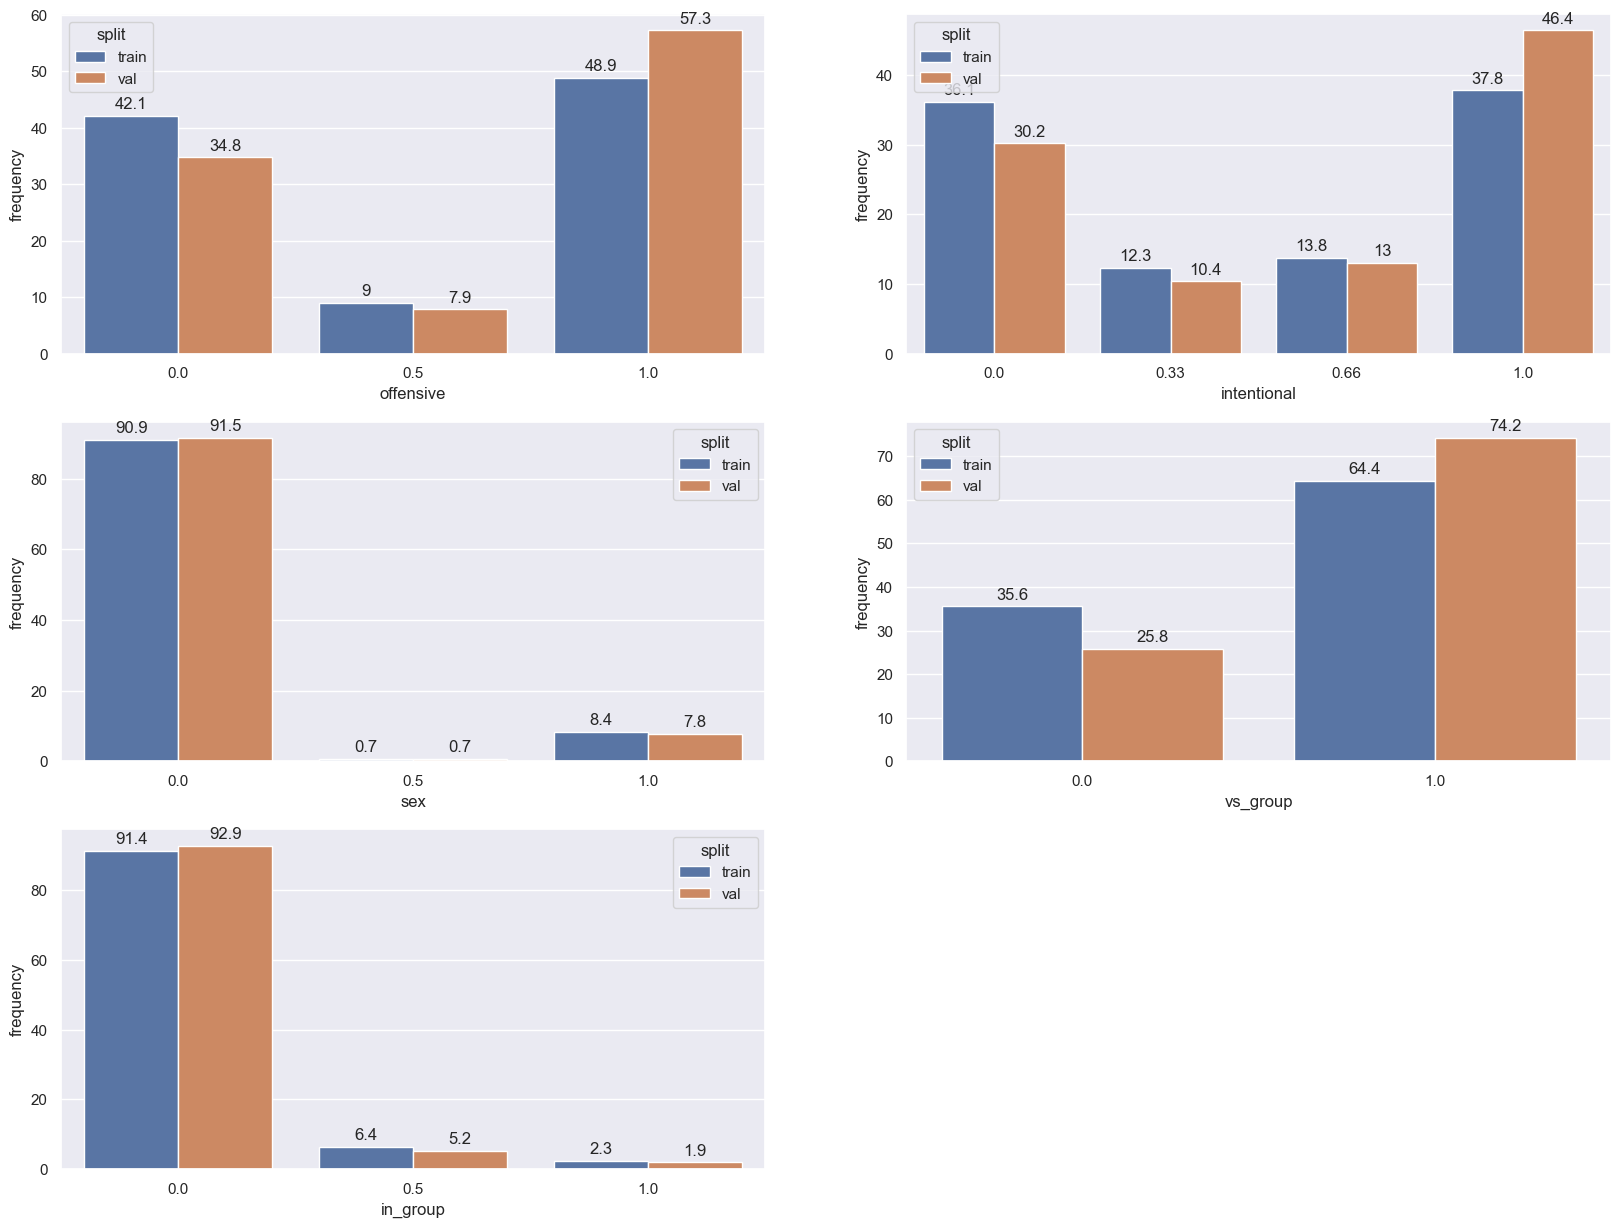

In [ ]:
plot_cls_distribution(df_cls, cls_cols=config.classification_columns, type="bar")

As shown by the plots below, there are more posts annotated as intentional or sex than the ones annotated as offensive. We must investigate this issue, as the paper states that:
1. annotators indicate whether the post is offensive, whether the intent was to offend, and whether it contains lewd or sexual content.
2. if annotators indicate potential offensiveness do they answer the group implication question. Hence, `offensive => vs_group not None`.
3. if post targets a group, annotators write which one. Hence, `vs_group => group not None`.
4. for each selected group, annotators write two to four stereotypes. Hence, each group has about 2-4 stereotypes (`vs_group => stereotype not None`).
5. annotators indicate if the writer of the post is part of one of the minority groups referenced. Hence, `vs_group => in_group not None`.

In [ ]:
print_n_annotations(df_cls)

Total number of annotations: 129638
- train: 112900
- val: 16738


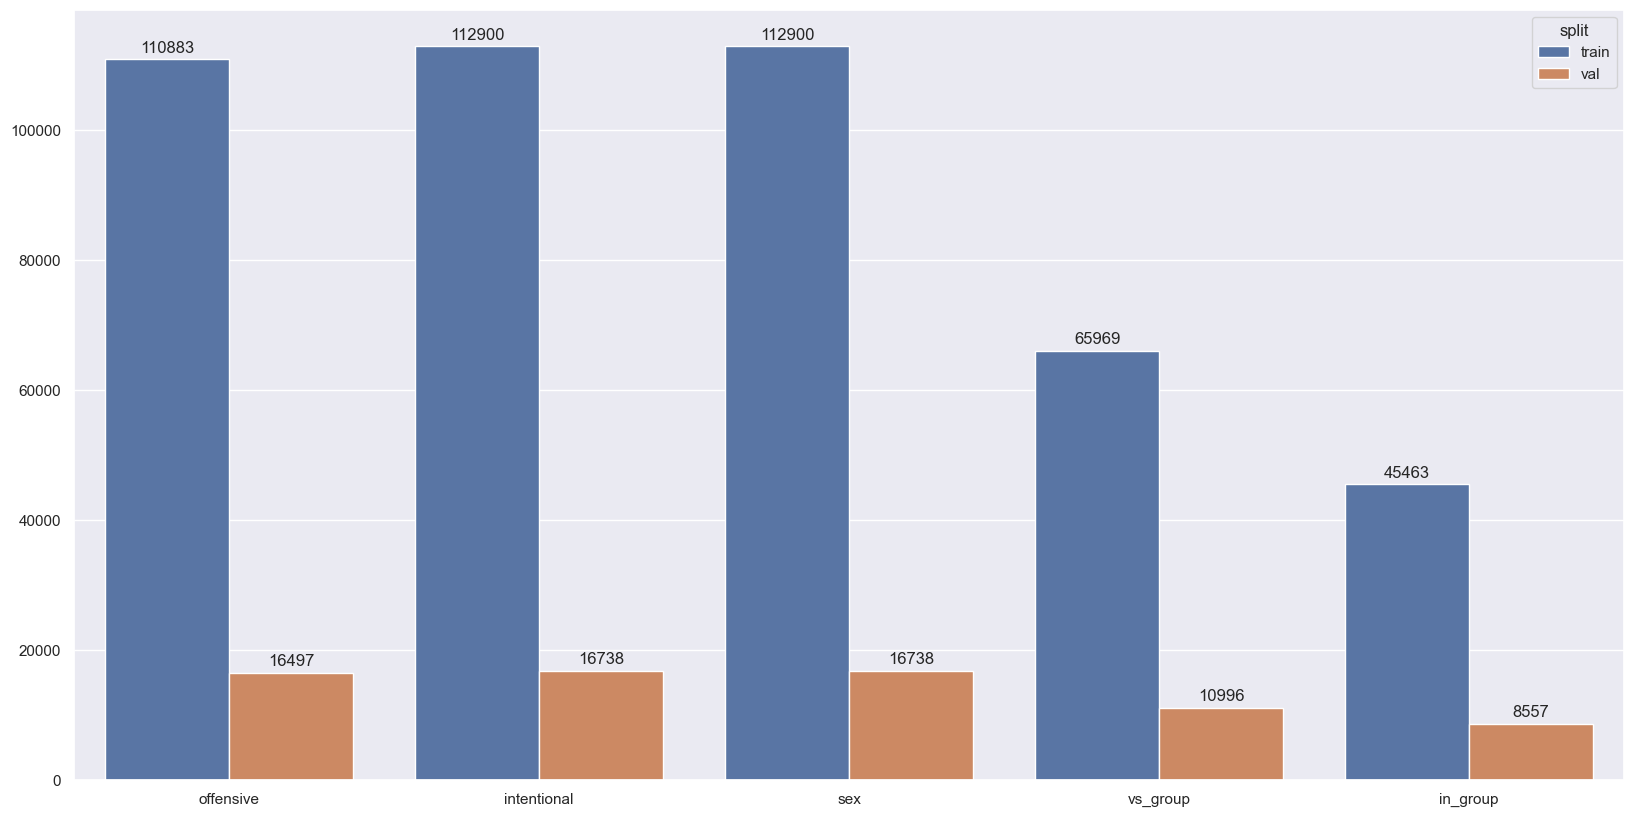

In [ ]:
plot_cls_counts(df_cls, cls_cols=config.classification_columns)

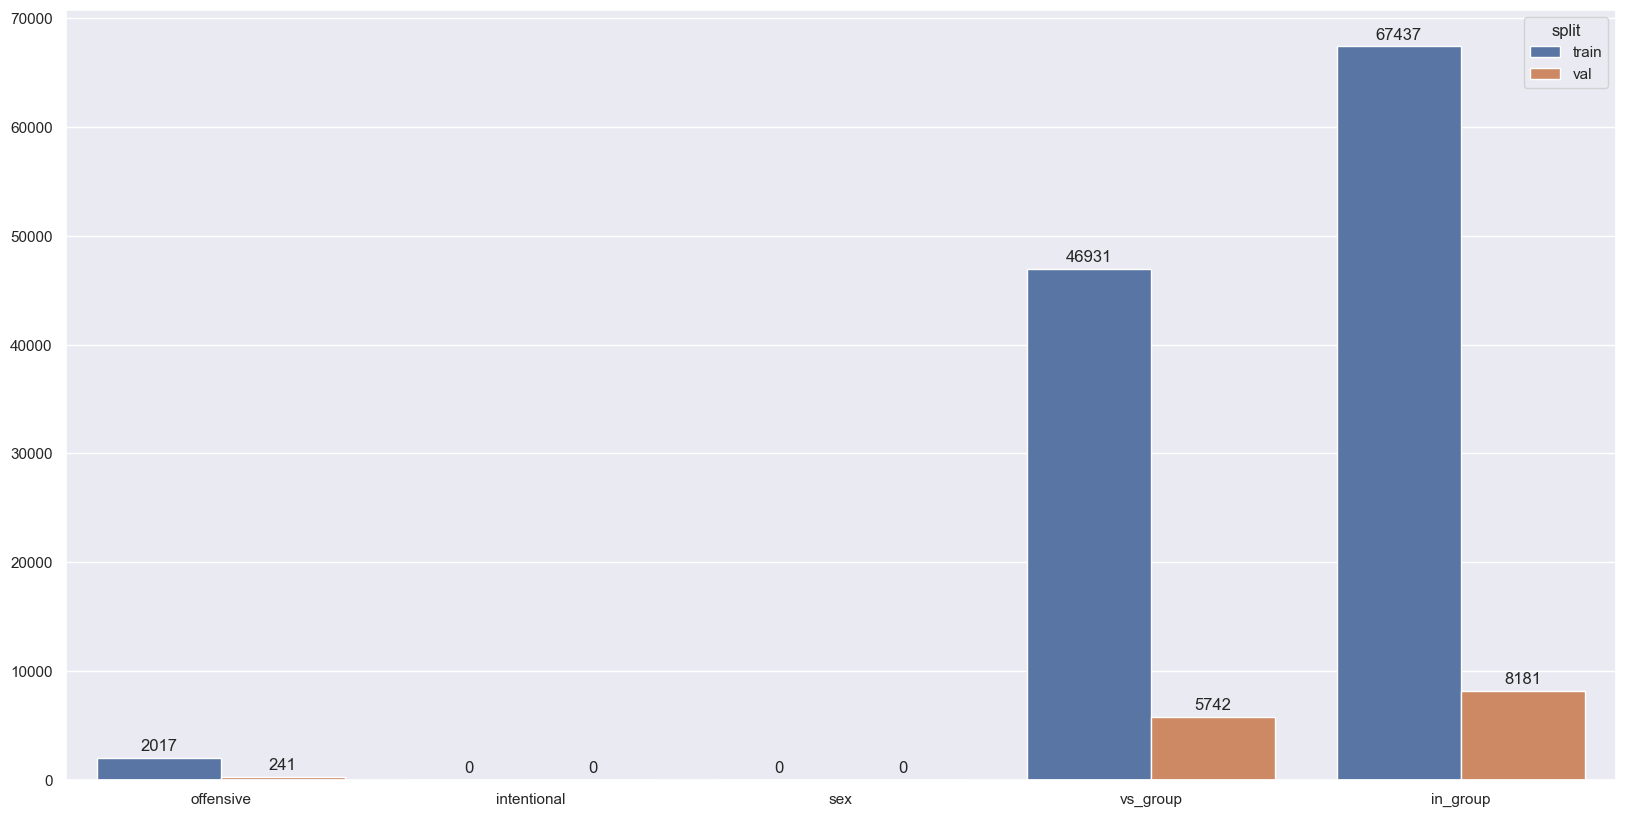

In [ ]:
plot_cls_null_counts(df_cls, cls_cols=config.classification_columns)

Since wrongly annotated posts are about 1.5% of the total posts, we just remove them from the dataset.

In [ ]:
df_cls = df_cls[df_cls["offensive"].notnull()]
print_n_annotations(df_cls)

Total number of annotations: 127380
- train: 110883
- val: 16497


Now, we must ensure that `offensive => vs_group not None`.

In [ ]:
df_valid = df_cls[(df_cls["offensive"] > 0.0) & (df_cls["vs_group"].notnull())]
df_non_valid = df_cls[(df_cls["offensive"] > 0.0) & (df_cls["vs_group"].isnull())]

print_n_annotations(df_valid, txt="Total number of valid annotations:")
print()
print_n_annotations(df_non_valid, txt="Total number of non valid annotations:")

Total number of valid annotations: 74971
- train: 64210
- val: 10761

Total number of non valid annotations: 0


And that `vs_group => in_group not None`. Again. since we have only 4 invalid annotations, we remove them from the dataset.

In [ ]:
vs_group = (df_cls["offensive"] > 0.0) & (df_cls["vs_group"] > 0.0)
df_valid = df_cls[vs_group & (df_cls["in_group"].notnull())]
df_non_valid = df_cls[vs_group & (df_cls["in_group"].isnull())]

print_n_annotations(df_valid, txt="Total number of valid annotations:")
print()
print_n_annotations(df_non_valid, txt="Total number of non valid annotations:")

df_cls = df_valid

Total number of valid annotations: 50505
- train: 42361
- val: 8144

Total number of non valid annotations: 4
- train: 4


In [ ]:
offensive_not_null = df["offensive"].notnull()
df = df[offensive_not_null]

offensive = df["offensive"] > 0.0
group_not_null = df["vs_group"].notnull()
df = df[(~offensive) | (offensive & group_not_null)]

offensive = df["offensive"] > 0.0
vs_group = offensive & (df["vs_group"] > 0.0)
in_group_not_null = df["in_group"].notnull()
df = df[(~vs_group) | (vs_group & in_group_not_null)].reset_index(drop=True)

print_n_annotations(df)

Total number of annotations: 127376
- train: 110879
- val: 16497


We ensure that `vs_group => (group not None, stereotype not None)`.

In [ ]:
vs_group = (df["offensive"] > 0.0) & (df["vs_group"] > 0.0)
df_valid = df[vs_group & (df["group"].notnull())]
df_non_valid = df[vs_group & (df["group"].isnull() | df["stereotype"].isnull())]

print_n_annotations(df_valid, txt="Total number of valid annotations:")
print()
print_n_annotations(df_non_valid, txt="Total number of non valid annotations:")

Total number of valid annotations: 50505
- train: 42361
- val: 8144

Total number of non valid annotations: 938
- train: 783
- val: 155


It's time to filter out invalid annotations from the dataset and to set to None the features according to the rules stated above.

In [ ]:
print("Number of annotations before removing invalid annotations:")
print(data.num_rows)

data = data.filter(is_annotation_valid)

print("Number of annotations after removing invalid annotations:")
print(data.num_rows)
print()

print("Setting target features to None according to annotation rules...")
data = data.map(set_features_to_null_wrt_rules)

Number of annotations before removing invalid annotations:
{'train': 112900, 'val': 16738, 'test': 17501}


Number of annotations after removing invalid annotations:
{'train': 110096, 'val': 16342, 'test': 17084}

Setting target features to None according to annotation rules...


## Group labels analysis and reduction

For each post, our model has to predict a set of targetted groups. So, we cannot solve the task as a classic classification problem, but we may approach it as a generative task. Nevertheless, we can try to reduce the space of generated groups, by semantically aggregating such labels. We think that too high diversity is not good, so we reduce the space of group labels. This will increase data quality and, consequently, network performances.

We start with visualizing all the groups divided by category.

In [ ]:
df = to_pandas(data)
df_groups = df[df["group"].notnull()]

n_groups = len(df["group"].unique())

print("Number of unique groups:", n_groups)
print()


groups_by_category = df_groups.groupby("group_category")["group"].apply(set)

for category, pieces in groups_by_category.items():
    print(category)
    print(list(pieces))
    print()

Number of unique groups: 1404

body
['skinny men', 'Red-haired persons', 'virgins', 'Millennials', 'deaf folks', 'teen moms', 'fraternity members', 'anorexic', 'overweight/fat folks, ugly folks', 'young folks', 'minor girls', 'uncles', 'woman with small breasts', 'skinny folks', 'breast size', 'Parents', 'red-haired people', 'overweight/fat folks, ugly folks, "incels" or celibate not by choice', 'Attractive folks', 'millennials', 'little people', 'ugly folks, Good looking folks', 'Young people', 'blonde women', 'Millenials/Generation Z', 'Young kids', 'teenage girls', 'kids', 'unwed non parents', 'old folks', 'Blondes', 'pedophiles', 'teenagers', 'infant', 'sexual women', 'ugly folks', 'younger genereration', 'cancer patients', 'shorts folks', 'old folks, seniors', 'babies', 'bald folks', 'pregnant folks, parents', 'emo', 'Young boys', 'young children', 'young girls', 'siblings', 'old folks, overweight/fat folks', 'blondes', '18 year olds', 'orphans', 'high school students', 'young peo

As you can see from above, some groups contains two slash-separated words. By splitting them in two different ones, we are able reduce the total number.

In [ ]:
pieces = flatten(df_groups["group"].apply(split_group_labels))
pieces = [lower(group) for group in pieces]
print("Number of unique groups:", np.unique(pieces).size)

Number of unique groups: 1125


We want to reduce the number of labels according to their semantic meaning. As an example, `blacks` and `black people` represent the same concept. Therefore, we keep only one of them. We try to cluster labels in a semi-automated manner, exploiting a text-embedding model. According to [MTEB](https://arxiv.org/abs/2210.07316), the best embedding model for text similarity is [UAE-Large-V1](https://huggingface.co/WhereIsAI/UAE-Large-V1).

In [ ]:
text_similarity = TextSimilarity(config.embedding_model)
group_lbl_processor = GroupLabelProcessor(pieces)
group_lbl_processor.remove_double_spaces()
group_labels = group_lbl_processor.label_list()
print("Number of unique groups:", len(group_labels))

Number of unique groups: 1001


In [ ]:
embedding_space = text_similarity.generate_embeddings(group_labels)
similarity_matrix = text_similarity.compute_pairwise_similarity_matrix(
    embedding_vectors=embedding_space
)

The (low-dimensional projection of the) embedding space shows some clusters.

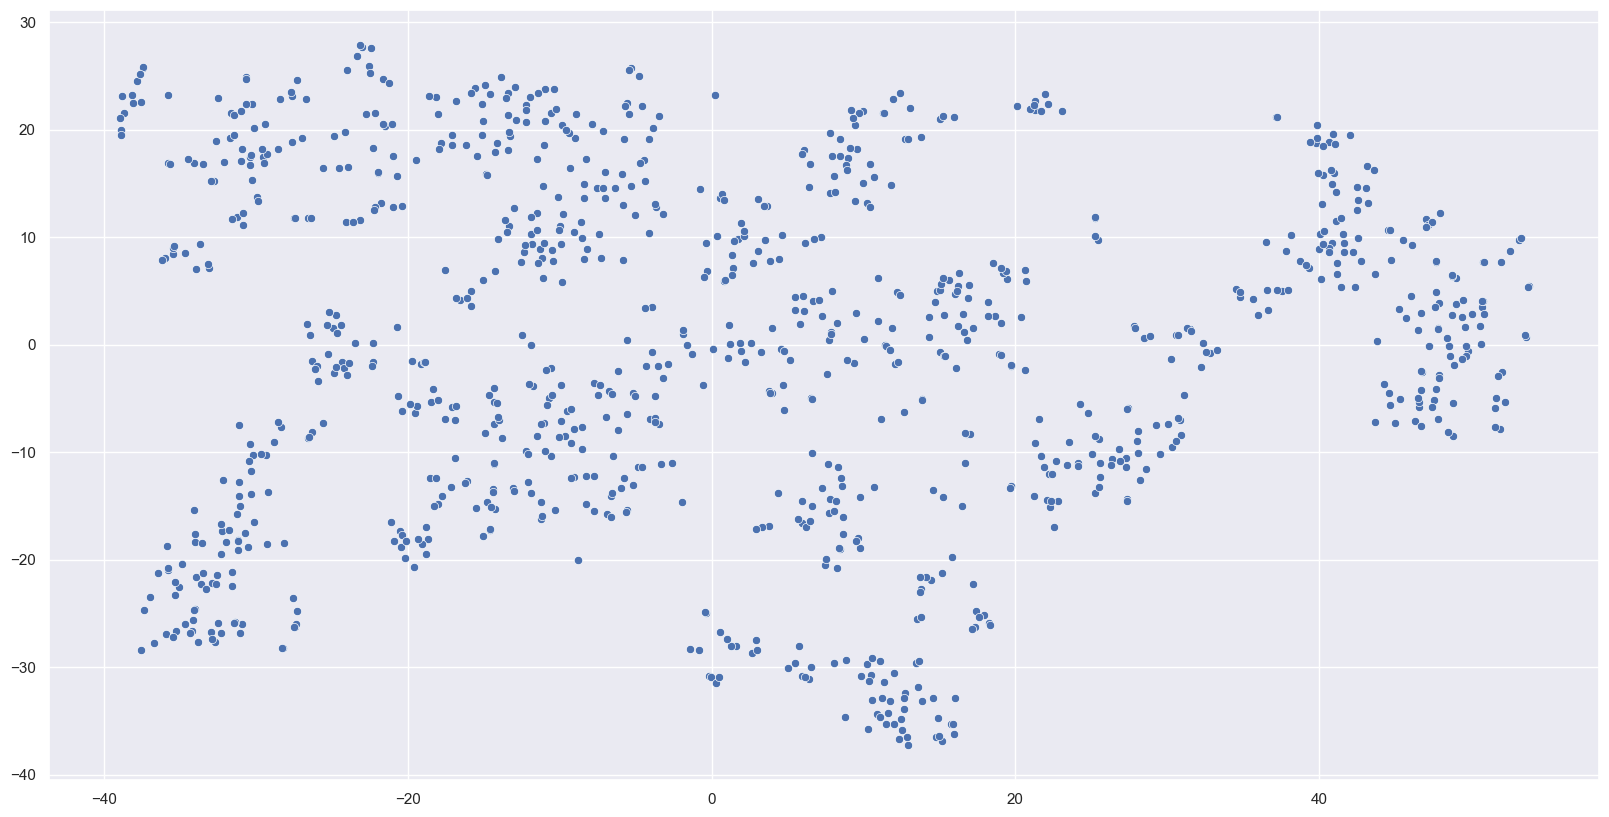

In [ ]:
show_embedding_space(embedding_space, pca_components=20)

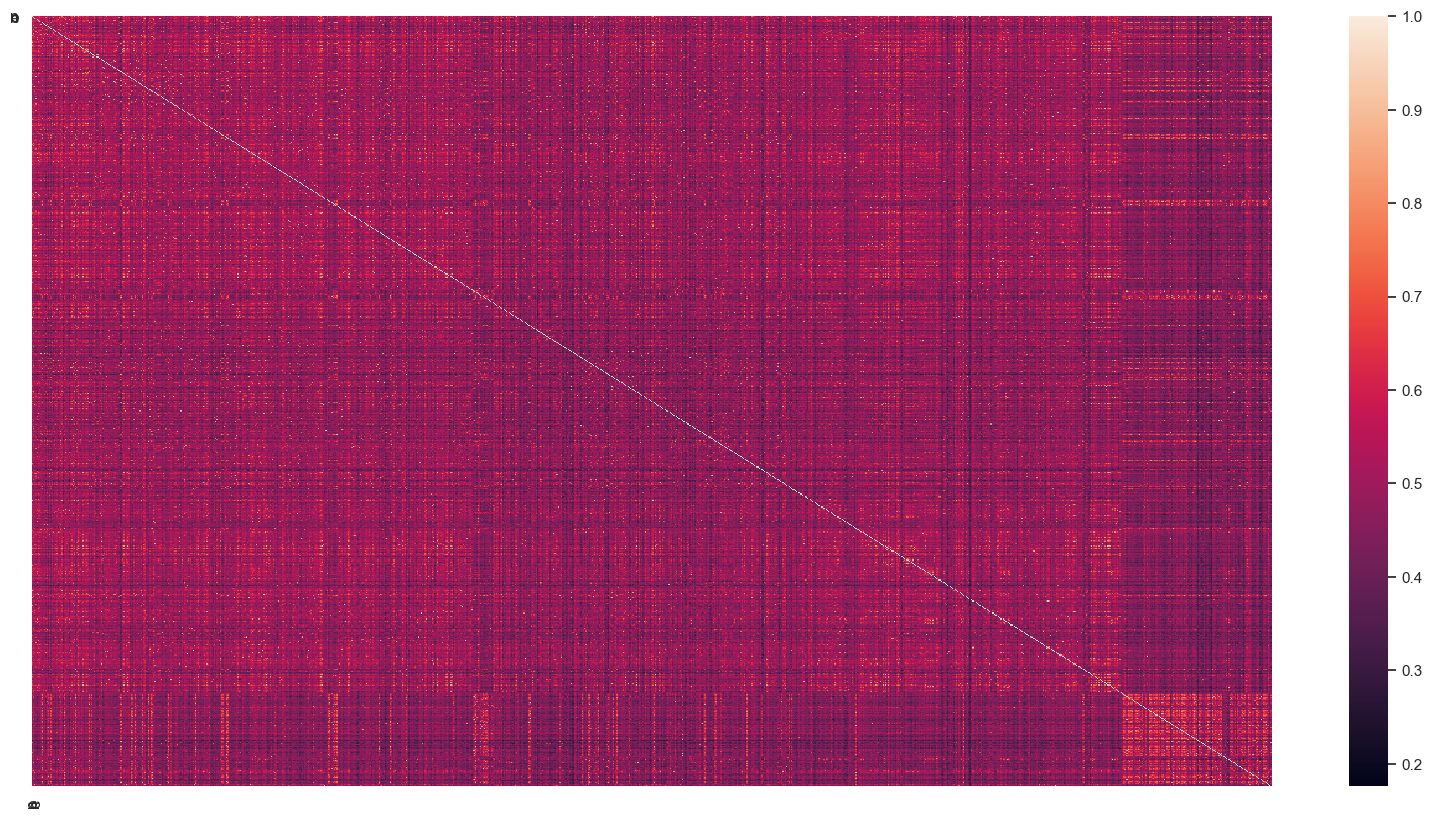

In [ ]:
ax = sns.heatmap(similarity_matrix, xticklabels="none", yticklabels="none")

Most of the labels have very low similarity. Let's set a threshold.

<Axes: >

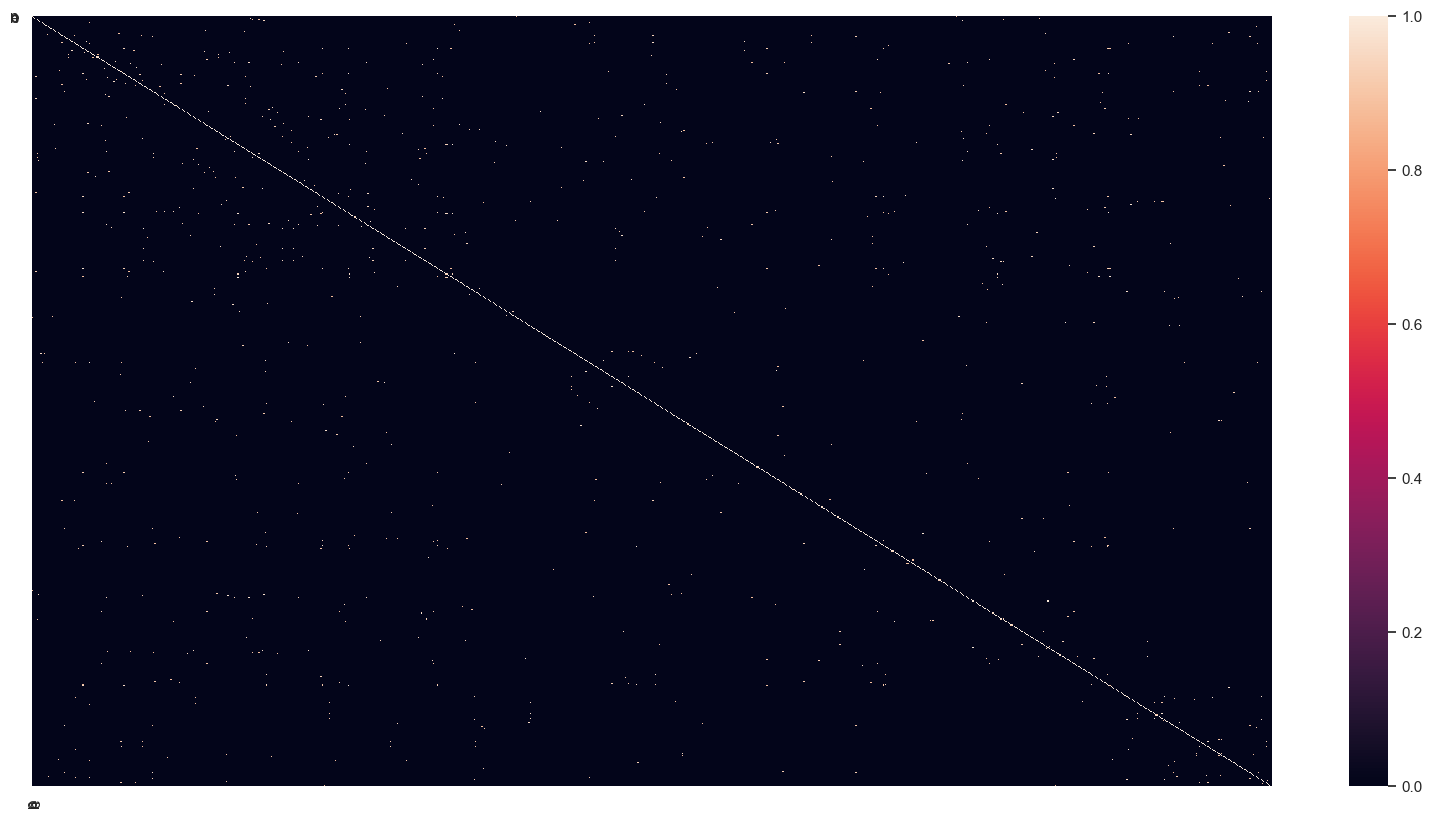

In [ ]:
threshold = 0.88
sns.heatmap(
    similarity_matrix * (similarity_matrix > threshold),
    xticklabels="none",
    yticklabels="none",
)

In [ ]:
aggregation_proposals = aggregation_proposals_by_similarity(
    group_labels, similarity_matrix, threshold=threshold
)
print_aggregation_proposals(aggregation_proposals, group_lbl_processor.groups_count)

black folks (18046): {'blacks', 'light skinned black folks'}
jewish folks (5716): {'jewish folk', 'jewish people'}
muslim folks (2608): {'islamic folks', 'islamic people', 'muslims', 'muslim'}
gay men (1893): {'gay folks', 'gay people', 'homosexual men'}
asian folks (1693): {'asians', 'asian people'}
physically disabled folks (1344): {'disabled people', 'disabled folks', 'the handicapped'}
assault victims (1016): {'sex assault victims', 'sexual assault victims'}
mentally disabled folks (958): {'disabled people', 'disabled folks'}
folks with mental illness/disorder (670): {'folks with physical illness/disorder'}
mass shooting victims (658): {'shooting victims'}
native american/first nation folks (557): {'indigenous folks'}
overweight/fat folks (505): {'fat people', 'fat folks'}
arabic folks (483): {'arab folks'}
trans men (413): {'cis men'}
feminists (410): {'feminist', 'feminist women'}
folks with physical illness/disorder (357): {'folks with mental illness/disorder'}
africans (300): {

At a first sight, results seem very good. Let's start by inspecting groups that have punctuations.

In [ ]:
print_txt_with_punctuations(group_labels)

Punctuation: /
eastern/indian people
holocaust survivors/jews
priests/nuns
german people/jewish people
indian/pakistani people
pakistan/indian people
rednecks/south region in the us
folks with mental illness/disorder
overweight/fat folks
middle eastern / arabic people
latino/latina folks
folks with physical illness/disorder
bullimacs/anorexics
gypsies/ romani
millenials/generation z
gay/lesbians
everyone/parents/children
people who self-harm/are suicidal
members of the irish repulbican army and/or the ira political group in ireland.
rural/ country folks
africa/middle east
any racial/ethnic minority in america
native american/first nation folks
independents/libertarians
syrians/russians
sexual assault/rape victims
brown/asian people
kidnap/violence/murder victims
southerners/ rednecks
middle east/africa
victims of 9/11

Punctuation: -
alt-right
middle-eastern folks
basically all non-white women
non-christians
self-harming people
red-haired persons
non-binary people
pro-life advocates
no

From the analysis above, we have that:
1. text between parenthesis is irrelevant. We remove it.
2. `? ' " .` are irrelevant. We remove them, paying attention to keep `'s 't`.
3. `-` can be replaced by space.

In [ ]:
punct_substitution_map = {
    r"\(.*\)": " ",
    r'[\?".]': " ",
    r"'(?![st])": " ",
    r"\s*-\s*": " ",
    r"\band\s*/\s*or\b": "or",
}
group_lbl_processor.rename_groups(punct_substitution_map)
group_lbl_processor.remove_double_spaces()
group_labels = group_lbl_processor.label_list()

print("Number of unique groups:", len(group_labels))
print()
print_txt_with_punctuations(group_labels)

Number of unique groups: 981

Punctuation: /
people who self harm/are suicidal
eastern/indian people
holocaust survivors/jews
priests/nuns
german people/jewish people
indian/pakistani people
pakistan/indian people
rednecks/south region in the us
folks with mental illness/disorder
overweight/fat folks
middle eastern / arabic people
latino/latina folks
folks with physical illness/disorder
bullimacs/anorexics
gypsies/ romani
millenials/generation z
gay/lesbians
everyone/parents/children
rural/ country folks
africa/middle east
any racial/ethnic minority in america
native american/first nation folks
independents/libertarians
syrians/russians
sexual assault/rape victims
brown/asian people
kidnap/violence/murder victims
southerners/ rednecks
middle east/africa
victims of 9/11

Punctuation: '
anyone that isn't white
germans and anyone that's sensitive about the hol
women's who ve had abortions
gypsy's
folks with alzheimer's
jehova's witnesses
parkinson's
jehovah's witnesses
people who's father

Moreover, to reduce labels to inspect by hand, let's craft some deterministic rules based on aggregations found:
1. people, persons and folks are used interchangeably. Hence, we change folk(s) into people.
2. children and kids are used interchangeably. We keep children.
3. illness and disorder are used interchangeably. We keep illness.
4. fat and overweight are used interchangeably. We keep fat.

Labels containing a slash or an and/or conjunction may contain multiple concepts. Therefore, we ignore them at the moment.

In [ ]:
substitution_map = {
    r"\b(?:(?:illness\s*/\s*disorders?)|(?:disorders?\s*/\s*illness)|(?:disorders?))\b": "illness",
    r"\b(?:(?:fat\s*/\s*overweight)|(?:overweight\s*/\s*fat)|(?:overweight))\b": "fat",
}
group_lbl_processor.rename_groups(substitution_map)

substitution_map = {
    r"\b(folks?)|(persons?)\b": "people",
    r"\bkids\b": "children",
}
group_labels = group_lbl_processor.label_list()
single_concept_labels = filter_out_labels_with_multiple_concepts(group_labels)
group_lbl_processor.rename_groups(substitution_map, groups=single_concept_labels)

group_labels = group_lbl_processor.label_list()
single_concept_labels = filter_out_labels_with_multiple_concepts(group_labels)
print("Number of unique groups:", len(group_labels))
print("Number of unique groups w/o slash, and, or:", len(single_concept_labels))

Number of unique groups: 926
Number of unique groups w/o slash, and, or: 881


We know that most of the nationalities have the suffix `an`. Therefore, we can hardcode such rules.

In [ ]:
aggregation_preferences = defaultdict(list)
label_set = set(group_labels)

for lbl in single_concept_labels:
    match = re.search(r"(.+)n people", lbl)
    if match is not None:
        nation = match.group(1)
        nationality = nation + "n"

        if nation in label_set:
            aggregation_preferences[lbl].append(nation)
        if nationality in label_set:
            aggregation_preferences[lbl].append(nationality)

print_aggregation_proposals(aggregation_preferences, group_lbl_processor.groups_count)

asian people (1695): ['asia', 'asian']
african people (200): ['africa', 'african']
mexican people (95): ['mexican']
indian people (95): ['india', 'indian']
ethiopian people (85): ['ethiopia', 'ethiopian']
middle eastern people (34): ['middle eastern']
syrian people (22): ['syria', 'syrian']
german people (14): ['german']
russian people (12): ['russia', 'russian']
saudi arabian people (10): ['saudi arabia']
nigerian people (9): ['nigeria']
afghan people (8): ['afghan']
korean people (8): ['korea']
italian people (6): ['italian']
arabian people (4): ['arabian']
jamaican people (4): ['jamaica', 'jamaican']
pagan people (3): ['pagan']
malaysian people (2): ['malaysia']
pakistan people (2): ['pakistan']
somalian people (2): ['somalia', 'somalian']
cambodian people (2): ['cambodia']
palestinian people (2): ['palestinian']
egyptian people (2): ['egyptian']


Let's inspect groups ending with term `people`.

In [ ]:
similarity_matrix = text_similarity.compute_pairwise_similarity_matrix(
    single_concept_labels
)
aggregation_proposals = aggregation_proposals_by_similarity(
    single_concept_labels, similarity_matrix, threshold=threshold
)
people_agg_proposals = {
    group: agg
    for group, agg in aggregation_proposals.items()
    if group.endswith("people")
}

print_aggregation_proposals(people_agg_proposals, group_lbl_processor.groups_count)

black people (18046): {'blacks', 'people of african descent', 'light skinned black people', 'any black people'}
jewish people (5726): {'jews', 'jewish'}
muslim people (2608): {'islamic people', 'muslims', 'muslim'}
asian people (1695): {'asians', 'asian'}
physically disabled people (1344): {'disabled people', 'the handicapped'}
mentally disabled people (958): {'disabled people'}
arabic people (483): {'arab people'}
white people (291): {'whites'}
african people (200): {'people of african descent', 'black africans', 'africans'}
mexican people (95): {'mexicans'}
indian people (95): {'people from india'}
ethiopian people (85): {'ethiopians', 'ethiopian'}
non white people (39): {'non whites', 'american non whites', 'all non whites', 'any non white people', 'non white', 'all non white people'}
middle eastern people (34): {'middle easterners', 'people from the middle east', 'middle eastern', 'middle easterns'}
irish people (28): {'irishmen'}
young people (25): {'younger people'}
syrian people

Before automatically merging all groups, we want to prevent some aggregation to happens and to force other ones.

In [ ]:
aggregation_blacklist = [
    ("black people", "people of african descent"),
    ("black people", "light skinned black people"),
    ("physically disabled people", "disabled people"),
    ("mentally disabled people", "disabled people"),
    ("the handicapped", "disabled people"),
    ("gay people", "homosexual people"),
    ("gay people", "homosexuals"),
    ("gay people", "queer people"),
    ("homosexual people", "homosexual men"),
    ("gays", "homosexuals"),
    ("gays", "homosexuals"),
    ("homosexual men", "homosexuals"),
    ("lgbtq+ people", "queer people"),
    ("interracial people", "interracial couples"),
    ("gendered people", "gender fluid people"),
]


aggregation_preferences.update(
    {
        "american southern people": ["southern people"],
        "physically disabled people": ["the handicapped"],
    }
)

We have some labels containing the fact and others where the fact is followed by `victims` or `survivors`, e.g. `sex assault victims`. Let's aggregate them.

In [ ]:
victims_aggregates = defaultdict(list)

for lbl in single_concept_labels:
    match = re.match(r"(.+) \b(survivor|victim)s?\s*$", lbl)
    if match is not None:
        fact = match.group(1)
        dest_group = f"{fact} {match.group(2)}s"

        if fact in label_set:
            victims_aggregates[dest_group].append(fact)
        if dest_group != lbl:
            victims_aggregates[dest_group].append(lbl)

victims_aggregates.pop("homeless victims")
aggregation_preferences.update(victims_aggregates)
print_aggregation_proposals(victims_aggregates, group_lbl_processor.groups_count)

holocaust victims (272): ['holocaust']
rape victims (144): ['rape', 'rape', 'rape victim']
sexual assault victims (80): ['sexual assault', 'sexual assault', 'sexual assault victim']
pedophilia victims (27): ['pedophilia']
suicide victims (21): ['suicide']
holocaust survivors (21): ['holocaust']
incest victims (19): ['incest']
domestic abuse victims (10): ['domestic abuse']
child murder victims (4): ['child murder']
kidnap victims (0): ['kidnap victim']
jewish victims (2): ['jewish']
child rape victims (35): ['child rape victim']
tragedy victims (1): ['tragedy victim']
sexual assault survivors (1): ['sexual assault']
mass accident victims (1): ['mass accident']
miscarriage survivors (1): ['miscarriage']
police shooting victims (0): ['police shooting victim']
miscarriage victims (1): ['miscarriage']
assassination victims (1): ['assassination victim']


Now, let's inspect remaining labels.

In [ ]:
remaining_agg_proposals = {
    group: agg
    for group, agg in aggregation_proposals.items()
    if not group in people_agg_proposals
}

print_aggregation_proposals(remaining_agg_proposals, group_lbl_processor.groups_count)

gay men (1893): {'gay people', 'homosexual men'}
assault victims (1016): {'sex assault victims', 'sexual assault victims'}
mass shooting victims (658): {'shooting victims'}
trans men (413): {'cis men'}
feminists (410): {'feminist', 'feminist women'}
people with physical illness (357): {'sick people'}
africans (300): {'people of african descent', 'black africans', 'african people', 'african'}
holocaust victims (272): {'holocaust survivors', 'holocaust victimes'}
children (257): {'young children'}
ethiopians (215): {'ethiopian people', 'ethiopian'}
rape victims (144): {'rape victim', 'sex assault victims', 'sexual assault victims'}
people of color (124): {'people of different races'}
non whites (99): {'american non whites', 'all non whites', 'any non white people', 'non white people', 'nonwhite', 'non white', 'any non white', 'all non white people'}
sexual assault victims (80): {'child sexual assault victims', 'sex abuse victims', 'sexual assault survivors', 'sexual assault victim', 'vic

In [ ]:
aggregation_blacklist.extend(
    [
        ("assault victims", "sexual assault victims"),
        ("assault victims", "sex assault victims"),
        ("sexual assault victims", "child sexual assault victims"),
        ("sex assault victims", "child sexual assault victims"),
        ("sex abuse victims", "child sexual abuse victims"),
        ("sex abuse victims", "victims of child sexual abuse"),
        ("abuse victims", "domestic abuse victims"),
        ("abuse victims", "sex abuse victims"),
        ("abuse victims", "child abuse victims"),
        ("straight white men", "white men"),
        ("straight white men", "white guys"),
        ("minorities", "racial minorities"),
        ("minorities in general", "racial minorities"),
        ("minority", "racial minorities"),
        ("minority groups", "racial minorities"),
        ("minority people", "racial minorities"),
        ("all minorities", "all racial minorities"),
        ("accident victims", "car accident victims"),
        ("accident victims", "auto accident victims"),
        ("accident victims", "car crash victims"),
        ("all colored races", "all races"),
        ("people of color", "people of different races"),
        ("trans men", "cis men"),
        ("refugees", "syrian refugees"),
        ("murder victims", "murder victim families"),
        ("molestation victims", "child molestation victims"),
        ("people of different races", "people of color"),
        ("american non whites", "non americans"),
        ("non europeans", "non americans"),
    ]
)


aggregation_preferences.update(
    {
        "black people": ["people of color"],
        "women with small breasts": ["woman with small breasts"],
    }
)

In [ ]:
preferences = {
    group: aggregation_preferences.pop(group, [])
    for group in people_agg_proposals.keys()
}
preferences.update(aggregation_preferences)
group_lbl_processor.aggregate(aggregation_proposals, aggregation_blacklist, preferences)

group_labels = group_lbl_processor.label_list()
single_concept_labels = filter_out_labels_with_multiple_concepts(group_labels)

print("Number of unique groups:", len(group_labels))
print("Number of unique groups w/o slash, and, or:", len(single_concept_labels))

Number of unique groups: 632
Number of unique groups w/o slash, and, or: 587


It's time to handle groups that have a slash or an and/or conjuction. It's very likely that they are a combination of at least two groups. Therefore, we try to divide and extract these labels.

In [ ]:
slash_and_or_labels = np.setdiff1d(group_labels, single_concept_labels).tolist()
label_space = [
    lower(white_space_fix(replace_str(label, punct_substitution_map)))
    for label in group_lbl_processor.processed_labels
]
label_space = np.setdiff1d(label_space, slash_and_or_labels).tolist()
embedding_space = text_similarity.generate_embeddings(label_space)

split_map = split_on_and_or_slash(slash_and_or_labels)

Initially, we split the labels and retain the resulting groups if each group is one word long. We compute similiarity of these groups with already observed labels in order to aggregate them.

In [ ]:
most_similar = text_similarity.retrieve_n_most_similar(
    queries=flatten(split_map.values()),
    documents=label_space,
    documents_embeddings=embedding_space,
    n=1,
)
split_map = group_lbl_processor.map_split_if_all_groups_are_one_word_longs(
    split_map, most_similar, threshold, verbose=True
)

bullimacs/anorexics --> ['bullimacs', 'anorexics']
   bullimacs ('furry', 0.57818216) --> bullimacs
   anorexics ('anorexics', 1.0000002) --> anorexic people

everyone/parents/children --> ['everyone', 'parents', 'children']
   everyone ('everyone', 1.0000004) --> everyone
   parents ('parents', 1.0) --> parents
   children ('children', 1.0) --> children

gay/lesbians --> ['gay', 'lesbians']
   gay ('lgbt', 0.8647851) --> gay
   lesbians ('lesbian women', 0.94585645) --> lesbian women

girls and boys --> ['girls ', ' boys']
   girls  ('girls', 1.0000001) --> girls
    boys ('boys', 1.0) --> young boys

gypsies/ romani --> ['gypsies', ' romani']
   gypsies ('gypsies', 1.0000001) --> gypsies
    romani ('romani people', 0.92928934) --> romani people

independents/libertarians --> ['independents', 'libertarians']
   independents ('minority groups', 0.62923884) --> independents
   libertarians ('liberals', 0.74374115) --> libertarians

priests/nuns --> ['priests', 'nuns']
   priests ('prie

Then, we try to build groups according to four different strategies:
1. we take each group as it is.
2. we take the words at the end of the original label and append them to each resulting group.
3. we take the words at the beginning of the original label and prepend them to each resulting group.
4. we combine points 3 and 4.
Subsequently, for each group we keep the best strategy according to the similarity with the already observed labels. If all the obtained groups have a similarity score higher than the threshold, we apply the spli and map rules.

In [ ]:
def print_label_to_groups_mapping(
    label, best_alternatives, sim_groups, sim_scores, dest_groups
):
    print(label)
    for best_alternative, sim_group, sim_score, dest_group in zip(
        best_alternatives, sim_groups, sim_scores, dest_groups
    ):
        print(
            "-->",
            best_alternative,
            (sim_group, sim_score),
            "-->",
            dest_group,
        )
    print("-" * 30)

In [ ]:
slash_and_or_labels = np.setdiff1d(
    slash_and_or_labels, list(group_lbl_processor.label_to_groups_map.keys())
).tolist()

for label, pieces in split_map.copy().items():
    groups = []
    groups.append(pieces)

    # append words at the end to each group
    # separate the first word of last group from all the rest
    match = re.search(r"(\w+)(.*)$", pieces[-1])
    last_group = match.group(1).strip()
    words_at_end = match.group(2).strip()
    pieces_ = pieces.copy()
    pieces_[-1] = last_group
    groups.append([f"{group.strip()} {words_at_end}".strip() for group in pieces_])

    # prepend words at the beginning to each group
    # separate the last word of first group from all the rest
    match = re.search(r"(.*\b)(\w+)\s*$", pieces[0])
    words_at_beginning = match.group(1).strip()
    first_group = match.group(2).strip()
    pieces_ = pieces.copy()
    pieces_[0] = first_group
    groups.append(
        [f"{words_at_beginning} {group.strip()}".strip() for group in pieces_]
    )

    # prepend words at the beginning and append words at the end to each group
    pieces_ = pieces.copy()
    pieces_[0] = first_group
    pieces_[-1] = last_group
    groups.append(
        [
            f"{words_at_beginning} {group.strip()} {words_at_end}".strip()
            for group in pieces_
        ]
    )

    groups = np.asarray(groups).T.tolist()
    best_alternatives = []
    sim_groups = []
    sim_scores = []
    dest_groups = []
    for alternatives in groups:
        similarity_matrix = text_similarity.compute_similarity_matrix(
            alternatives, documents_embeddings=embedding_space
        )
        index = np.unravel_index(
            np.argmax(similarity_matrix), shape=similarity_matrix.shape
        )
        best_alternative = alternatives[index[0]]
        similar_group = label_space[index[1]]
        similar_score = similarity_matrix[index]
        dest_group = group_lbl_processor.get_dest_group(
            similar_group if similar_score > threshold else best_alternative
        )

        best_alternatives.append(best_alternative)
        sim_groups.append(similar_group)
        sim_scores.append(similar_score)
        dest_groups.append(dest_group)

    if all(score > threshold for score in sim_scores):
        group_lbl_processor.map_split_to_groups(label, dest_groups)
        split_map.pop(label)

        print_label_to_groups_mapping(
            label, best_alternatives, sim_groups, sim_scores, dest_groups
        )

africa/middle east
--> africa ('africa', 1.0) --> african people
--> middle east ('middle east', 0.99999994) --> middle eastern people
------------------------------
all minorities and non whites
--> all minorities  ('all minorities', 0.9999999) --> minority people
--> all non whites ('all non whites', 0.99999994) --> non white people
------------------------------
all minorities and women
--> all minorities  ('all minorities', 1.0) --> minority people
-->  women ('women', 1.0) --> women
------------------------------
brown/asian people
--> brown people ('brown people', 1.0) --> brown people
--> asian people ('asian people', 0.99999976) --> asian people
------------------------------
deaf and blind people
--> deaf people ('deaf people', 1.0000005) --> deaf people
-->  blind people ('blind people', 1.0) --> blind people
------------------------------
german people/jewish people
--> german people ('german people', 0.9999999) --> german people
--> jewish people ('jewish people', 0.9999999

Remaining labels can be manually processed, but we prefer not to do it and keep them as they are.

In [ ]:
slash_and_or_labels = np.setdiff1d(
    slash_and_or_labels, list(group_lbl_processor.label_to_groups_map.keys())
).tolist()
slash_and_or_labels

['any racial/ethnic minority in america',
 'christians and groups victimized by hitler',
 'eastern/indian people',
 "germans and anyone that's sensitive about the hol",
 'incels or celibate not by choice',
 'incels or reluctantly celebate people who identify themselves as incels',
 'latino/latina folks',
 'members of the irish repulbican army or the ira political group in ireland',
 'millenials/generation z',
 'people from north and south korea',
 'rednecks/south region in the us',
 'rural/ country folks',
 'victims of 9/11',
 'victims of poverty and starvation',
 'victims of racial and homophobic attacks',
 'zimbabwe and south africa']

Lastly, we want to see wheter groups generated from the same label are similar. In case of positive answer, we just remove the split and add a map from the label to one of the two groups.

In [ ]:
for label, groups in group_lbl_processor.label_to_groups_map.copy().items():
    similarity_matrix = text_similarity.compute_pairwise_similarity_matrix(groups)
    if np.all(similarity_matrix > threshold):
        group_lbl_processor.map_group(label, groups[0])
        group_lbl_processor.label_to_groups_map.pop(label)
        print(label, "-->", groups)

holocaust victims and survivors --> ['holocaust victims', 'holocaust victims']
sexual assault/rape victims --> ['rape victims', 'rape victims']


In [ ]:
group_lbl_processor.save(config.group_lbl_processor)

We've significantly reduced the number of groups, preserving the meaning.

In [ ]:
group_lbl_processor = GroupLabelProcessor.load(config.group_lbl_processor)
groups = df_groups["group"].apply(split_group_labels)
unique_groups = np.unique(flatten(groups))
n_groups_before = len(unique_groups)

groups = groups.apply(group_lbl_processor.transform)
unique_groups = np.unique(flatten(groups))
n_groups = len(unique_groups)

print("Number of groups before reduction:", n_groups_before)
print(
    "Number of groups after reduction:", n_groups, f"({n_groups/n_groups_before:.2%})"
)

Number of groups before reduction: 1329
Number of groups after reduction: 608 (45.75%)


Now we apply all the reductions discussed so far to obtain a cleaner version of the dataset.

In [ ]:
clean_data(config)

Loading raw data ...
Removing invalid annotations ...
Setting features to None ...
Cleaning groups ...
Saving data to data/clean ...
Complete!


## Posts Analysis and preprocessing
In this section we want to analyse and apply some preprocessing on the posts.

In [ ]:
data = datasets.load_from_disk(config.data.clean)
df = to_pandas(data)
df = df[df["split"] != "test"]
posts = df["post"].unique().tolist()
print("Number of unique posts:", len(posts))

Number of unique posts: 39995


In [ ]:
df["post"].describe()

count                                                126438
unique                                                39995
top       Where do you stick a black jew In the back of ...
freq                                                     18
Name: post, dtype: object

In [ ]:
print_n_items(posts, separator="-" * 30, shuffle=True)

Driving home after being cucked at work
This is the life of an incel
------------------------------
Why are some people necrophiliacs? They know that rigor mortis makes the pussy tighter
------------------------------
There's food in Venezuela And other hilarious jokes you can tell your friends!
------------------------------
I think girls are dumb and incapable of logical reasoning. Current company excluded, of course.
------------------------------
I once went to a scat party It was shit
------------------------------
So I want to come out of the closet but my uncle keeps putting the key in his asshole and I don't want to put my hands where my dick is going
------------------------------
In short, Trump is the demon of our puritanical sickness. Why did we give a fuck who he fucked? Why was he hated for love?
------------------------------
Did you hear about the KKK member with a Chinese girlfriend? Both their families hold a General Lee(Li) in high regard.
---------------------------

Since posts are scraped from web, they have html escaped strings. We unescape them, getting the corresponding unicode string.

In [ ]:
html_escaped_posts = [post for post in posts if constains_html_escaped_str(post)]
html_unescaped_posts = [unescape_html_str(post) for post in html_escaped_posts]
posts = [
    unescape_html_str(unescape_html_str(post)) for post in posts
]  # there are posts where the html escaped string has been escaped

print("Number of html escaped posts:", len(html_escaped_posts))

Number of html escaped posts: 3160


In [ ]:
print_mapping(
    html_escaped_posts, html_unescaped_posts, separator="-" * 30, shuffle=True
)

from:	 if someone trust you and send you nudes.. why expose them like that just because y'all fall out. that's FUCKED up!&#128175;&#128405;&#127998;
to:	 if someone trust you and send you nudes.. why expose them like that just because y'all fall out. that's FUCKED up!💯🖕🏾
------------------------------
from:	 If you don't wanna go out. It's not shit to do when you're single and all your friends aren't. I'm so bored. &#128553;&#128580;
to:	 If you don't wanna go out. It's not shit to do when you're single and all your friends aren't. I'm so bored. 😩🙄
------------------------------
from:	 &#8220;@My_Fish_Died: You dammn Weed potheads are annoying af on Twitter&#8221; weed and pot are the same thing faggot
to:	 “@My_Fish_Died: You dammn Weed potheads are annoying af on Twitter” weed and pot are the same thing faggot
------------------------------
from:	 RT @yooSlim Y'all Virgo bitches gotta chill thinking y'all Beyonc&#232; &#128514;&#128514;&#128514;
to:	 RT @yooSlim Y'all Virgo bitches g

Morover, they contain lots of links. Most of them are links to the original twitter post and seem to be the result of an html parsing tool. First of all, we completely remove them if they are at the end of the post.

In [ ]:
post_with_links = [post for post in posts if contains_links(post)]
post_with_links_removed = [remove_links(post) for post in post_with_links]
posts = [remove_links(post) for post in posts]

print("Number of posts affected by link removal:", len(post_with_links))

Number of posts affected by link removal: 943


In [ ]:
print_mapping(
    post_with_links, post_with_links_removed, separator="-" * 30, shuffle=True
)

from:	 On acquiring spiritual discipline : Knowledge carefully selected and recorded is spiritually… https://t.co/lyfpcJlgpr
to:	 On acquiring spiritual discipline : Knowledge carefully selected and recorded is spiritually… 
------------------------------
from:	 My baby already not playing wit y'all! lol #trillveal #iceteam #teamveal #princesszoe… https://t.co/HnNROUr3nI
to:	 My baby already not playing wit y'all! lol #trillveal #iceteam #teamveal #princesszoe… 
------------------------------
from:	 @RogerJStoneJr @billmaher I guess being a bernie supporter as well as telling the truth makes me a Russian troll! A… https://t.co/8NQnnlZhcn
to:	 @RogerJStoneJr @billmaher I guess being a bernie supporter as well as telling the truth makes me a Russian troll! A… 
------------------------------
from:	 BBC Breaking News – 13/11/15 Paris Terror Attacks part 1 (9pm to 9:15pm) https://t.co/XU8mWNqkrY https://t.co/BK4bQzTOem
to:	 BBC Breaking News – 13/11/15 Paris Terror Attacks part 1 (9pm to 9:

Posts have lots of emojis. Since models we will use have not been pretrained with emojis, we think that replacing them with their corresponding shortcodes (a string describing the emoji) allows to effectively use information provided by emojing, leveraging pretraining.

In [ ]:
post_with_emojis = [post for post in posts if emoji.emoji_count(post) > 0]
post_with_emojis_replaced = [emoji.demojize(post) for post in post_with_emojis]
posts = [emoji.demojize(post) for post in posts]

print("Number of posts affected by emoji replacing:", len(post_with_emojis))

Number of posts affected by emoji replacing: 2353


In [ ]:
print_mapping(
    post_with_emojis, post_with_emojis_replaced, separator="-" * 30, shuffle=True
)

from:	 RFT Tweet of the day🙌🙌 “@HereForEB: If a nigga change on you.. Fuck em .. He was a bitch nigga from day 1”
to:	 RFT Tweet of the day:raising_hands::raising_hands: “@HereForEB: If a nigga change on you.. Fuck em .. He was a bitch nigga from day 1”
------------------------------
from:	 My economics professor just called these asians retards 😂😂😂
to:	 My economics professor just called these asians retards :face_with_tears_of_joy::face_with_tears_of_joy::face_with_tears_of_joy:
------------------------------
from:	 "hate when bitches say ""ion need nobody "" but be mad when nobody check on you , well shawty you don't need me so 🤷🏽‍♀️."
to:	 "hate when bitches say ""ion need nobody "" but be mad when nobody check on you , well shawty you don't need me so :woman_shrugging_medium_skin_tone:."
------------------------------
from:	 HUGE congrats goes out to @1erinrichardson for winning the @UofT National Scholarship! Couldn't have gone to anyone more deserving!👏🎉
to:	 HUGE congrats goes 

Reddit comments start with `RT @<author>:`. We remove it.

In [ ]:
post_starting_with_rt_at_author = [
    post for post in posts if starts_with_RT_at_author(post)
]
post_with_rt_at_author_removed = [
    remove_RT_at_author(post) for post in post_starting_with_rt_at_author
]
posts = [remove_RT_at_author(post) for post in posts]

print(
    "Number of posts starting with RT @<author>:", len(post_starting_with_rt_at_author)
)

Number of posts starting with RT @<author>: 695


In [ ]:
print_mapping(
    post_starting_with_rt_at_author,
    post_with_rt_at_author_removed,
    separator="-" * 30,
    shuffle=True,
)

from:	 RT @SpaceCatPics: Meow, bitches
to:	 Meow, bitches
------------------------------
from:	 RT @_ImOVERSEAS: Hoes out here selling pussy for some new uggs! You disqualified
to:	 Hoes out here selling pussy for some new uggs! You disqualified
------------------------------
from:	 RT @olmelonhead: bitches be acting different! :face_with_tears_of_joy: buuut it's cool! :person_tipping_hand:
to:	 bitches be acting different! :face_with_tears_of_joy: buuut it's cool! :person_tipping_hand:
------------------------------
from:	 RT @BRIABACKWOODS: PSA: if you're sneezing, cover your fucking mouth.
to:	 PSA: if you're sneezing, cover your fucking mouth.
------------------------------
from:	 RT @Ambeerrxoxo: I'll piss on a hoe
to:	 I'll piss on a hoe
------------------------------
from:	 RT @SenseiQuan: Hoes ain't shit RT @Now_Thats_Fresh: How superficial bitches are 
to:	 Hoes ain't shit RT @Now_Thats_Fresh: How superficial bitches are 
------------------------------
from:	 RT @LoveLifeEst13

Lastly, we substitute some confusable unicode characters with the corresponding ASCII characters (e.g. `‘` with `'`). Then, we remove double white spaces.

In [ ]:
posts = [preprocess_post(post) for post in posts]

In [ ]:
print_n_items(posts, separator="-" * 30, shuffle=True)

we can learn a lot from the mexican people . like how to leave mexico .
------------------------------
Former sex trafficking investigator shares their trouble with catching perpetrators "...the threshold of evidence required to hold women responsible for sex trafficking is not even in the same ballpark as for men"
------------------------------
What's 14 inches long, has a purple head, and makes women scream? Crib death.
------------------------------
8I@cker than 8I@ck? Two guys walk into a room without the lights on. One says, "Wow! This is dark!" The other says, "Yeah, almost total 8I@ckness!"
------------------------------
Douchebags druggies uglier than me are not incel Nice to know.
------------------------------
Why did the vasectomist get kicked out of medical school? He didn't make the cut
------------------------------
"""The very best thing you can do for the world is to make the most of yourself."" - Wallace D. Wattles #ScienceOfGettingRich"
------------------------------


There are some overlapping posts between train, val and test set. This may lead to overestimation of our model performance. We remove overlapping posts with the following rules:
1. remove a post from the validation set if it is present in the train or in the test set
2. remove a post from the test set if it is present in the train set

In [ ]:
data = datasets.load_from_disk(config.data.clean)

overlapping_data = data.map(lambda example: {"post": preprocess_post(example["post"])})
train_data = overlapping_data["train"]
val_data = remove_overlapping_posts(train_data, overlapping_data["val"])
test_data = remove_overlapping_posts(train_data, overlapping_data["test"])
val_data = remove_overlapping_posts(test_data, val_data)

print(
    "Overlapping between val data and train or test data:",
    len(overlapping_data["val"]) - len(val_data),
)
print(
    "Overlapping between test data and train data:",
    len(overlapping_data["test"]) - len(test_data),
)

Overlapping between val data and train or test data: 364
Overlapping between test data and train data: 352


Let's print statistics about post length. There are very short posts that may be meaningless.

      post_length                                                    
            count       mean        std  min   25%   50%   75%    max
split                                                                
test      16732.0  20.002689  12.693536  1.0  13.0  18.0  24.0  207.0
train    110096.0  20.158207  11.879057  1.0  13.0  18.0  24.0  276.0
val       15978.0  19.865252  10.581068  1.0  13.0  18.0  24.0  152.0


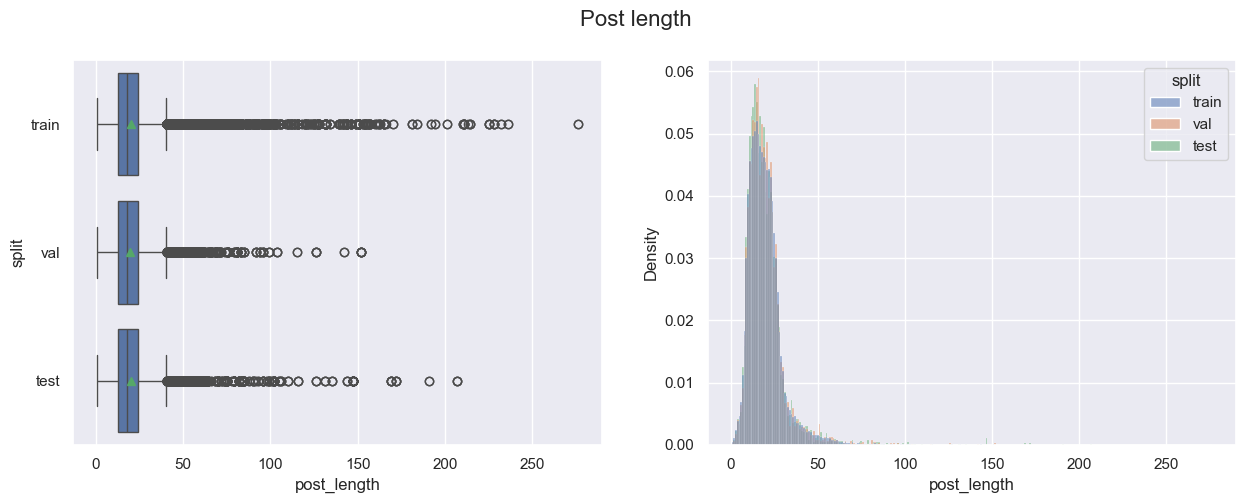

In [ ]:
data["val"] = val_data
data["test"] = test_data
df = to_pandas(data)
plot_length(df, "post")

By inspecting short posts, we can see that they are also meaningful.

In [ ]:
short_posts = df[df["post"].str.split().apply(len) < 3]
short_posts = short_posts[short_posts["split"] != "test"]
short_posts

post  offensive  intentional  sex  vs_group  \
407              so uncivilized        0.0         0.00  0.0       NaN   
408              so uncivilized        0.0         0.00  0.0       NaN   
409              so uncivilized        0.0         0.00  0.0       NaN   
808     @_____0__o______ faggot        1.0         1.00  0.0       0.0   
809     @_____0__o______ faggot        1.0         1.00  0.0       0.0   
...                         ...        ...          ...  ...       ...   
121729             Whoa! Osama!        1.0         1.00  0.0       1.0   
122060                 No homo.        1.0         1.00  0.0       1.0   
122061                 No homo.        1.0         1.00  0.0       1.0   
122062                 No homo.        1.0         0.33  0.0       1.0   
122063                 No homo.        1.0         0.33  0.0       1.0   

        in_group group_category                        group  \
407          NaN           None                         None   
408          NaN           None                         None   
409          NaN           None                         None   
808          NaN           None                         None   
809          NaN           None                         None   
...          ...            ...                          ...   
121729       0.0        culture              [muslim people]   
122060       0.0         gender  [gay people, lesbian women]   
122061       0.0         gender  [gay people, lesbian women]   
122062       0.0         gender                 [gay people]   
122063       0.0         gender                 [gay people]   

                               stereotype sexReason annotatorGender  \
407                                  None      None             man   
408                                  None      None             man   
409                                  None      None           woman   
808                                  None      None             man   
809                                  None      None             man   
...                                   ...       ...             ...   
121729           muslim folks are violent      None           woman   
122060                is a disappointment      None           woman   
122061                       are inferior      None           woman   
122062  homosexuality is negative and bad      None           woman   
122063          gay people are not normal      None           woman   

       annotatorMinority sexPhrase             WorkerId  \
407                 None      None -5870881806826799680   
408                 None      None -7353159578349448466   
409                 None      None -4210633818511154946   
808                 None      None -7452610791699819066   
809                 None      None -5870881806826799680   
...                  ...       ...                  ...   
121729              None      None  1869048359460155317   
122060              None      None -6352039173957003457   
122061              None      None -6352039173957003457   
122062              None      None  3169503690680674782   
122063              None      None  3169503690680674782   

                                 HITId annotatorPolitics annotatorRace  \
407     3VMV5CHJZ89O48IQM011TIE1BJ7TGG           liberal         white   
408     3VMV5CHJZ89O48IQM011TIE1BJ7TGG       mod-liberal         white   
409     3VMV5CHJZ89O48IQM011TIE1BJ7TGG           liberal         white   
808     3TX9T2ZCB9VGN6HP7XU11916Q3KWZZ           liberal         asian   
809     3TX9T2ZCB9VGN6HP7XU11916Q3KWZZ           liberal         white   
...                                ...               ...           ...   
121729  3DW3BNF1GHCOOLGX8XPS2NLOLEH8VP          mod-cons         white   
122060  3UEDKCTP9VK68WH2ZOJFMEECUW57KG          mod-cons         white   
122061  3UEDKCTP9VK68WH2ZOJFMEECUW57KG          mod-cons         white   
122062  3UEDKCTP9VK68WH2ZOJFMEECUW57KG           liberal         wh

## Stereotypes Analysis

Let's analyze the stereotypes.

In [ ]:
data = datasets.load_from_disk(config.data.clean)
df = to_pandas(data)
df = df[df["split"] != "test"]
stereotypes = df[df["stereotype"].notnull()]["stereotype"].unique().tolist()
print("Number of unique stereotypes:", len(stereotypes))

Number of unique stereotypes: 27854


In [ ]:
print_n_items(stereotypes, n=20, shuffle=True)

abraham lincon didn't care about blacks
women who enjoy sex have no class
women who sleep around should be beaten
black folks are overly sensitive
black lives are worth less
group is known for illegal immigration.
jewish folks don't circumcise
jokes about infantmortality
implies black families are broken
aren't logical
jewish people are baked in the oven
eat mexican food
the reference to the kkk
they are not a worthy race
black people were slaves and called the n word
dependent on welfare
black people are only killed by other black people.
woman are hoes
women do not belong in men's roles
lack healthiness


In [ ]:
html_escaped_stereotypes = [
    stereotype for stereotype in stereotypes if constains_html_escaped_str(stereotype)
]
stereotypes_with_links = [
    stereotype for stereotype in stereotypes if contains_links(stereotype)
]

print("Number of html escaped stereotypes:", len(html_escaped_stereotypes))
print("Number of stereotypes with links:", len(stereotypes_with_links))

Number of html escaped stereotypes: 2
Number of stereotypes with links: 0


False alarm: they are not html escaped.

In [ ]:
print_n_items(html_escaped_stereotypes)

black people are n*&gers.
black folks are nig&&rs.


Lastly, we remove trailing punctuation and fix white spaces.

In [ ]:
processed_sterotypes = [preprocess_stereotype(stereotype) for stereotype in stereotypes]
stereotypes_ = []
processed_sterotypes_ = []
for stereotype, processed_sterotype in zip(
    stereotypes, processed_sterotypes, strict=True
):
    if stereotype != processed_sterotype:
        stereotypes_.append(stereotype)
        processed_sterotypes_.append(processed_sterotype)

print("Number of stereotypes affected by preprocessing:", len(processed_sterotypes_))

Number of stereotypes affected by preprocessing: 4675


In [ ]:
print_mapping(
    stereotypes_, processed_sterotypes_, n=20, shuffle=True, separator="-" * 30
)

from:	 mexican people like beans.
to:	 mexican people like beans
------------------------------
from:	 african folks are animals.
to:	 african folks are animals
------------------------------
from:	 african americans do not do well on sats.
to:	 african americans do not do well on sats
------------------------------
from:	 women are stalkers.
to:	 women are stalkers
------------------------------
from:	 all people in africa are poor.
to:	 all people in africa are poor
------------------------------
from:	 asians have poor eyesight because of the shape of their eyes.
to:	 asians have poor eyesight because of the shape of their eyes
------------------------------
from:	 feminists are overly emotional.
to:	 feminists are overly emotional
------------------------------
from:	 blacks are shit?
to:	 blacks are shit
------------------------------
from:	 people who aren't white are a lesser type of person.
to:	 people who aren't white are a lesser type of person
------------------------------


## Data Preprocessing

We preprocess data, remove overlapping posts and store the dataset.

In [ ]:
preprocess_data(config)

Loading clean data ...
Preprocessing posts ...
Removing overlapping posts ...
Preprocessing stereotypes ...
Saving data to data/processed ...
Complete!


Now, let's plot classification distribution on the final dataset.

In [ ]:
data = datasets.load_from_disk(config.data.processed)
df = to_pandas(data)
df = df[df["split"] != "test"]

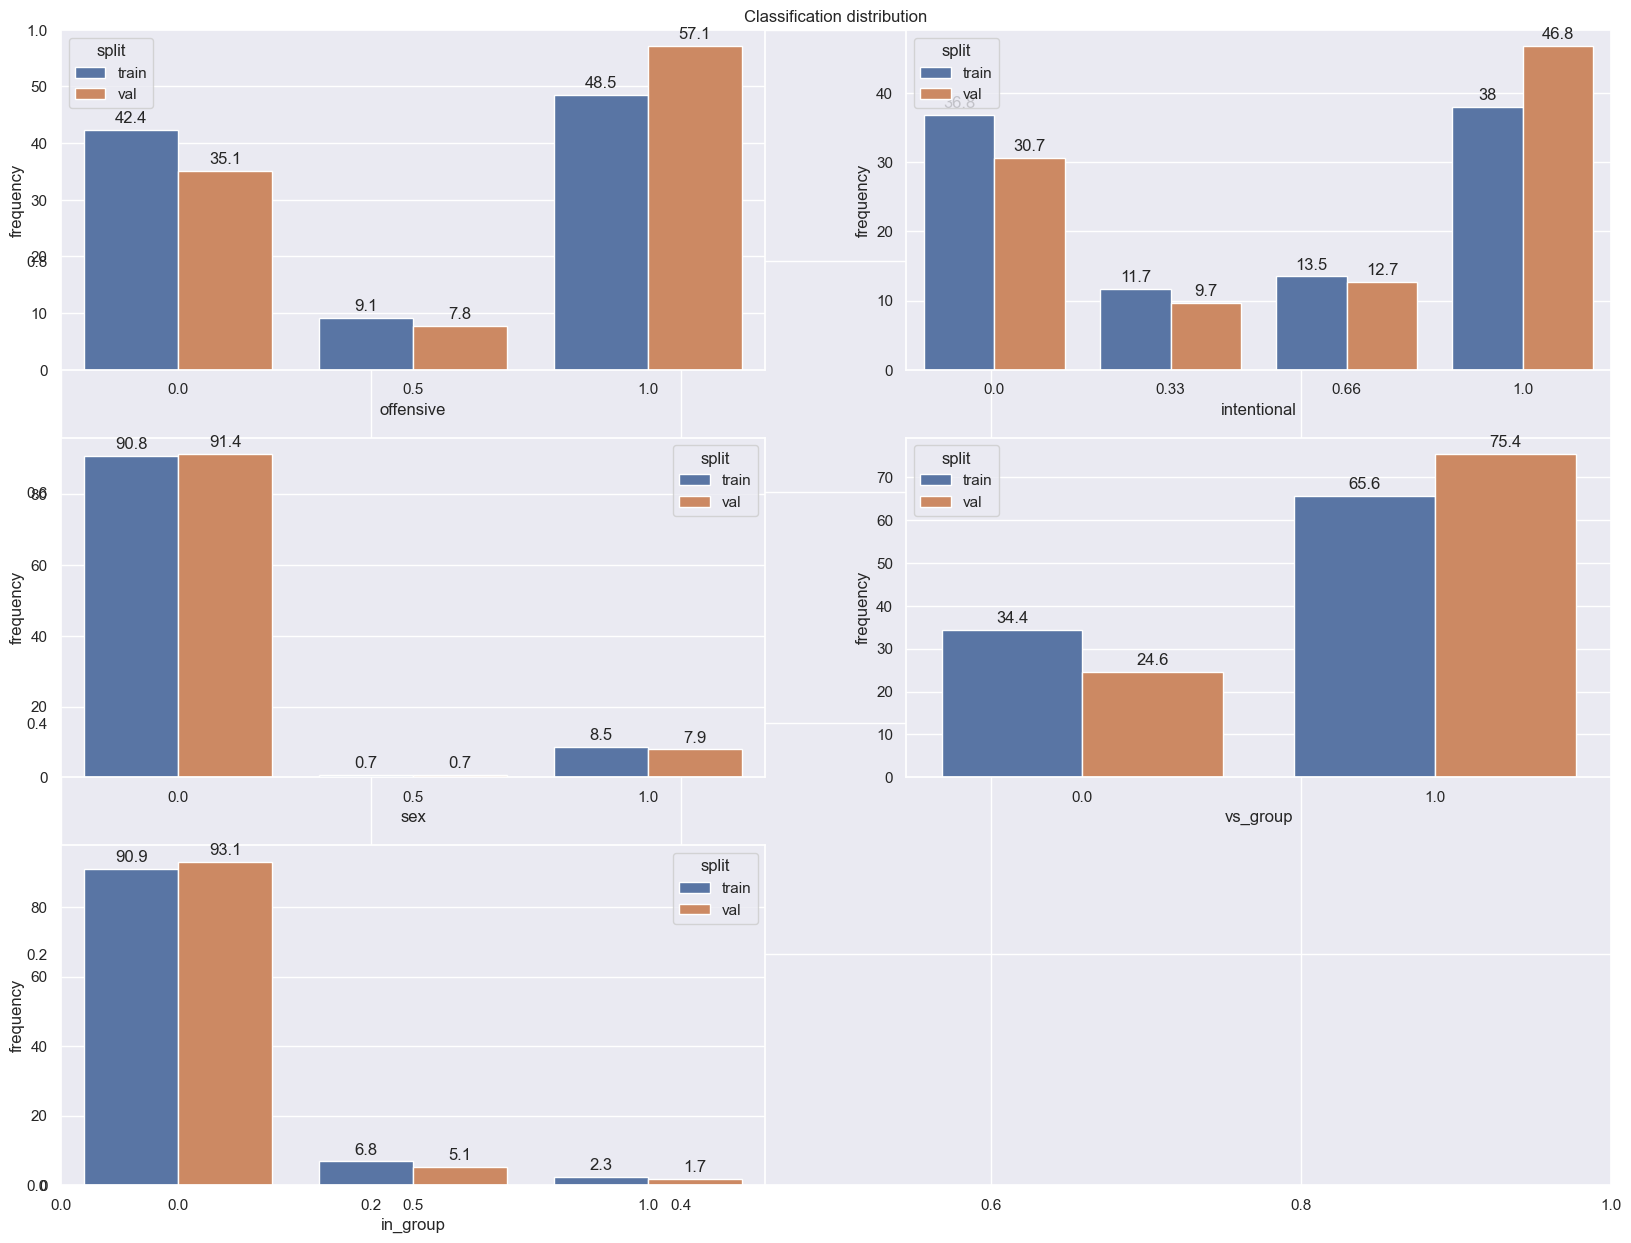

In [ ]:
plot_cls_distribution(
    df,
    cls_cols=config.classification_columns,
    type="bar",
    title="Classification distribution",
)

We apply a binarization to each classification features, in order to obtain a binary task

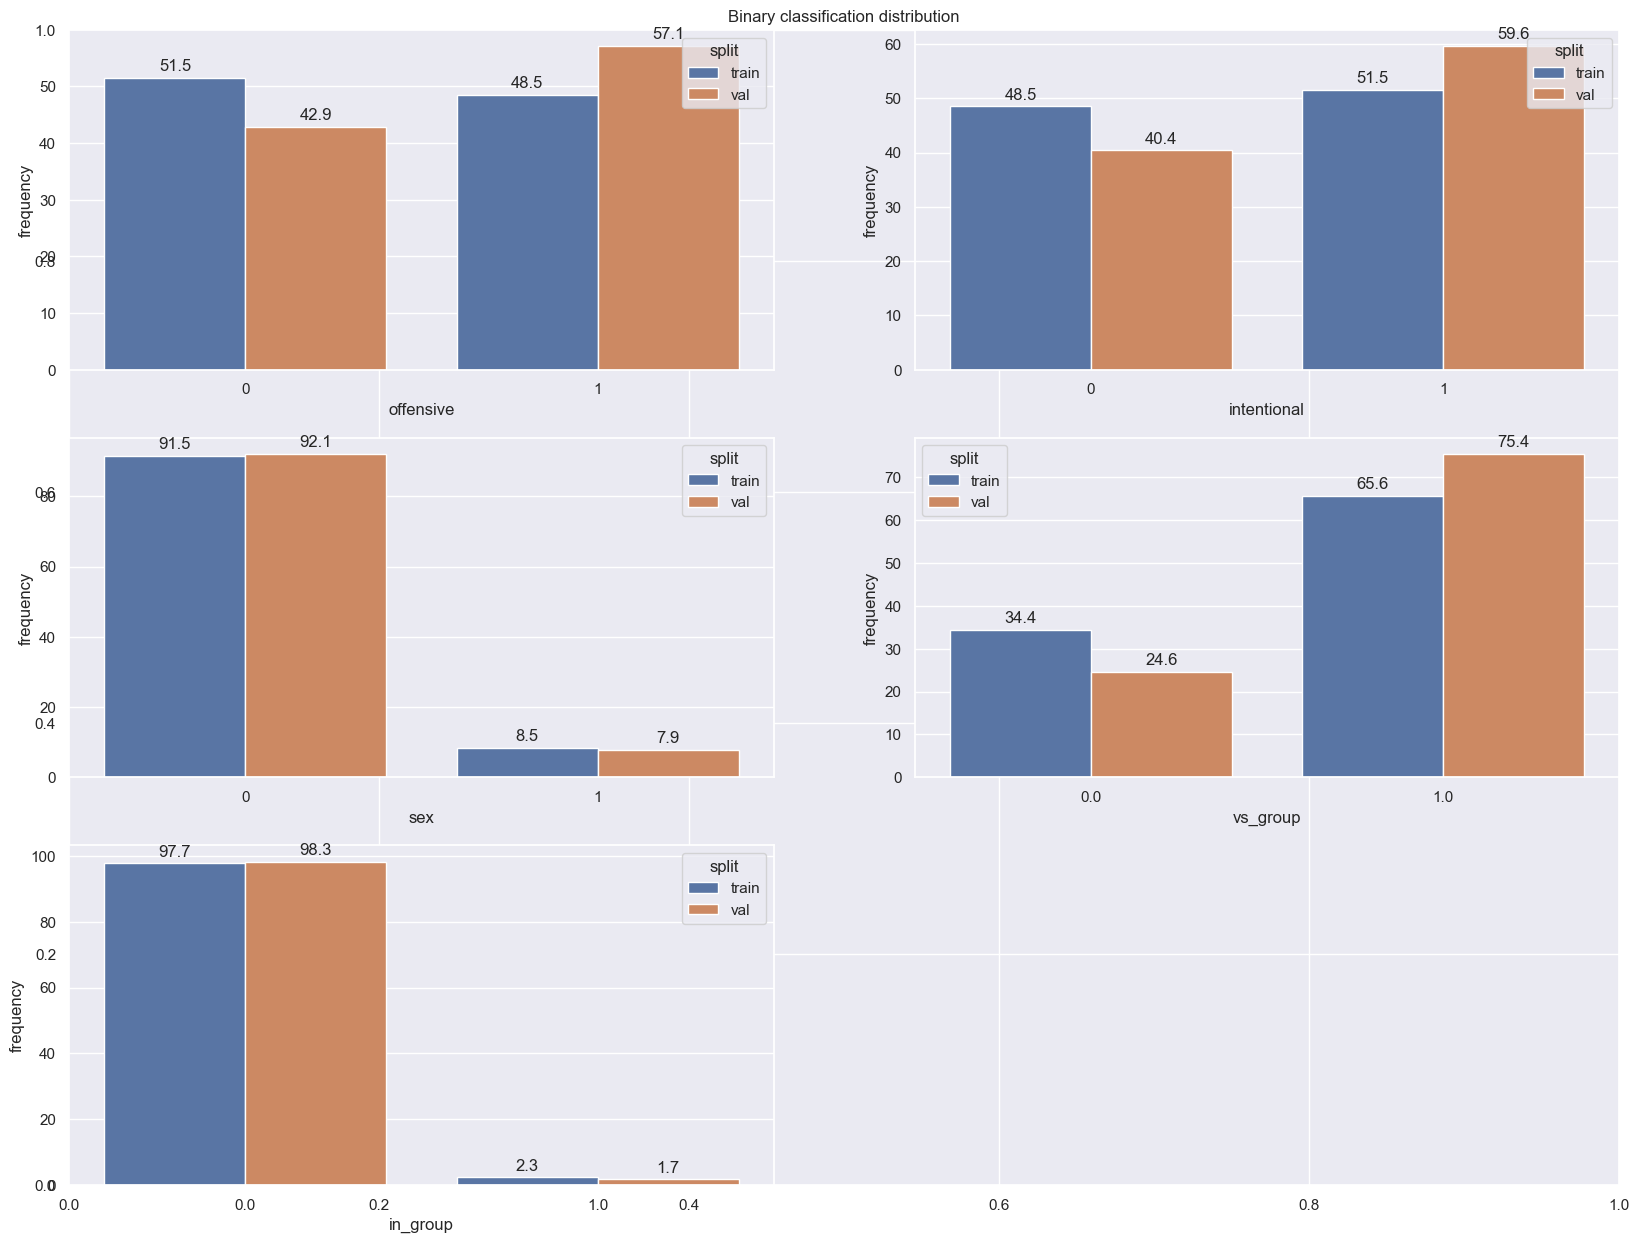

In [ ]:
df_binary = df.copy()
df_binary[list(config.classification_columns)] = df_binary[
    config.classification_columns
].map(binarize)
plot_cls_distribution(
    df_binary,
    cls_cols=config.classification_columns,
    type="bar",
    title="Binary classification distribution",
)

We also plot stereotype + group length statistics, useful to estimate generation lengths. As a rule of thumb, 1 token $\approx$ 0.75 words. Therefore, the max number of (net) generated tokens are $\approx 67$.

      group + stereotype_length                                              
                          count      mean       std  min  25%  50%  75%   max
split                                                                        
test                     8856.0  5.536472  2.214786  1.0  4.0  5.0  6.0  22.0
train                   41578.0  5.532806  2.258313  1.0  4.0  5.0  6.0  33.0
val                      7819.0  5.561837  2.266940  1.0  4.0  5.0  6.0  50.0


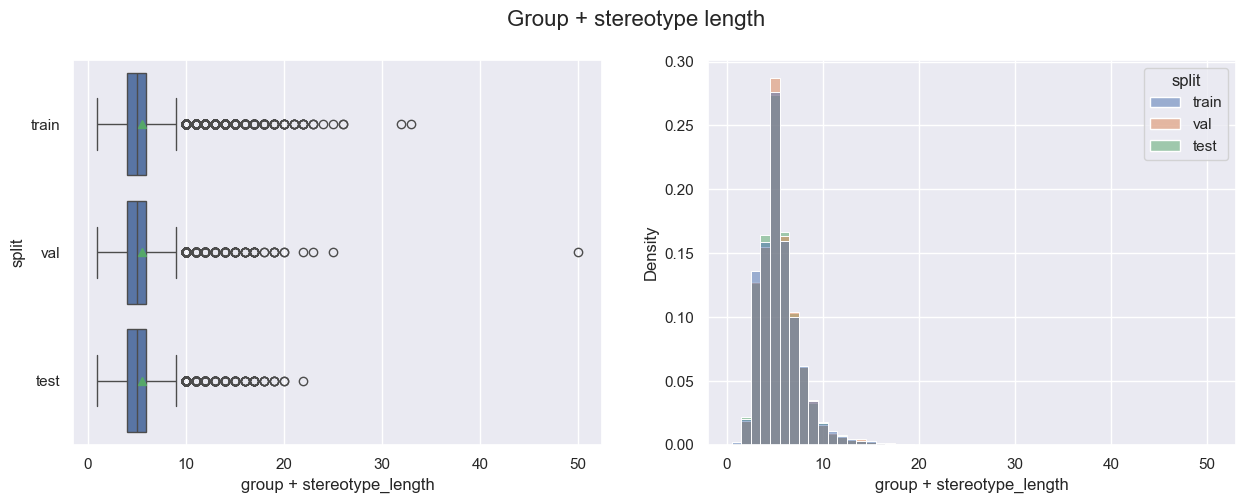

In [ ]:
df = to_pandas(data)
df = df[df["group"].notnull()]
df["group"] = df["group"].apply(", ".join)
df["group + stereotype"] = df["group"] + df["stereotype"]
plot_length(df, "group + stereotype")

## Data Aggregation

Each post has been annotated by several annotators. During inference, we don't want that our model predicts more than one annotation per post. Therefore, we aggregate data in validation and test sets, computing the average of the classification features and the list of unique groups and stereotypes, in order to improve also data quality.

In [ ]:
aggregate_data(config)

Loading processed data ...
Aggregating data ...
Saving data to data/aggregated ...
Complete!


In [ ]:
data = datasets.load_from_disk(config.data.aggregated)
df = to_pandas(data)

In [ ]:
df.sample(10)

post  offensive  \
22732  There is a double entendre competition happeni...   0.500000   
1620   "she wanted to say ""don't leave me"", but she...   0.000000   
28890  Why doesn't Micheal J. Fox own an ice cream sh...   0.666667   
13800  I'm very excited to be back on @FLOSSWeekly ne...   0.000000   
9992   I added a video to a @YouTube playlist Infecte...   0.000000   
40637  Can anyone help, fiancé's S7 suddenly fucked u...   0.000000   
17735  My mate's such a hipster, even when it comes t...   1.000000   
27560  Whats the difference between your meat and you...   1.000000   
34912  why are all black people criminals ? because m...   1.000000   
10510  I don't get what's so hot about British accent...   0.000000   

       intentional       sex  vs_group  in_group            group  \
22732     0.663333  0.333333       0.0       NaN             None   
1620      0.000000  0.000000       NaN       NaN             None   
28890     0.666667  0.000000       0.0       NaN             None   
13800     0.000000  0.000000       NaN       NaN             None   
9992      0.000000  0.000000       NaN       NaN             None   
40637     0.000000  0.000000       NaN       NaN             None   
17735     1.000000  0.000000       1.0       0.0  [muslim people]   
27560     1.000000  1.000000       1.0       0.0          [women]   
34912     1.000000  0.000000       1.0       0.0   [black people]   
10510     0.110000  0.000000       NaN       NaN             None   

                                              stereotype         source  split  
22732                                               None  [r/darkjokes]  train  
1620                                                None     [t/founta]  train  
28890                                               None  [r/meanjokes]  train  
13800                                               None     [t/waseem]  train  
9992                                                None     [t/founta]  train  
40637                                               None     [t/founta]    val  
17735  [muslims are terrorists, muslims deserve the h...  [r/darkjokes]  train  
27560  [deserve to be beaten, deserve to get hurt, wo...  [r/darkjokes]  train  
34912  [calla black people monkeys, infers black peop...  [r/meanjokes]  train  
10510                                               None     [r/Incels]  train

# Model Definition, Train and Evaluation

Our model should handle two type of tasks: a classification task and a text generation task. Here, we want to explore two alternative solutions:
- a decoder-only model (`gpt2`)
- an encoder-decoder model (`bart`)

Both models receive as input a post and produce as output:
- 5 binary labels: `offensive`, `intentional`, `sex`, `vs_group`, `in_group`.
- two free-form texts: `group` and `stereotype`.

## Decoder-only Model

Our approach is highly inspired to the one proposed in the paper of the dataset: First of all, we add two tokens for each label. Then, we binarize the labels and map them to their corresponding token: e.g.
- offensive: 1.0 -> `offY`
- offensive: 0.0 -> `offN`

Input and label strings are built in the following way:
- `input_str`: `[P1]...[Pn]<|sep|>`
- `label_str`: `<|off?|><|int?|><|sex?|><|grp?|><|sep|>[G1]...[Gm]<|sep|>[S1]...[Sl]<|sep|><|ingrp?|>`

where $? \in \{Y, N\}$ and `[Pi]`, `[Gi]`, `[Si]` are the tokens of, respectively, post, group and stereotype.\
At training time, the "input" of our model is obtained by concatenating `input_str` and `label_str` without the last token of the latter.

The `label_str` above is the most general one. There are special cases that need to be handled:
- if `vs_group` is missing, we ignore what the network predict in the corresponding position
- if `group`, `stereotype` and `in_group` are missing, i.e. if `not offensive` or `not vs_group`, our network should predict only the first four classification feature. Therefore, the `label_str` becomes `<|off?|><|int?|><|sex?|><|grp?|>`.

We decide not to teach the network to learn the first sep token in the `label_str`, i.e. the sep just after the four classification tokens, because it is deterministic: it always occurrs at the fifth position.\
In addition, we do not have a eos token, since, again, the generation may be stopped deterministically: after the four classification tokens, if `not offensive` or `not vs_group`, or after `in_group` token.

At training time, we truncate posts only if `input_str` + `label_str` exceeds `max_model_length` (i.e. 1024).\
At inference time, we generate a maximum of 80 new tokens: 67 tokens for groups + stereotypes, 5 tokens for classification features, 3 sep tokens and the remaining ones as margin. Therefore, we truncate posts to `max_model_length` - `max_new_tokens` (i.e. 944).

We decide to use `gpt2` for two reasons:
- it is one of the choice of the dataset's paper. Hence, we may reproduce and (hopefully) improve their results
- it is well documented, easy to use, big enough to accomplish the task, small enough to be trained in a reasonable time and to experiment with on our personal machines.

We initialize the embeddings of the new tokens by sampling from a gaussian distribution with mean and standard deviation equal to the mean and standard deviation of the pretrained embeddings. This improves training stability as the probability of new tokens is similar to the one of the pretrained ones. Indeed, if initialized with a normal distribution, the probability of new tokens is far higher than the one of the pretrained ones [[1]](https://nlp.stanford.edu/~johnhew/vocab-expansion.html).

In [ ]:
config = Config.load_config(model_name="gpt2")
helper = model_helper_factory(Config.to_dict(config))
tokenizer = helper.make_tokenizer()
model = helper.make_model(tokenizer)
print(model)

GPT2SBF(
  (transformer): GPT2Model(
    (wte): Embedding(50269, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50269, bias=False)
)


### Data tokenization

We prepare two datasets:
- one for train, where the input of the model is obtained by concatenating `input_str` and `label_str`.
- one for inference, where the input of the model is given by `input_str`.

In [ ]:
tokenize_data(config, task="train")

Loading processed data ...
Tokenizing data ...
Saving data to data/gpt2/train ...
Complete!


In [ ]:
data = datasets.load_from_disk(config.data.train)
data = data.select_columns(["input_ids", "attention_mask", "labels"])
data = data["train"]
print_tokenized_dataset(data, config)

input_ids: [40, 8072, 3589, 314, 561, 7719, 616, 670, 790, 1110, 428, 285, 77, 400, 13, 314, 1053, 587, 1804, 523, 49822, 306, 13, 2080, 326, 531, 11, 994, 338, 257, 4704, 286, 644, 314, 466, 1343, 670, 50258, 50262, 50260, 50261]
input_ids: I promised myself I would promote my work every day this mnth. I've been doing so slyly. With that said, here's a thread of what I do + work<|sep|><|offN|><|intN|><|sexN|>
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
labels: [50262, 50260, 50261, -100]
labels: <|offN|><|intN|><|sexN|><|pad|>
--------------------------------------------------
input_ids: [13909, 6, 50, 402, 1340, 4535, 30998, 2751, 8410, 7283, 13, 7013, 11096, 360, 2606, 19313, 1961, 11948, 13, 43624, 11401, 13, 1303, 54, 2118, 293, 45733, 50258, 50262, 50260, 50261]
input_ids: HE'S GONNA FUCKING DO IT. YOU ALL DOUBTED ME. HYPE. #Wrestlemania<|sep|><|offN|><|intN|><|sexN|>
attention_mask: [

In [ ]:
tokenize_data(config, task="inference")

Loading processed data ...
Tokenizing data ...
Saving data to data/gpt2/eval ...
Complete!


In [ ]:
data = datasets.load_from_disk(config.data.eval)
data = data.select_columns(["input_ids", "attention_mask", "labels"])
data = data["train"]
print_tokenized_dataset(data, config)

input_ids: [40, 836, 470, 892, 314, 460, 6004, 284, 34362, 11135, 1231, 1972, 257, 1310, 795, 3768, 11, 26414, 3809, 3011, 502, 826, 287, 262, 1254, 89, 50258]
input_ids: I don't think I can listen to arcane roots without getting a little emosh, Andrews voice gets me right in the feelz<|sep|>
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
labels: [50262, 50260, 50261, -100]
labels: <|offN|><|intN|><|sexN|><|pad|>
--------------------------------------------------
input_ids: [40, 1682, 423, 284, 1011, 617, 1099, 6097, 329, 616, 4922, 837, 1867, 705, 82, 9181, 318, 326, 340, 705, 82, 5340, 284, 2190, 477, 661, 8603, 780, 286, 511, 4069, 764, 50258]
input_ids: I actually have to take some law classes for my degree, What's cited is that it's impossible to treat all people equally because of their behavior.<|sep|>
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
labels: [502

Moreover, we prepare the aggregated version of the dataset for evaluation purposes.

In [ ]:
tokenize_data(config, task="inference", use_aggregate=True)

Loading processed data ...
Tokenizing data ...
Saving data to data/gpt2/aggregated_eval ...
Complete!


In [ ]:
data = datasets.load_from_disk(config.data.aggregated_eval)
data = data.select_columns(["input_ids", "attention_mask"])
data = data["train"]
print_tokenized_dataset(data, config)

input_ids: [1722, 2582, 355, 1312, 651, 257, 1310, 23714, 837, 1312, 705, 297, 3785, 503, 703, 284, 10199, 27618, 611, 428, 530, 750, 299, 470, 670, 764, 50258]
input_ids: As soon as i get a little smarter, i 'll figure out how to attach pics if this one didn't work.<|sep|>
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
--------------------------------------------------
input_ids: [15784, 329, 1303, 27461, 82, 1303, 1477, 46973, 393, 1303, 66, 3325, 1299, 6822, 503, 2159, 286, 24507, 82, 379, 3126, 49967, 1164, 5567, 11, 1303, 818, 933, 408, 383, 2258, 338, 749, 13467, 1438, 287, 2344, 78, 986, 50258]
input_ids: Looking for #blinds #shutters or #curtains Check out World of Blinds at 60 Seafield Road, #Inverness The North's most trusted name in windo...<|sep|>
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
------------------------------------------

### Train

Our model is trained with a Cross-Entropy, averaged first on the number of tokens in the sample, then by the number of samples in the batch. To handle the imbalance of the classification labels, we reweight the loss of each classification token by the inverse of the frequency of the corresponding true label, computed by considering only the positive/negative ratio.\
The model is trained with both a plain and a weighted CE and results are compared.

The model is trained for three epochs on kaggle: we upload the source files as dataset and run the code in `notebooks/kaggle.ipynb`. Other hyperparameters are in `config/model/gpt2.yaml`.

Plain Cross-Entropy\
![plain CE gpt2](imgs/train_gpt2-no_weight.png)

Weighted Cross-Entropy\
![weighted CE gpt2](imgs/train_gpt2.png)

Loss curves show same trends: losses are close to zero after 15k iterations and slowly decrease without reaching a plateau nor overfitting. Therefore, more epochs may slightly improve results, at cost of training time.

### Evaluation

We assess and compare performance of our models on the aggregated version of the validation set.

For the classification task, the F1 of the positive class of each feature is considered. For groups and stereotypes, we compute Rouge-l F1, Bleu-2 and WMD

We start by comparing results obtained with the two losses.

In [ ]:
model_name = "gpt2"
config = Config.load_config(model_name=model_name)
evaluator = Evaluator(config)

In [ ]:
def generate_predictions(checkpoint, config):
    checkpoint_name = f"checkpoint_{checkpoint}"
    print("Loading checkpoints", checkpoint_name, "...")
    inference = GPT2Inference(checkpoint_name, config=config)

    print("Loading aggregated data ...")
    data = datasets.load_from_disk(config.data.aggregated_eval)
    data.pop("train", None)

    predictions = inference.generate_predictions(data, verbose=True)

    gc.collect()
    torch.cuda.empty_cache()

    path = os.path.join(config.data.prediction, checkpoint)
    print("Saving data to", path, "...")
    predictions.save_to_disk(path)

In [ ]:
for loss_type in ("", "no_weight"):
    weighted = "" if loss_type == "no_weight" else "Weighted"
    checkpoint = "42" + (f"_no_weight" if loss_type == "no_weight" else "")
    print("-" * 10, weighted, "Cross Entropy", "-" * 10)
    generate_predictions(checkpoint, config=config)
    print("-" * 30)

---------- Weighted Cross Entropy ----------
Loading checkpoints checkpoint_42 ...
Loading aggregated data ...
Generating output tokens ...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
c:\Users\Simone999\AppData\Local\pypoetry\Cache\virtualenvs\social-bias-framework-kAa7lILL-py3.10\lib\site-packages\transformers\generation\utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Decoding predicted tokens into classification features, groups and stereotypes ...
Saving data to data/gpt2/prediction\42 ...
------------------------------
----------  Cross Entropy ----------
Loading checkpoints checkpoint_42_no_weight ...
Loading aggregated data ...
Generating output tokens ...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Decoding predicted tokens into classification features, groups and stereotypes ...
Saving data to data/gpt2/prediction\42_no_weight ...
------------------------------


First of all, we evaluate performance on the classification task.

Weighted CrossEntropy lefts untouched results on classification features that are (almost) equally distributed, while improves results of `in group`. However, it loses some points on lewd.

---------- Weighted Cross Entropy results ----------
Offensive: 0.823
Intentional: 0.830
Sex/Lewd content: 0.583
Group targetted: 0.788
Speaker in group: 0.324


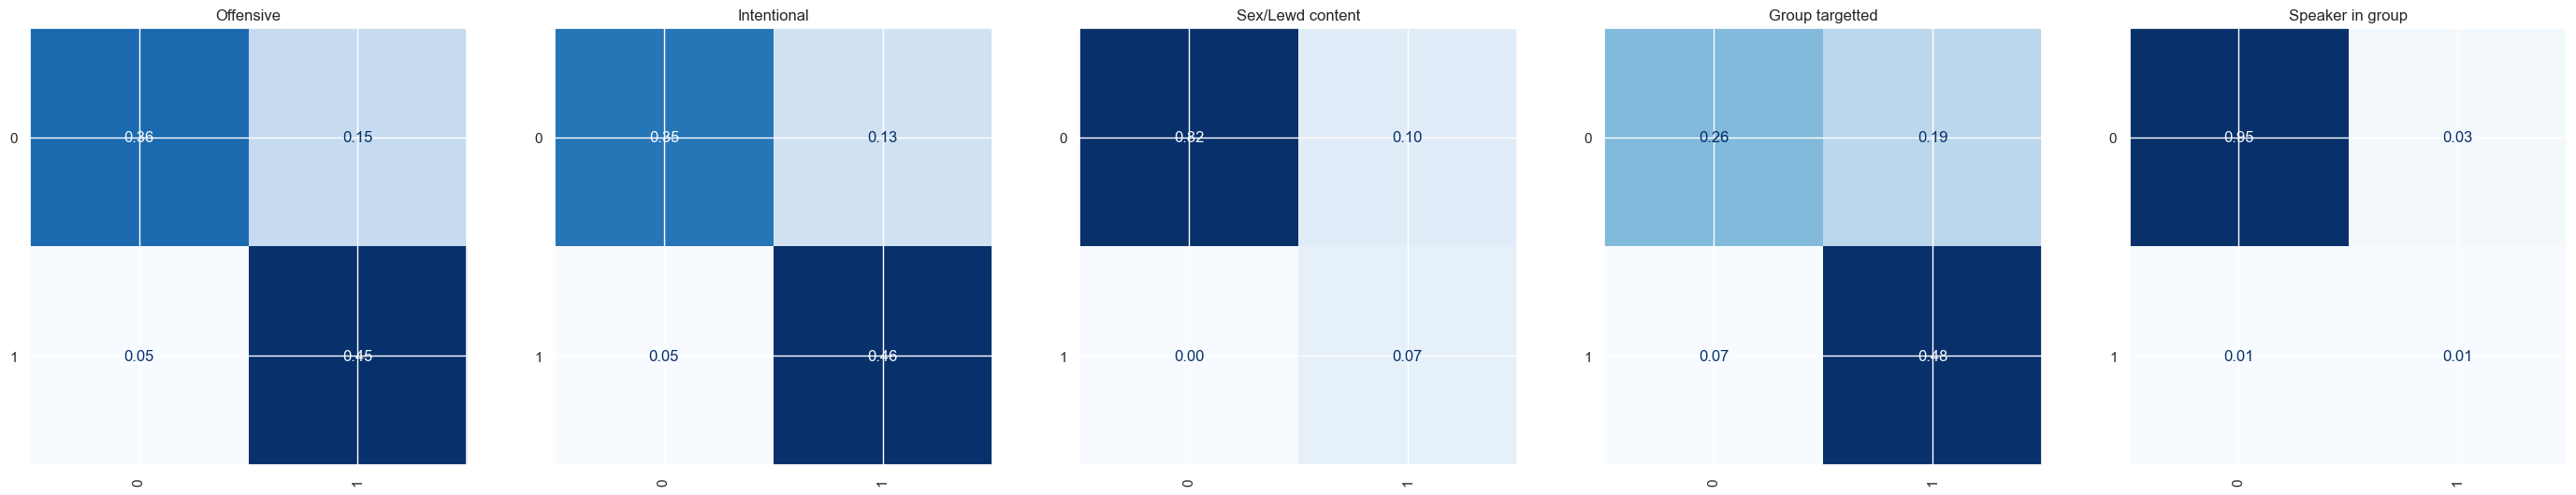

----------  Cross Entropy results ----------
Offensive: 0.824
Intentional: 0.832
Sex/Lewd content: 0.687
Group targetted: 0.785
Speaker in group: 0.095


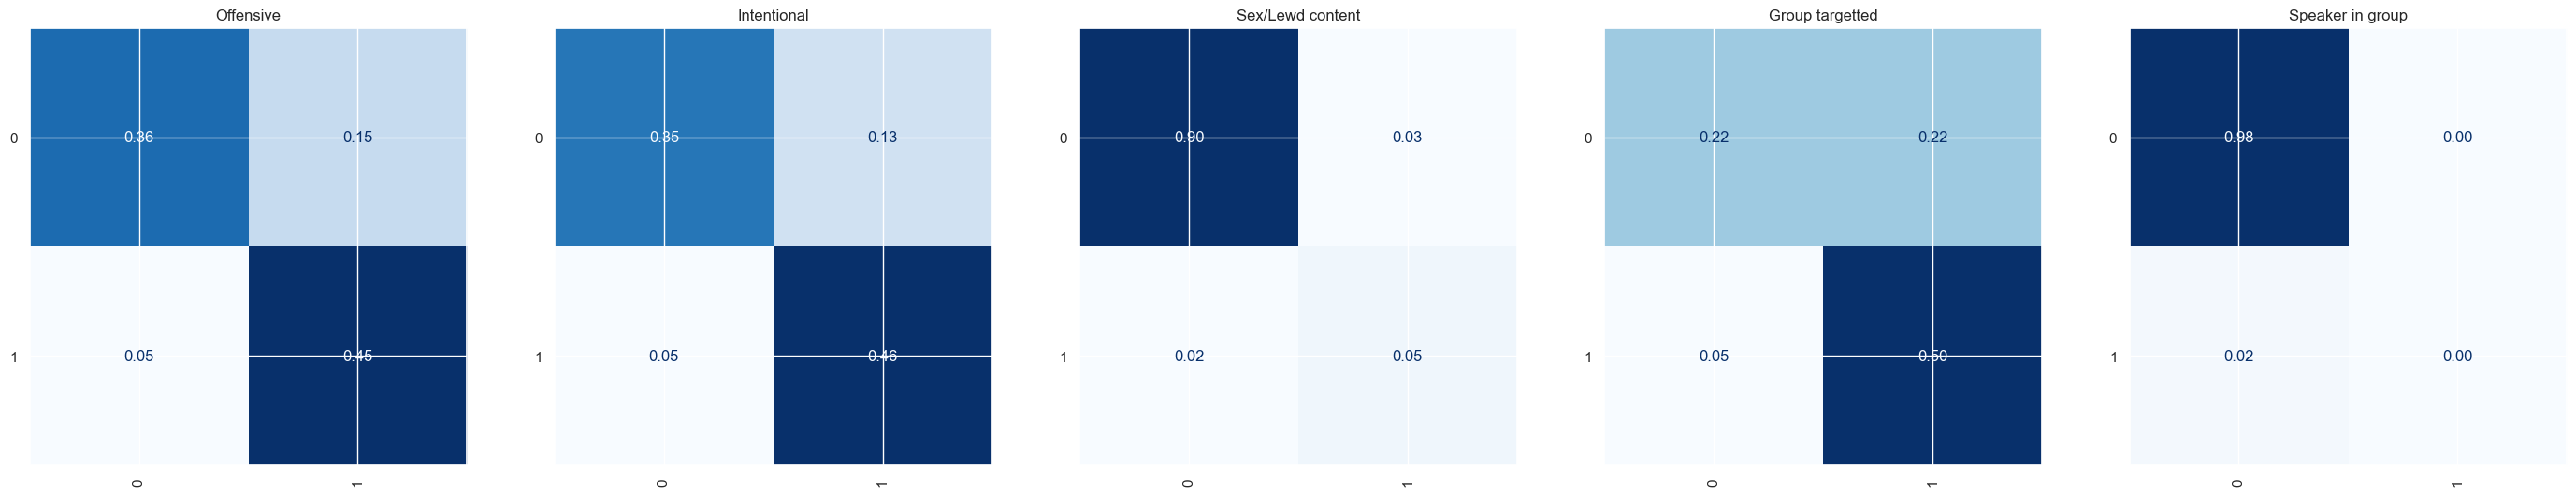

In [ ]:
for loss_type in ("", "no_weight"):
    weighted = "" if loss_type == "no_weight" else "Weighted"
    checkpoint = "42" + (f"_no_weight" if loss_type == "no_weight" else "")
    path = os.path.join(config.data.prediction, checkpoint)

    predictions = datasets.load_from_disk(path)
    predictions = predictions["val"]

    results = evaluate_classification(evaluator, predictions, config=config)
    print("-" * 10, weighted, "Cross Entropy results", "-" * 10)

    show_classification_results(predictions, results, config=config)

Secondly, we evaluate the generative task.

Again, results are quite similar. We take the model trained with weighted loss as the best one, because it is "capable" to predict `in_group`.

In [ ]:
for loss_type in ("", "no_weight"):
    weighted = "" if loss_type == "no_weight" else "Weighted"
    checkpoint = "42" + (f"_no_weight" if loss_type == "no_weight" else "")
    path = os.path.join(config.data.prediction, checkpoint)
    predictions = datasets.load_from_disk(path)
    predictions = predictions.map(evaluator.evaluate_generation)
    predictions.save_to_disk(path)
    predictions = predictions["val"]
    agg_results = evaluator.aggregate_generation_results(
        predictions["group_scores"], predictions["stereotype_scores"]
    )

    print("-" * 10, weighted, "Cross Entropy results", "-" * 10)
    print_generation_results(agg_results)

---------- Weighted Cross Entropy results ----------
Group Rouge score:0.874
Group Bleu score:0.876
Group Wmd score:0.129
Stereotype Rouge score:0.554
Stereotype Bleu score:0.602
Stereotype Wmd score:0.517
----------  Cross Entropy results ----------
Group Rouge score:0.868
Group Bleu score:0.870
Group Wmd score:0.136
Stereotype Rouge score:0.557
Stereotype Bleu score:0.606
Stereotype Wmd score:0.512


To be sure that model capabilities are not dependant by random factors, we initialized and trained the models using three seed values. We show results on the best selected model.

In [ ]:
for seed in SEEDS:
    print("-" * 10, "seed", seed, "-" * 10)
    generate_predictions(str(seed), config=config)
    print("-" * 30)

print("Complete!")

---------- seed 42 ----------
Loading checkpoints checkpoint_42 ...
Loading aggregated data ...
Generating output tokens ...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
c:\Users\Simone999\AppData\Local\pypoetry\Cache\virtualenvs\social-bias-framework-kAa7lILL-py3.10\lib\site-packages\transformers\generation\utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Decoding predicted tokens into classification features, groups and stereotypes ...
Saving data to data/gpt2/prediction\42 ...
------------------------------
---------- seed 1234 ----------
Loading checkpoints checkpoint_1234 ...
Loading aggregated data ...
Generating output tokens ...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Decoding predicted tokens into classification features, groups and stereotypes ...
Saving data to data/gpt2/prediction\1234 ...
------------------------------
---------- seed 2023 ----------
Loading checkpoints checkpoint_2023 ...
Loading aggregated data ...
Generating output tokens ...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Decoding predicted tokens into classification features, groups and stereotypes ...
Saving data to data/gpt2/prediction\2023 ...
------------------------------
Complete!


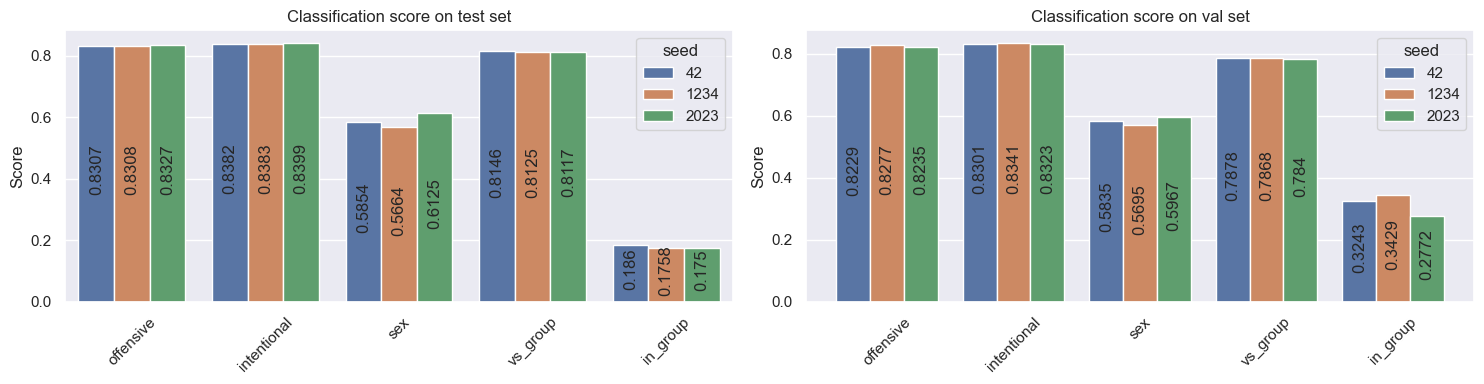

In [ ]:
predictions = load_per_seed_predictions(SEEDS, config)
results = evaluator.evaluate_per_seed_classification(predictions)
plot_classification_results(results)

Results are quite similar. Hence, random factors have almost no impact on model capabilities. Also, a competition between `lewd` and `in_group` is confirmed. We guess that longer training or higher model capacity is likely to reduce the trade-off.

Moreover, results on validation set are compatible with the ones on test set, with the only exception of `in_group`. Therefore, our model seems to generalize well.

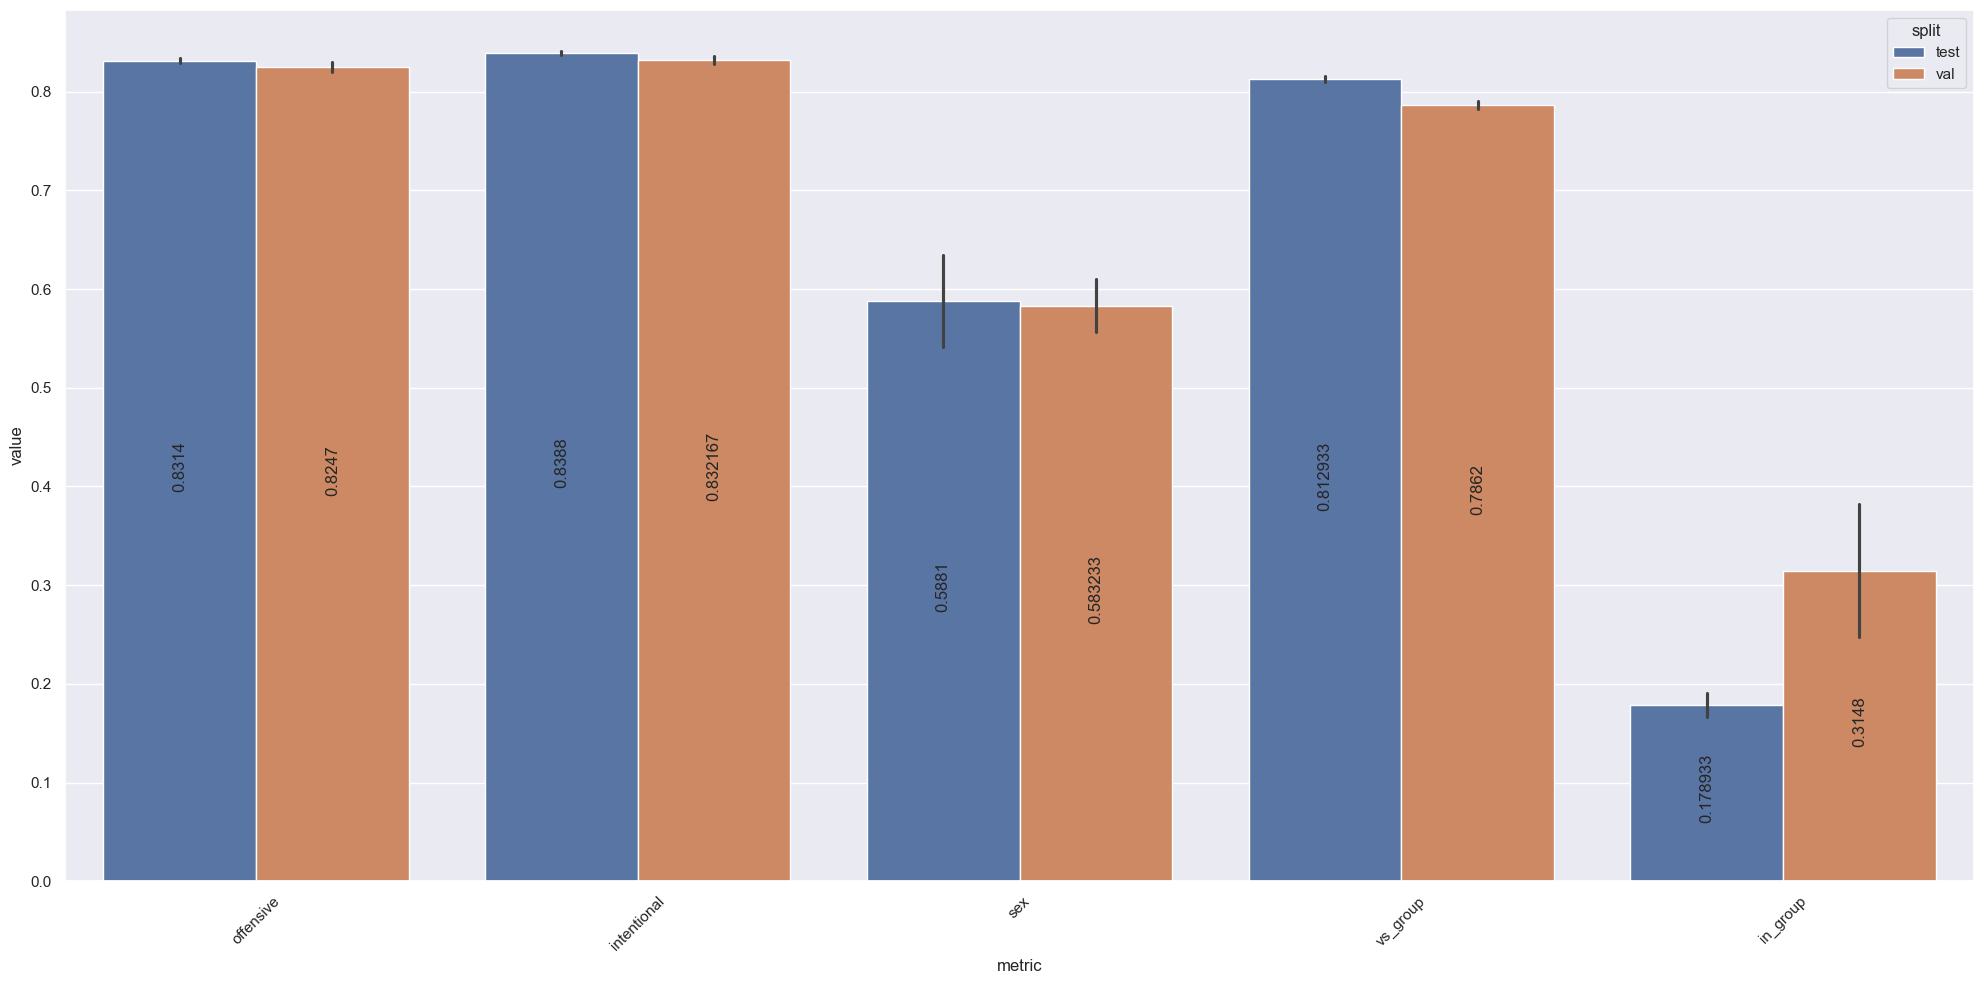

In [ ]:
# Aggregated view: average and std over seeds
plot_metrics_bar(results, multiple_seeds=True)

Analagous consideration can be made on the generative performances. At first sight it seems that performance on group predictions are worse on test set than on validation set. However, we have to remember that group labels have been pre-processed on the val set but not on the test.  

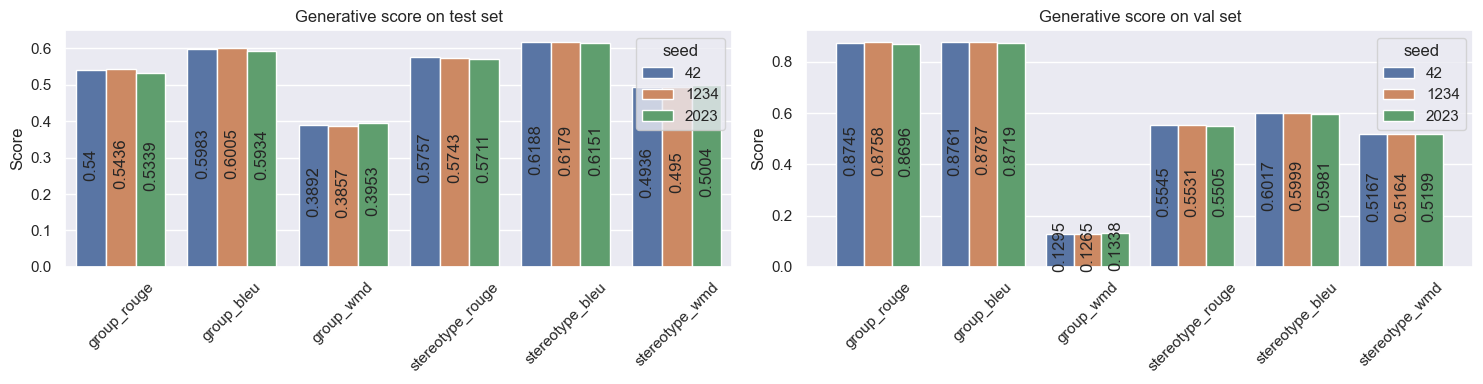

In [ ]:
results = evaluator.evaluate_per_seed_generation(predictions)
plot_generative_results(results)

The following plot shows the aggregated results on both the datasets.

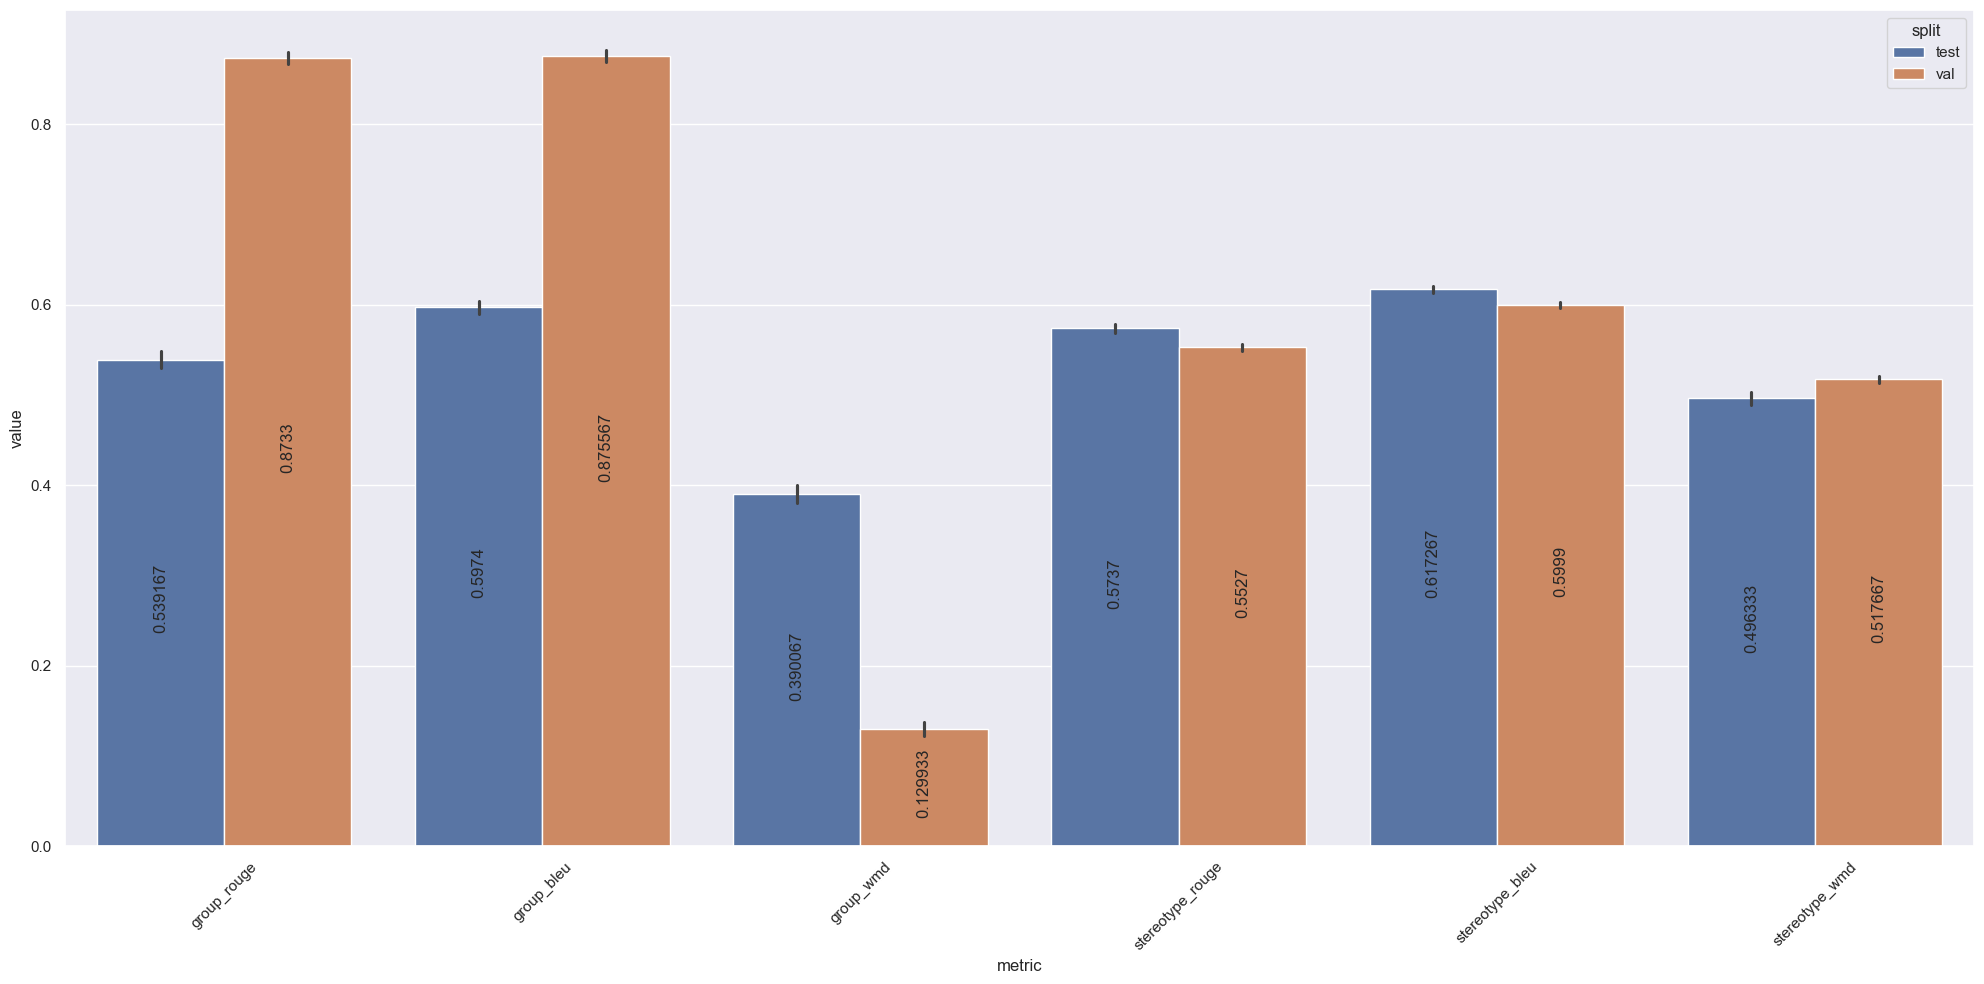

In [ ]:
plot_metrics_bar(results, multiple_seeds=True)

## Encoder-decoder model

Both the problems of the decoder-only architecture are solved by an encoder-decoder architecture with a classification head. In particular, we have:
- an MLP network (`classification_head`) that takes as input the average of the encoder last hidden states and produces five different logits for the classification sub-task
- the decoder that produces group and stereotype

Input and label strings are built in the following way:
- `input_str`: `[P1]...[Pn]`
- `label_str`: `<s>[G1]...[Gm]<s>[S1]...[Sl]</s>`

`[Pi]`, `[Gi]`, `[Si]` are the tokens of, respectively, post, group and stereotype.\
At training time, the "input" of the decoder is obtained from `label_str` by removing the ending `</s>`, while the labels by removing the starting `<s>`.\
At inference time, the input of the decoder is just the `bos` token `<s>`.

We do not binarize classification features, since we want our network to learn from uncertainty. The classification labels are in the following order:
- `cls_labels`: `[offensive, intentional, sex, vs_group, in_group]`.

Special cases:
- If `vs_group` or `in_group` are missing, we ignore the corresponing predicted output.
- If `group` and `stereotype` are missing, we set the input of the decoder as `<s>` and ignore the corresponding output.

We decide to use `bart-base` as the encoder-decoder backbone, since it is well-documented, its pretrain seems compatible with our generative task and the number of parameters is compatible with the `gpt2` one.

Biases of the last layer of the classification head are initialized by using the frequency of each positive class according to formula  $-log(\frac{1-freq}{freq})$. This reduces number of iterations needed at the beginning of the training.

In [ ]:
model_name = "bart"
config = Config.load_config(model_name=model_name)
helper = model_helper_factory(Config.to_dict(config))
tokenizer = helper.make_tokenizer()
model = helper.make_model(tokenizer)
print(model)

Some weights of BartSBF were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.dense.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BartSBF(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwis

### Data tokenization

We use only one dataset both for train and inference: at inference time, we ignore `decoder_input_ids` and `decoder_attention_mask`, since we just pass the `bos` token to the decoder as starting token.

In [ ]:
tokenize_data(config, task="train")

Loading processed data ...
Tokenizing data ...
Saving data to data/bart/train ...
Complete!


In [ ]:
data = datasets.load_from_disk(config.data.train)
data = data.select_columns(
    [
        "input_ids",
        "attention_mask",
        "labels",
        "decoder_input_ids",
        "decoder_attention_mask",
        "cls_labels",
    ]
)
data = data["train"]
print_tokenized_dataset(data, config)

input_ids: [10975, 1000, 12, 7049, 1589, 338, 73, 33895, 47758, 742, 646, 41877, 100, 18024, 742, 4011, 9, 6844, 54, 32, 1680, 9, 1363, 73, 41359, 2134, 31, 49, 20035, 73, 22943, 29, 6, 99, 34, 110, 676, 2609, 244, 57, 101, 116]
input_ids: [X-post /r/AskReddit] [SERIOUS] Men of Reddit who are victims of sexual/physical abuse from their wives/girlfriends, what has your experience finding help been like?
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
labels: [-100]
labels: <pad>
decoder_input_ids: [0]
decoder_input_ids: <s>
decoder_attention_mask: [0]
cls_labels: [0.0, 0.0, 0.0, -100.0, -100.0]
--------------------------------------------------
input_ids: [28081, 330, 141, 7, 386, 42, 15019, 89, 32, 98, 171, 383, 38, 236, 7, 224, 53, 38, 581, 95, 489, 24, 765, 1303, 114, 38, 218, 75, 29831, 298, 1193, 29, 493, 1722, 30722]
input_ids: Idk how to start this thread there are so many things I want

And here, we prepare the aggregated version of the dataset for evaluation purposes.

In [ ]:
tokenize_data(config, task="inference", use_aggregate=True)

Loading processed data ...
Tokenizing data ...
Saving data to data/bart/aggregated_eval ...
Complete!


In [ ]:
data = datasets.load_from_disk(config.data.aggregated_eval)
data = data.select_columns(["input_ids", "attention_mask"])
data = data["train"]
print_tokenized_dataset(data, config)

input_ids: [387, 15093, 40, 28, 2786, 4]
input_ids: Boys will be boys.
attention_mask: [1, 1, 1, 1, 1, 1]
--------------------------------------------------
input_ids: [40900, 1371, 21, 3051, 11, 5, 42639, 178, 21320, 2115, 10, 650, 4607, 6, 16423, 553, 5, 4607, 35, 22, 9178, 793, 32, 47, 1917, 20, 4607, 6849, 35, 22, 100, 437, 818, 290, 2901, 22, 36542, 757, 5580, 113, 26, 16423, 8, 3203, 409]
input_ids: Hitler was walking in the ghetto And stumbled upon a small kid, Hitler asked the kid: "how old are you?" The kid replied: "I'm almost 8!" "Optimistic" said Hitler and walked away
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
--------------------------------------------------
input_ids: [13368, 2138, 222, 38, 1451, 47, 7, 727, 46116, 6319, 10, 205, 183, 313, 787, 45418, 1672]
input_ids: Hey brother did I beat you to 100 haha Have a good day man @Shadowless
attention_mask: [1, 1, 1,

### Train

The total loss is given by the sum of `generative_loss` and `classification_loss`:
- generative loss is a cross-entropy, averaged on tokens and number of (generative) samples.
- classification loss is a KL divergence.
Morover, we experiment with a weighted BCE as classification loss.

In order to make results comparable, models are trained for three epochs on kaggle. Hyperparameters are in `config/model/bart.yaml`.

generative_loss: CE, classification_loss: BCE\
![bart-BCE](imgs/train_bart-bce.png)

generative_loss: CE, classification_loss: KLDiv\
![bart-kldiv](imgs/train_bart-kldiv.png)

By looking at the loss curves of the model trained with BCE, we see that classification loss reaches a plateau, while generative loss may benefit from longer training.

On contrary, loss curves of model trained with KLD show a plateau in the generative loss, but not in the classification loss. However, it is very noisy.

Both the training does not show any sign of overfitting. Longer training may improve performances, but we guess that we will see an improvement of one of the two tasks with a degradation of the performance of the other one.

### Evaluation

Here, we compare results obtained with the two losses to choose the best checkpoint.\
First of all, we tune five different thresholds to binarize the classification probabilities. Then, we generate predictions using the thresholds found.

In [ ]:
model_name = "bart"
config = Config.load_config(model_name=model_name)
evaluator = Evaluator(config)

In [ ]:
def tune_threshold_and_generate_predictions(checkpoint, config):
    checkpoint_name = f"checkpoint_{checkpoint}"
    print("Loading checkpoints", checkpoint_name, "...")
    inference = BartInference(checkpoint_name, config=config)

    print("Loading aggregated data ...")
    data = datasets.load_from_disk(config.data.aggregated_eval)
    data.pop("train", None)
    eval_data = data["val"]

    inference.prepare_model()

    print("Predicting classification features ...")
    eval_data = eval_data.map(
        inference.predict_cls_features,
        batched=True,
        batch_size=config.model.generate_batch_size,
    )

    gc.collect()
    torch.cuda.empty_cache()

    tune_data = eval_data.select_columns(
        config.classification_columns + ["cls_logits"]
    )[:]
    threshold = tune_cls_thresholds(tune_data, config)

    print("Thresholds:")
    for cls, th in threshold.items():
        print(cls, ":", th)

    cls_thresholds = np.asarray(
        [threshold[cls] for cls in config.classification_columns]
    )
    predictions = inference.generate_predictions(
        data, cls_threshold=cls_thresholds, verbose=True
    )

    gc.collect()
    torch.cuda.empty_cache()

    path = os.path.join(config.data.prediction, checkpoint)
    print("Saving data to", path, "...")
    predictions.save_to_disk(path)

In [ ]:
for loss_type in ("kldiv", "bce"):
    print("-" * 10, loss_type, "-" * 10)
    tune_threshold_and_generate_predictions(loss_type, config=config)
    print("-" * 30)

---------- kldiv ----------
Loading checkpoints checkpoint_kldiv ...


Some weights of BartSBF were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.out_proj.bias', 'classification_head.out_proj.weight', 'classification_head.dense.weight', 'classification_head.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading aggregated data ...
Predicting classification features ...


You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Thresholds:
offensive : 0.56
intentional : 0.43
sex : 0.49
vs_group : 0.59
in_group : 0.39
Predicting classification features ...
Binarizing classification features ...
Generating groups and stereotypes ...


c:\Users\Simone999\AppData\Local\pypoetry\Cache\virtualenvs\social-bias-framework-kAa7lILL-py3.10\lib\site-packages\transformers\generation\utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Decoding generated tokens ...
Saving data to data/bart/prediction\kldiv ...
------------------------------
---------- bce ----------
Loading checkpoints checkpoint_bce ...


Some weights of BartSBF were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.out_proj.bias', 'classification_head.out_proj.weight', 'classification_head.dense.weight', 'classification_head.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading aggregated data ...
Predicting classification features ...


You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Thresholds:
offensive : 0.42
intentional : 0.44
sex : 0.9
vs_group : 0.44
in_group : 0.79
Predicting classification features ...
Binarizing classification features ...
Generating groups and stereotypes ...


c:\Users\Simone999\AppData\Local\pypoetry\Cache\virtualenvs\social-bias-framework-kAa7lILL-py3.10\lib\site-packages\transformers\generation\utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Decoding generated tokens ...
Saving data to data/bart/prediction\bce ...
------------------------------


Classification results are comparable: we trade performance on `lewd` with performance on `in group`. However, it is interesting to note that thresholds on the kldiv model are around 0.5, while the ones on bce model are not. This may suggest that kldiv is less affected by imbalance.

---------- kldiv results ----------
Offensive: 0.845
Intentional: 0.847
Sex/Lewd content: 0.743
Group targetted: 0.836
Speaker in group: 0.347


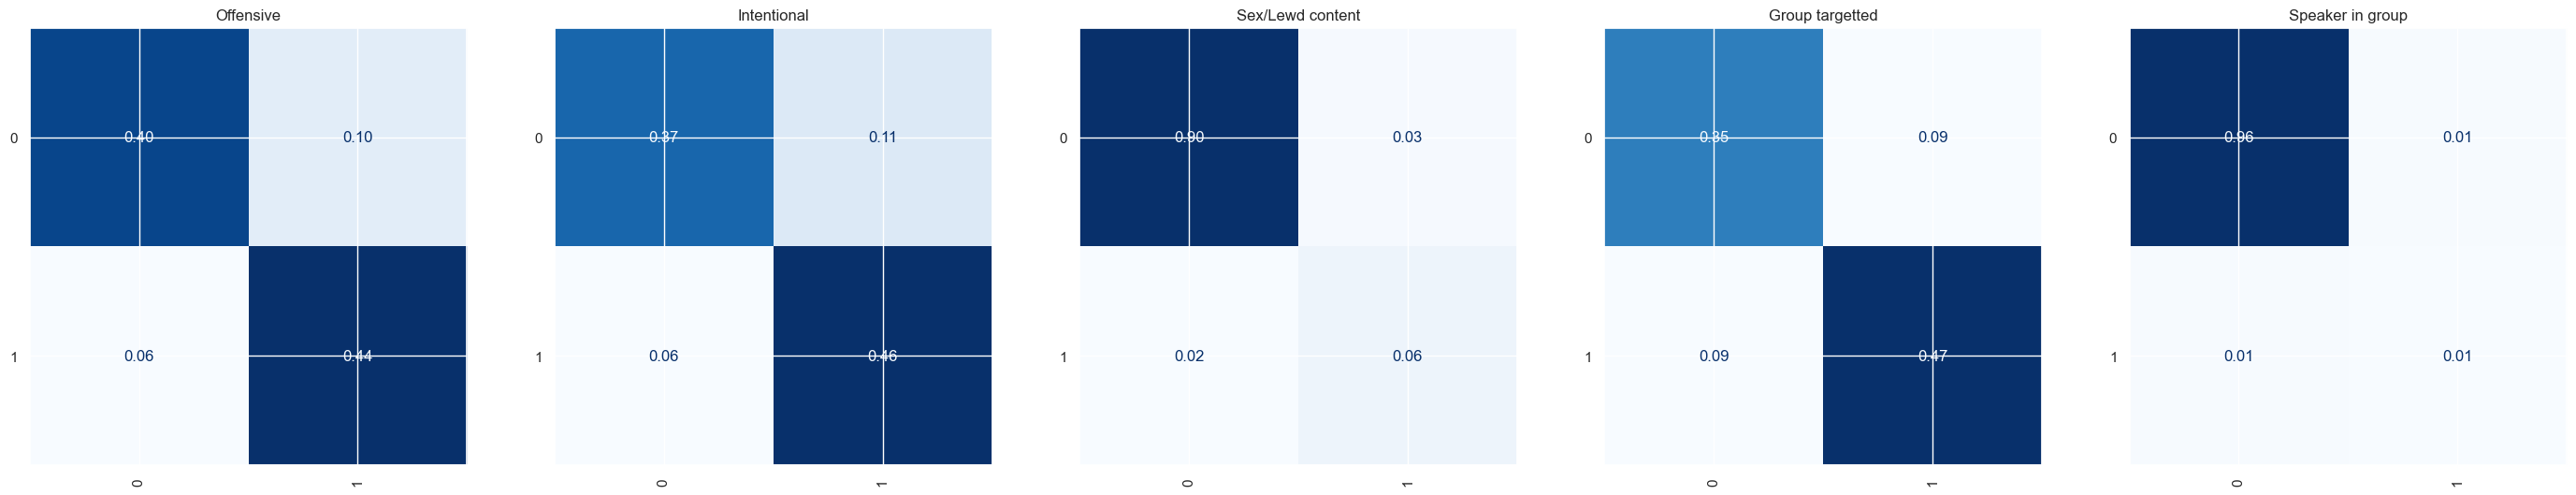

---------- bce results ----------
Offensive: 0.845
Intentional: 0.849
Sex/Lewd content: 0.731
Group targetted: 0.832
Speaker in group: 0.370


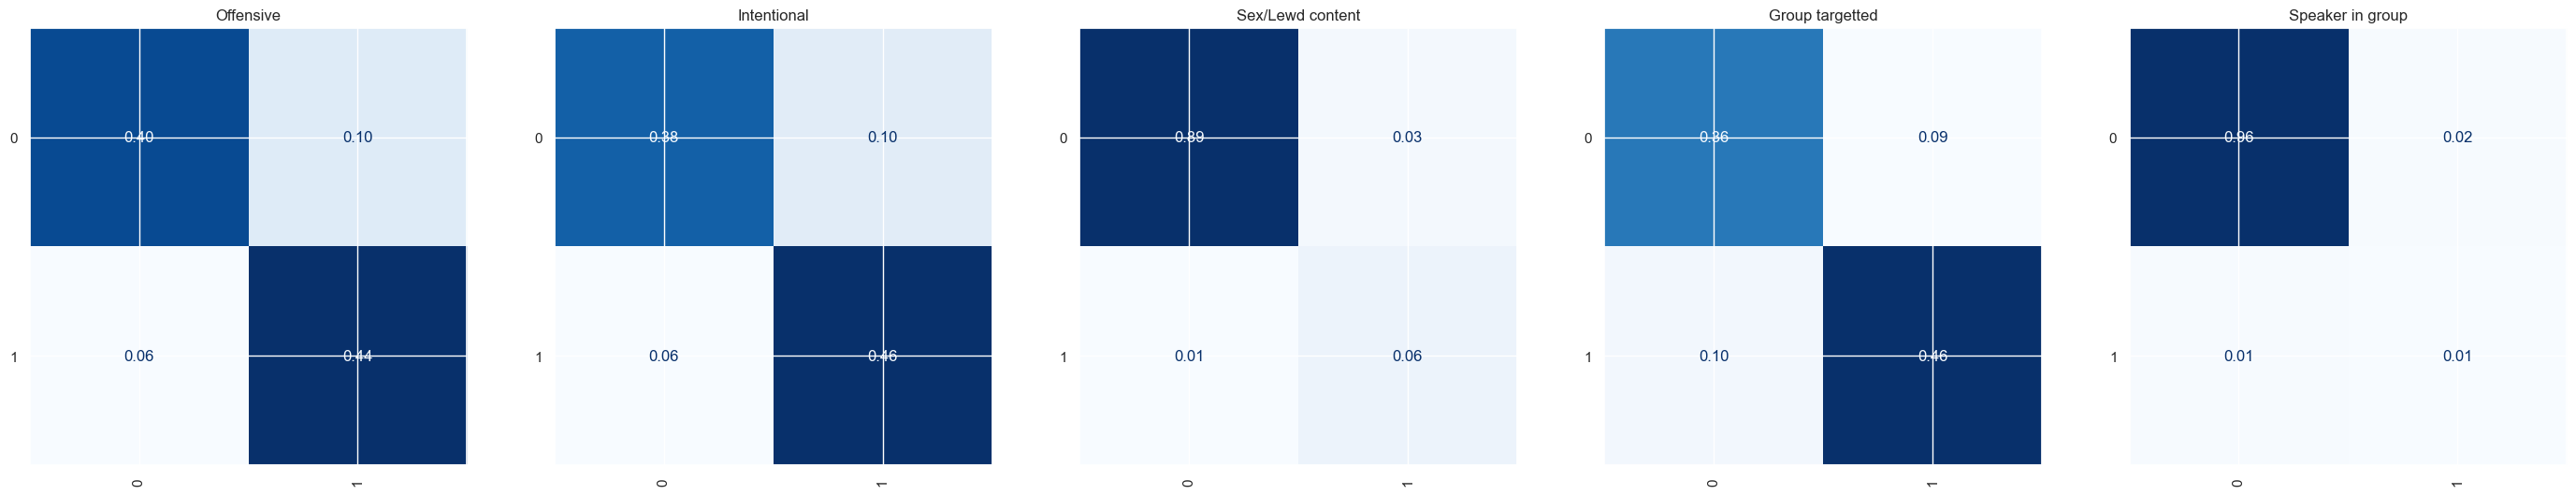

In [ ]:
for loss_type in ("kldiv", "bce"):
    path = os.path.join(config.data.prediction, loss_type)

    predictions = datasets.load_from_disk(path)
    predictions = predictions["val"]

    results = evaluate_classification(evaluator, predictions, config=config)
    print("-" * 10, loss_type, "results", "-" * 10)

    show_classification_results(predictions, results, config=config)

On the generative task, kldiv model performs slightly better on all metrics. Therefore, we take it as the best one.

In [ ]:
for loss_type in ("kldiv", "bce"):
    path = os.path.join(config.data.prediction, loss_type)
    predictions = datasets.load_from_disk(path)
    predictions = predictions.map(evaluator.evaluate_generation)
    predictions.save_to_disk(path)
    predictions = predictions["val"]
    agg_results = evaluator.aggregate_generation_results(
        predictions["group_scores"], predictions["stereotype_scores"]
    )

    print("-" * 10, loss_type, "results", "-" * 10)
    print_generation_results(agg_results)

---------- kldiv results ----------
Group Rouge score:0.894
Group Bleu score:0.895
Group Wmd score:0.107
Stereotype Rouge score:0.526
Stereotype Bleu score:0.591
Stereotype Wmd score:0.536
---------- bce results ----------
Group Rouge score:0.884
Group Bleu score:0.886
Group Wmd score:0.118
Stereotype Rouge score:0.521
Stereotype Bleu score:0.585
Stereotype Wmd score:0.543


Let's compare the results on the three seeds.

In [ ]:
for seed in SEEDS:
    print("-" * 10, "seed", seed, "-" * 10)
    tune_threshold_and_generate_predictions(str(seed), config=config)
    print("-" * 30)

print("Complete!")

---------- seed 42 ----------
Loading checkpoints checkpoint_42 ...


Some weights of BartSBF were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading aggregated data ...
Predicting classification features ...


You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Thresholds:
offensive : 0.56
intentional : 0.43
sex : 0.49
vs_group : 0.59
in_group : 0.39
Predicting classification features ...
Binarizing classification features ...
Generating groups and stereotypes ...


c:\Users\Simone999\AppData\Local\pypoetry\Cache\virtualenvs\social-bias-framework-kAa7lILL-py3.10\lib\site-packages\transformers\generation\utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Decoding generated tokens ...
Saving data to data/bart/prediction\42 ...
------------------------------
---------- seed 1234 ----------
Loading checkpoints checkpoint_1234 ...


Some weights of BartSBF were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading aggregated data ...
Predicting classification features ...


You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Thresholds:
offensive : 0.49
intentional : 0.4
sex : 0.46
vs_group : 0.37
in_group : 0.39
Predicting classification features ...
Binarizing classification features ...
Generating groups and stereotypes ...


c:\Users\Simone999\AppData\Local\pypoetry\Cache\virtualenvs\social-bias-framework-kAa7lILL-py3.10\lib\site-packages\transformers\generation\utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Decoding generated tokens ...
Saving data to data/bart/prediction\1234 ...
------------------------------
---------- seed 2023 ----------
Loading checkpoints checkpoint_2023 ...


Some weights of BartSBF were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading aggregated data ...
Predicting classification features ...


You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Thresholds:
offensive : 0.53
intentional : 0.46
sex : 0.59
vs_group : 0.44
in_group : 0.28
Predicting classification features ...
Binarizing classification features ...
Generating groups and stereotypes ...


c:\Users\Simone999\AppData\Local\pypoetry\Cache\virtualenvs\social-bias-framework-kAa7lILL-py3.10\lib\site-packages\transformers\generation\utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Decoding generated tokens ...
Saving data to data/bart/prediction\2023 ...
------------------------------
Complete!


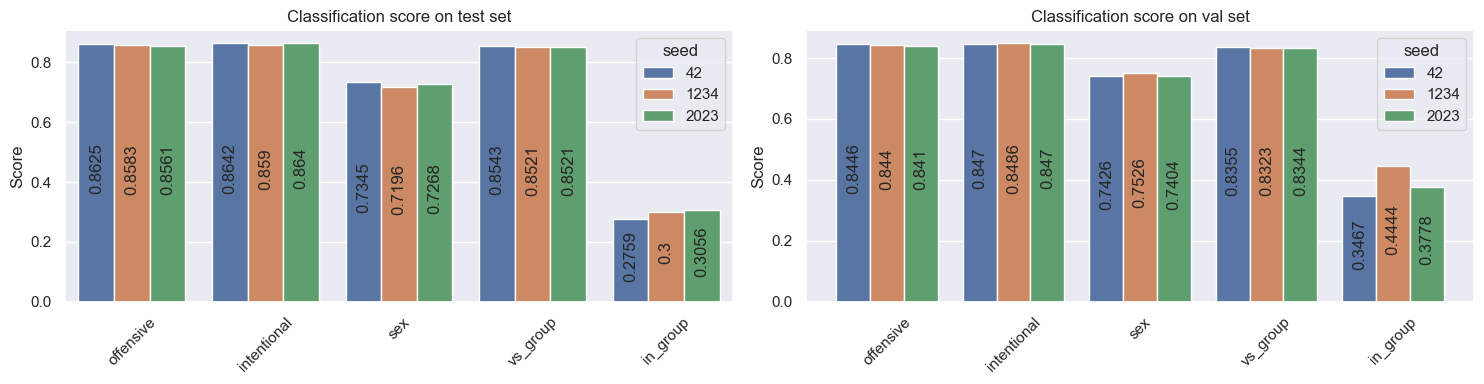

In [ ]:
predictions = load_per_seed_predictions(SEEDS, config)
results = evaluator.evaluate_per_seed_classification(predictions)
plot_classification_results(results)

Results on the classification task are similar across seeds and generalize well to test set. On very imbalanced features (i.e. `sex` and `in_group`), performance on test set are a bit worse. We think that the effect of threshold is higher on more imbalanced features.

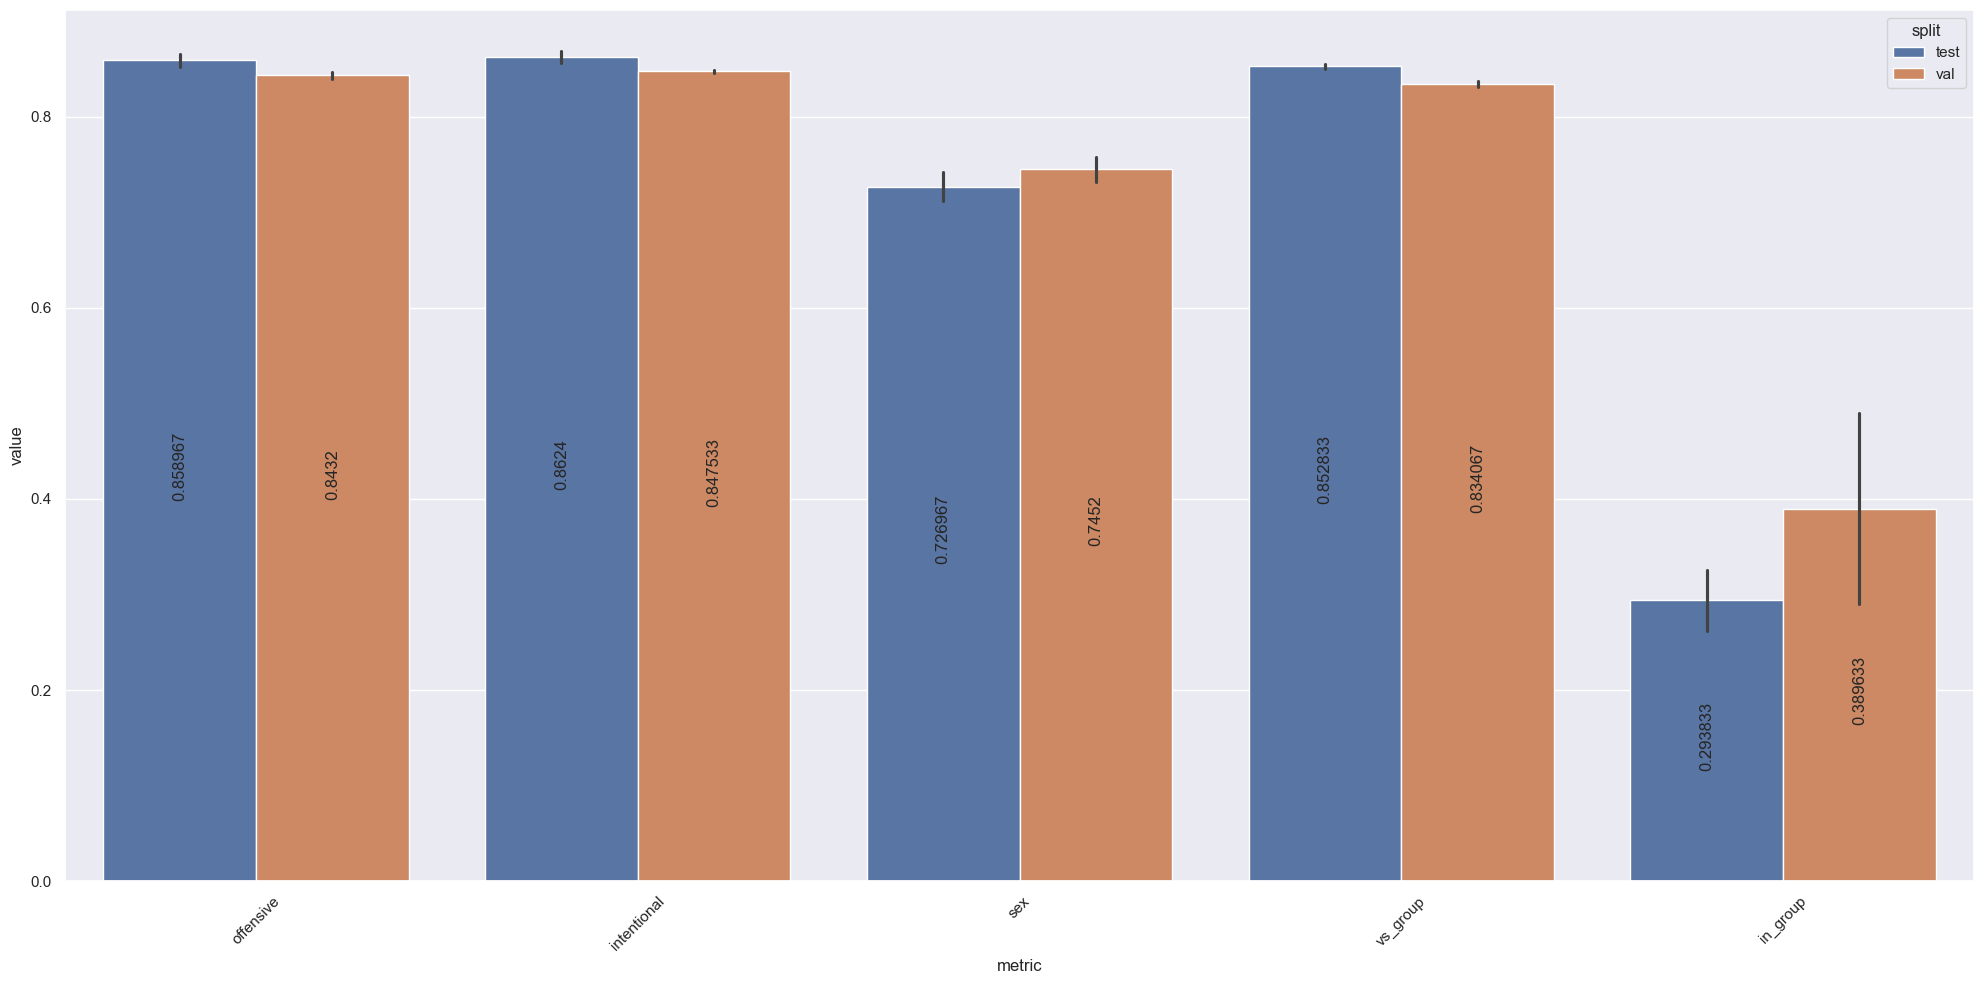

In [ ]:
# Aggregated view: average and std over seeds
plot_metrics_bar(results, multiple_seeds=True)

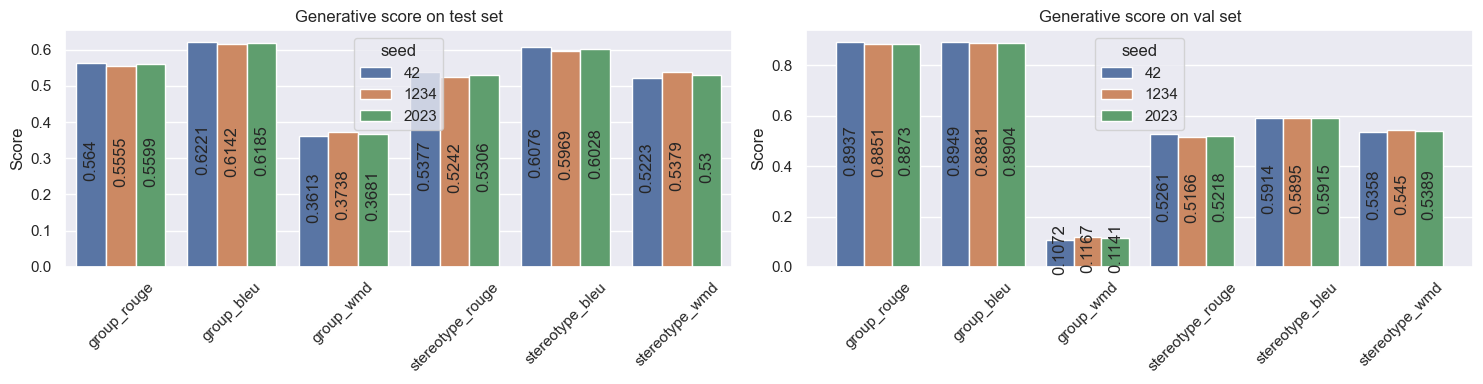

In [ ]:
results = evaluator.evaluate_per_seed_generation(predictions)
plot_generative_results(results)

Also generative performances are similar across seeds and between val and test set. Again, degradation on group classification are due to non aggregation of the labels.

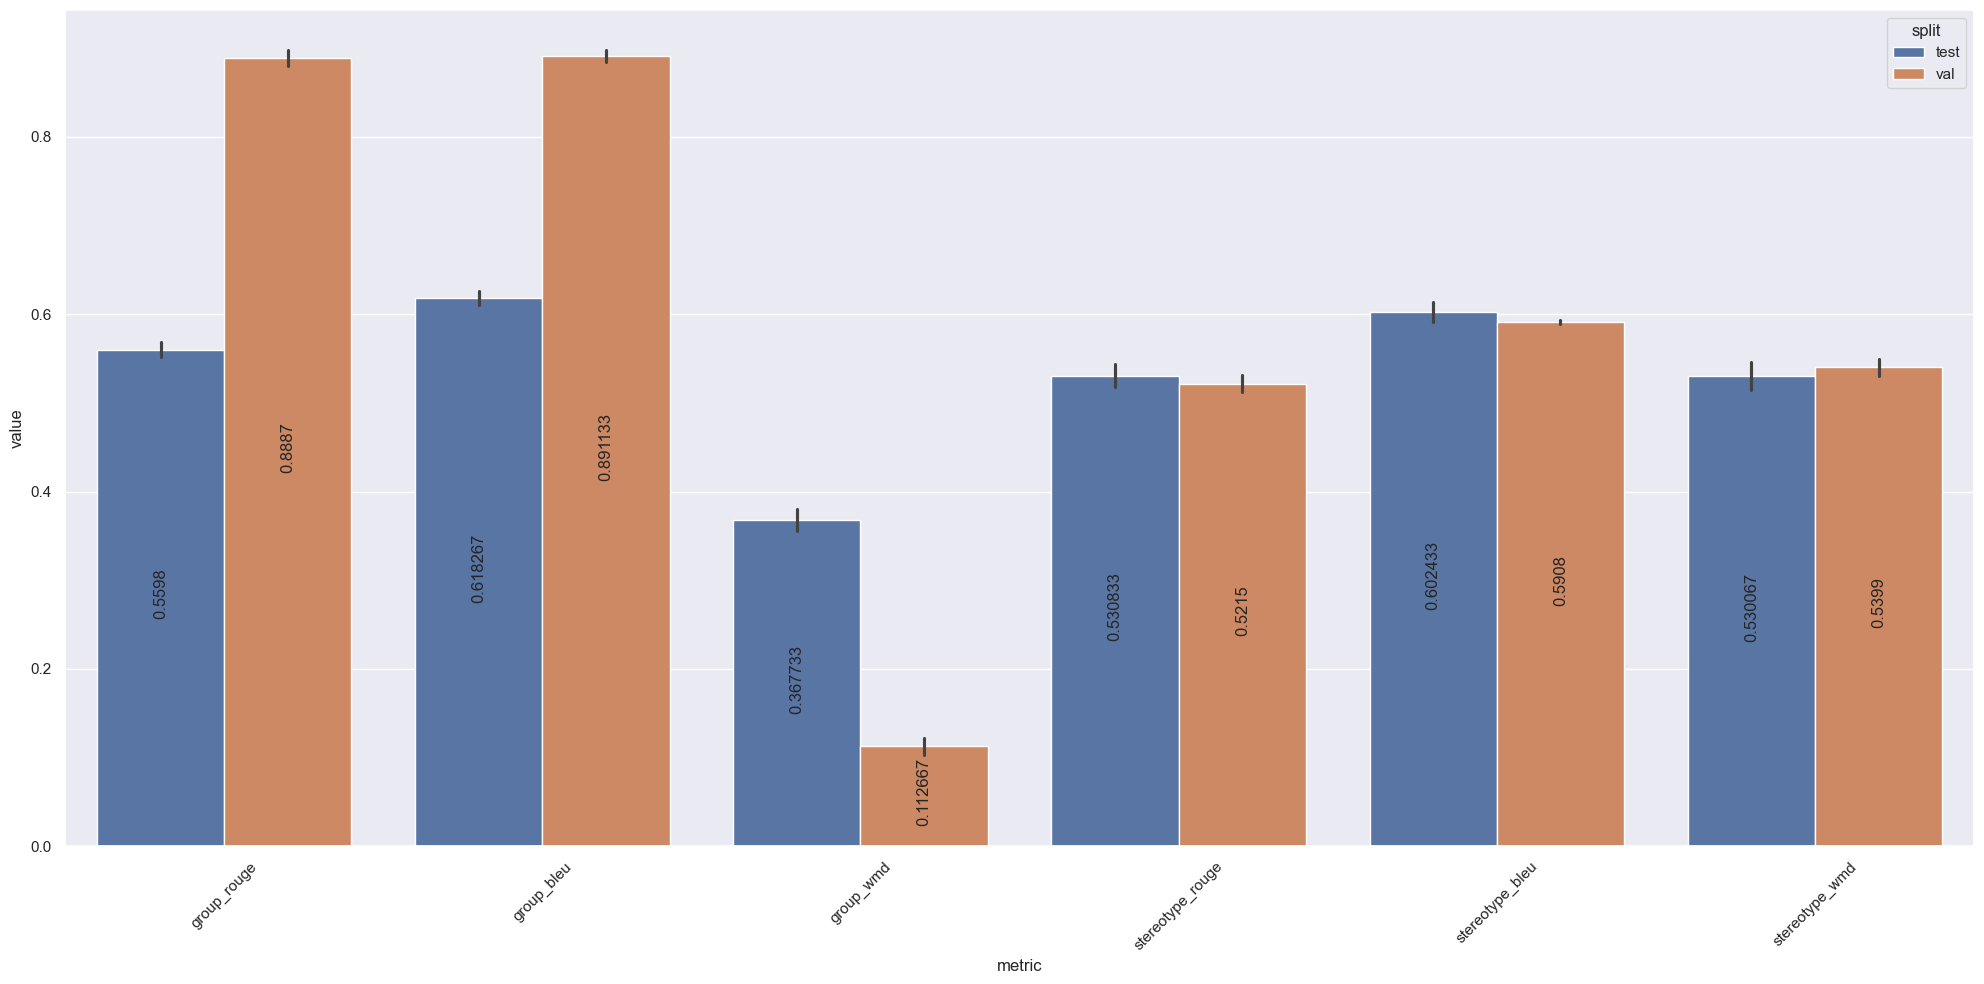

In [ ]:
# Aggregated view: average and std over seeds
plot_metrics_bar(results, multiple_seeds=True)

## Models comparison

Here, we compare perfomances of the two models. We will determine the best one according to the validation set.

In [ ]:
classification_results = {}
generative_results = {}
for model_name in ("gpt2", "bart"):
    config = Config.load_config(model_name=model_name)
    evaluator = Evaluator(config)
    predictions = load_per_seed_predictions(SEEDS, config)
    classification_results[model_name] = evaluator.evaluate_per_seed_classification(
        predictions
    )
    generative_results[model_name] = evaluator.aggregate_per_seed_generation_results(
        predictions
    )

According to the validation set, bart is more effective on the classification task. This shows the effectiveness of a separate classification head and of the bidirectional attention on the post. Further experiments may better delineate the contributions.

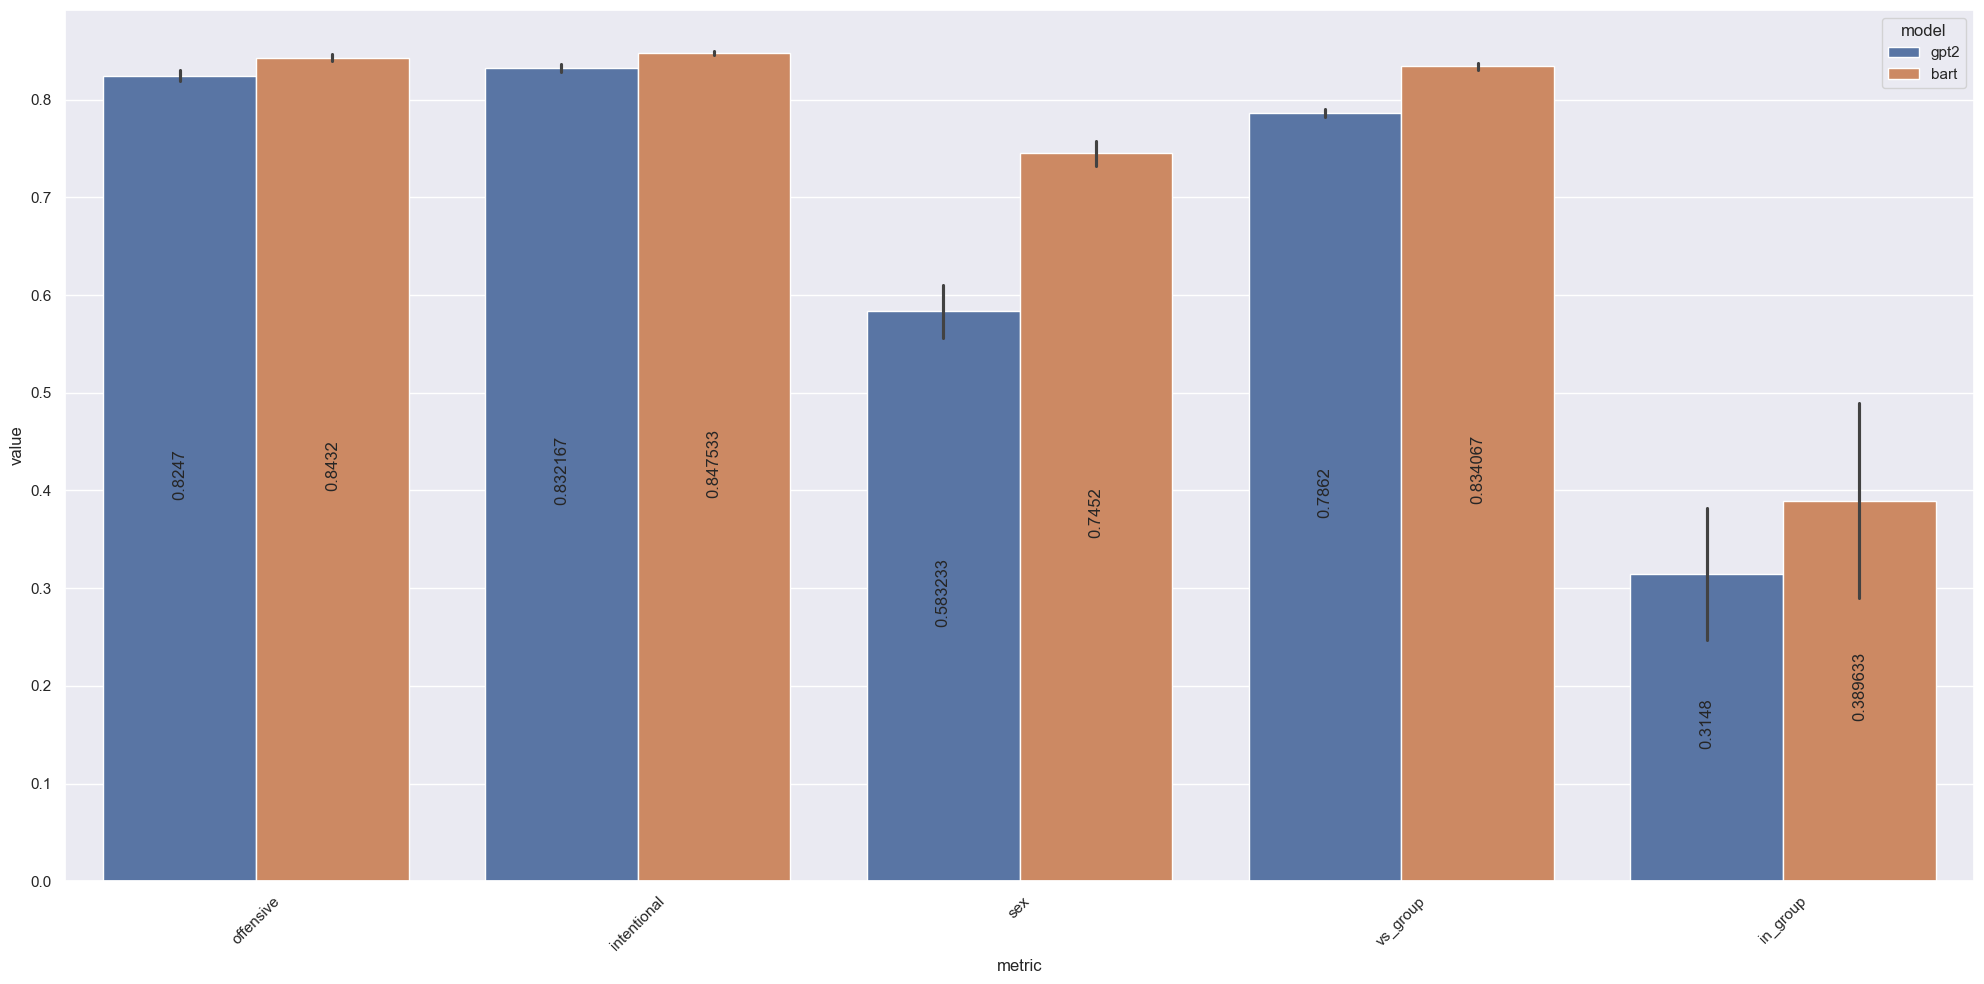

In [ ]:
plot_models_metrics_bar(classification_results, split="validation", multiple_seeds=True)

On generative task, the two models are comparable. However, bart is better at predicting groups, while gpt2 at predicting stereotypes.

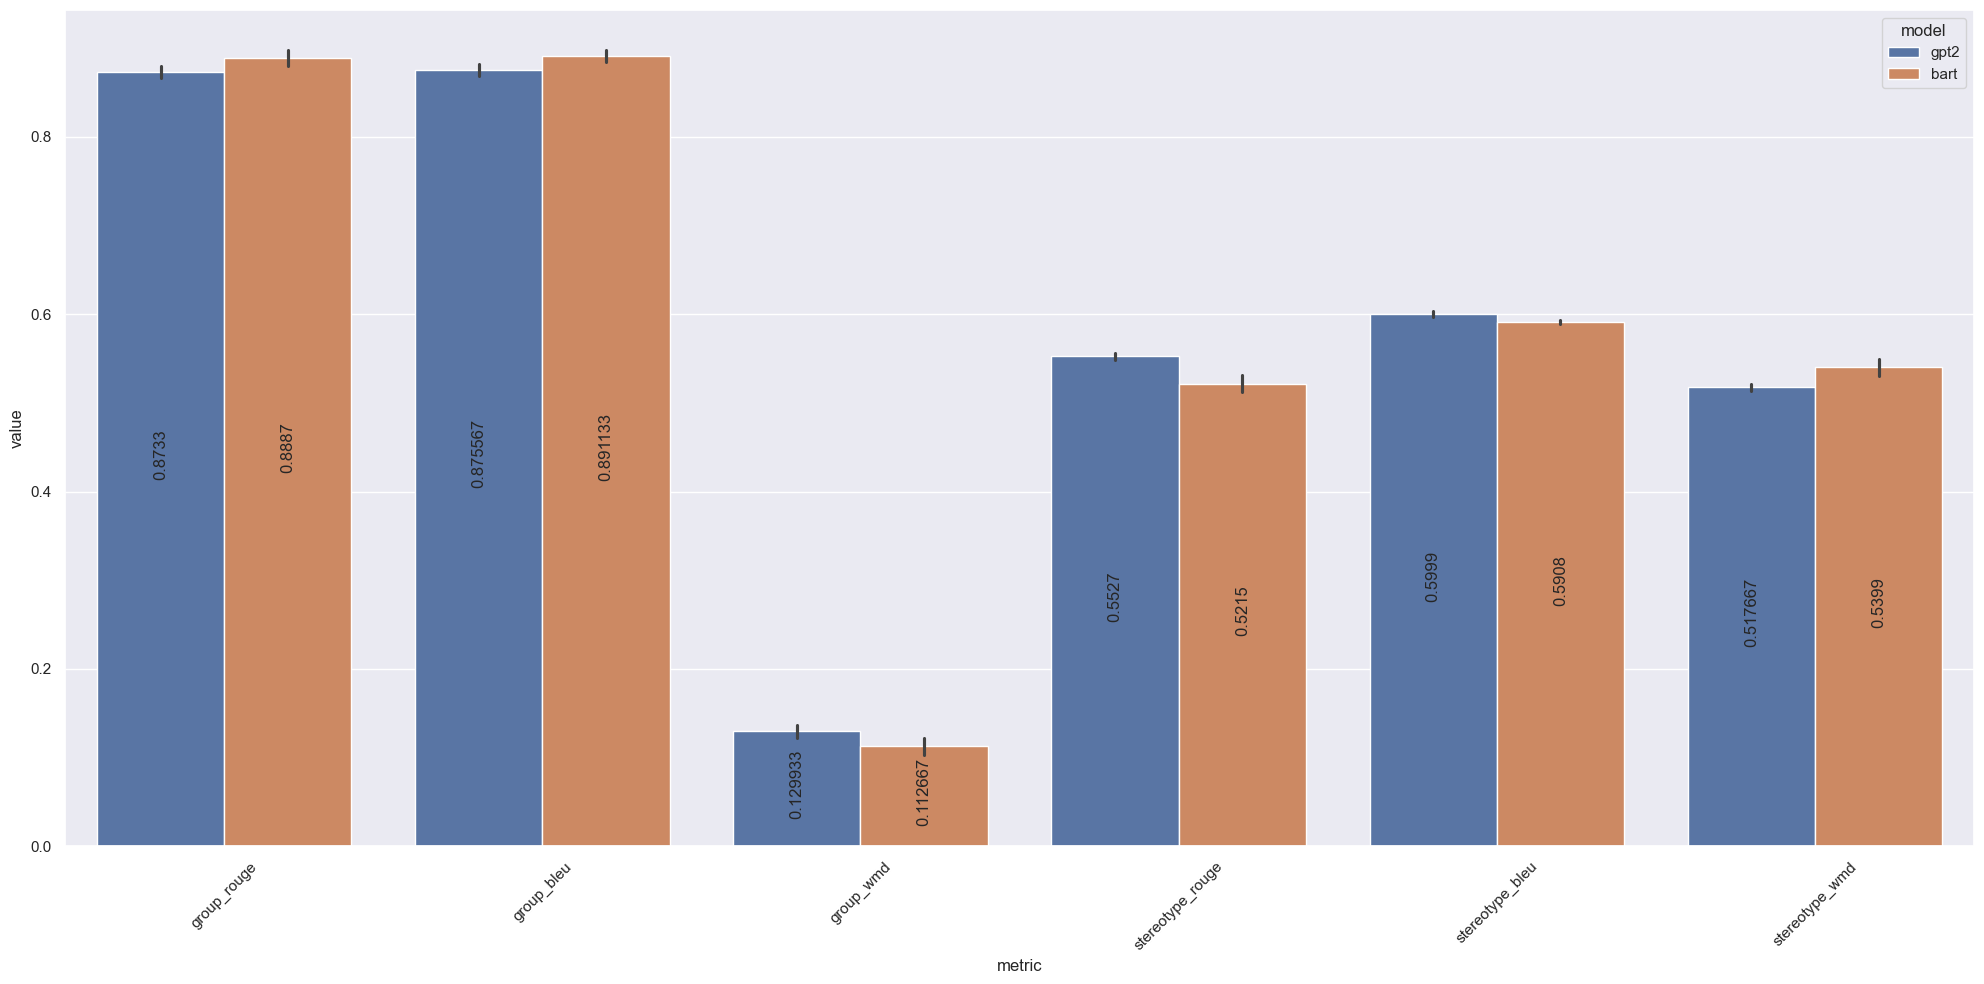

In [ ]:
plot_models_metrics_bar(generative_results, split="validation", multiple_seeds=True)

To sum up, if we are more interested on good classification performances (group prediction is a sort of free-text classification), we should choose bart. On contrary, if we are interested on good implied statement generations, we should prefer gpt2. It is worth mentioning that we are not defining a winner according to their pretraining (i.e. according to the original checkpoints), but we are comparing the architectures after fine-tuning them. We believe that improvements to the gpt2 architecture leads to results even better than the one obtained with bart.

Considerations made on the validation set are extended to the test set, since results show same trends.

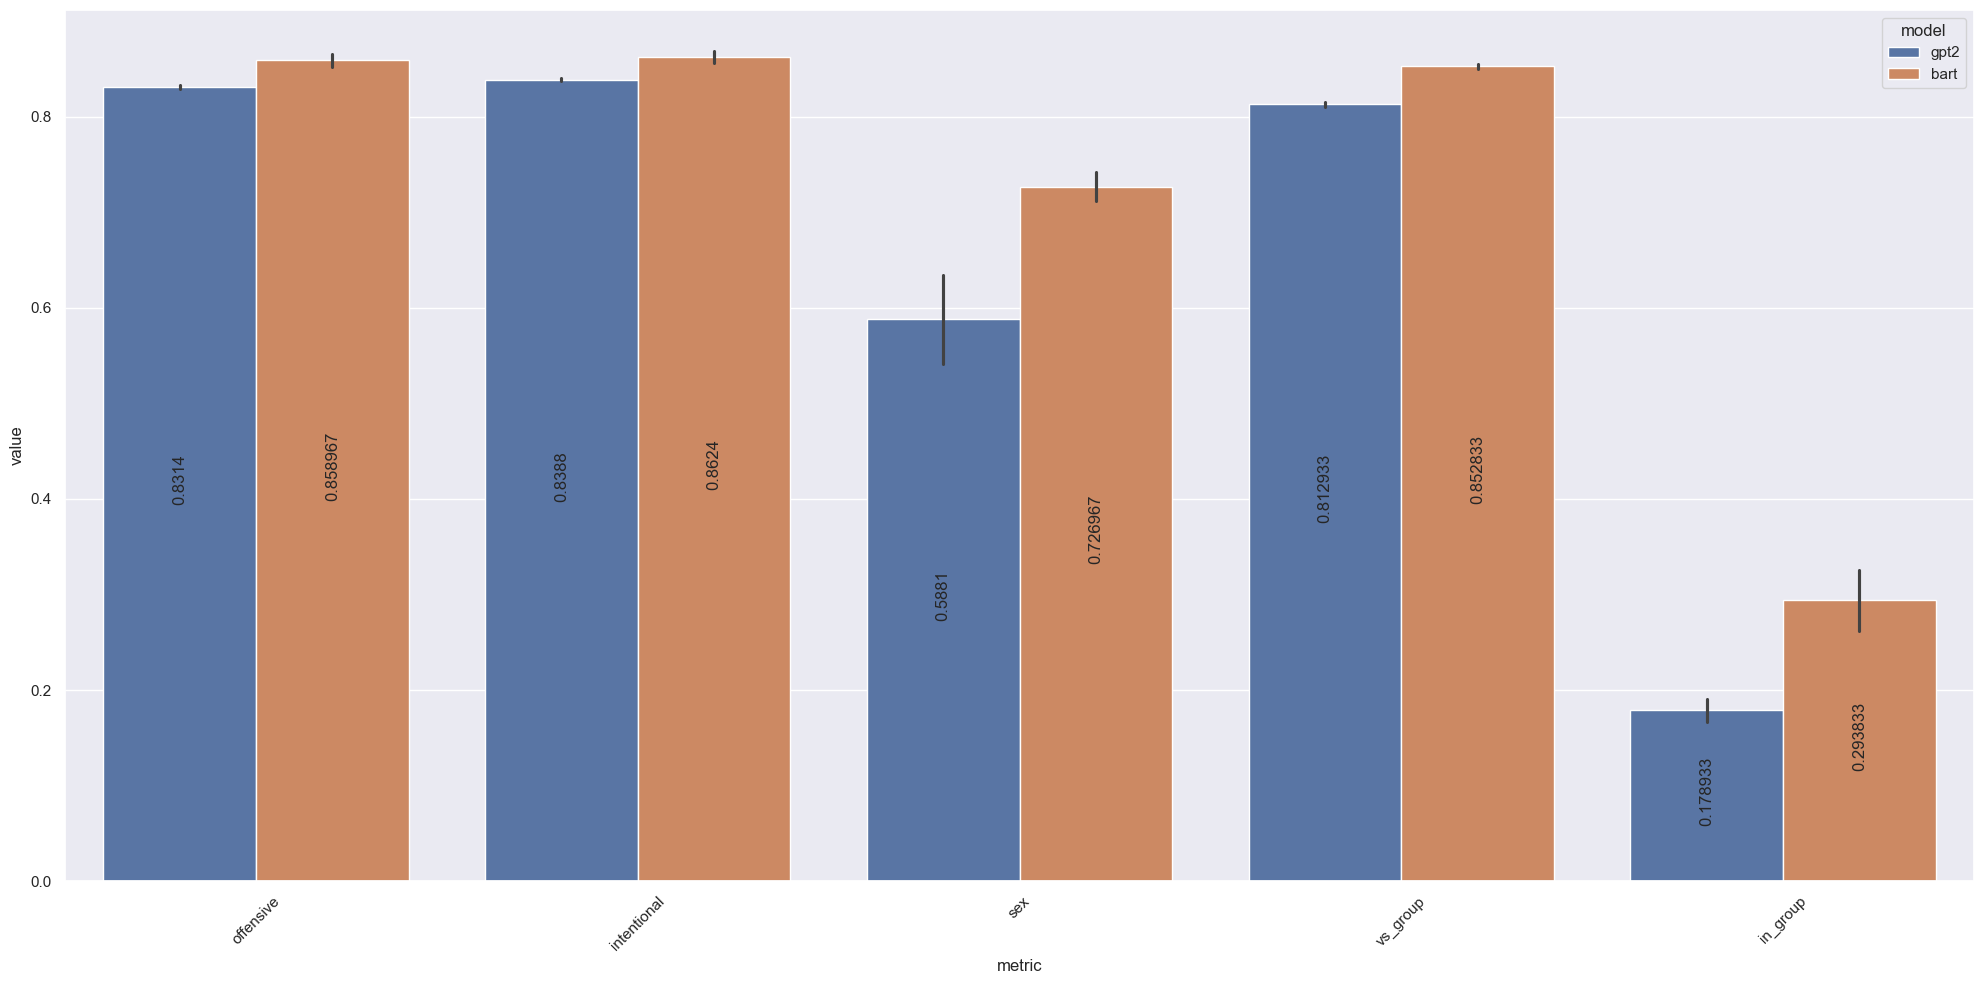

In [ ]:
plot_models_metrics_bar(classification_results, split="test", multiple_seeds=True)

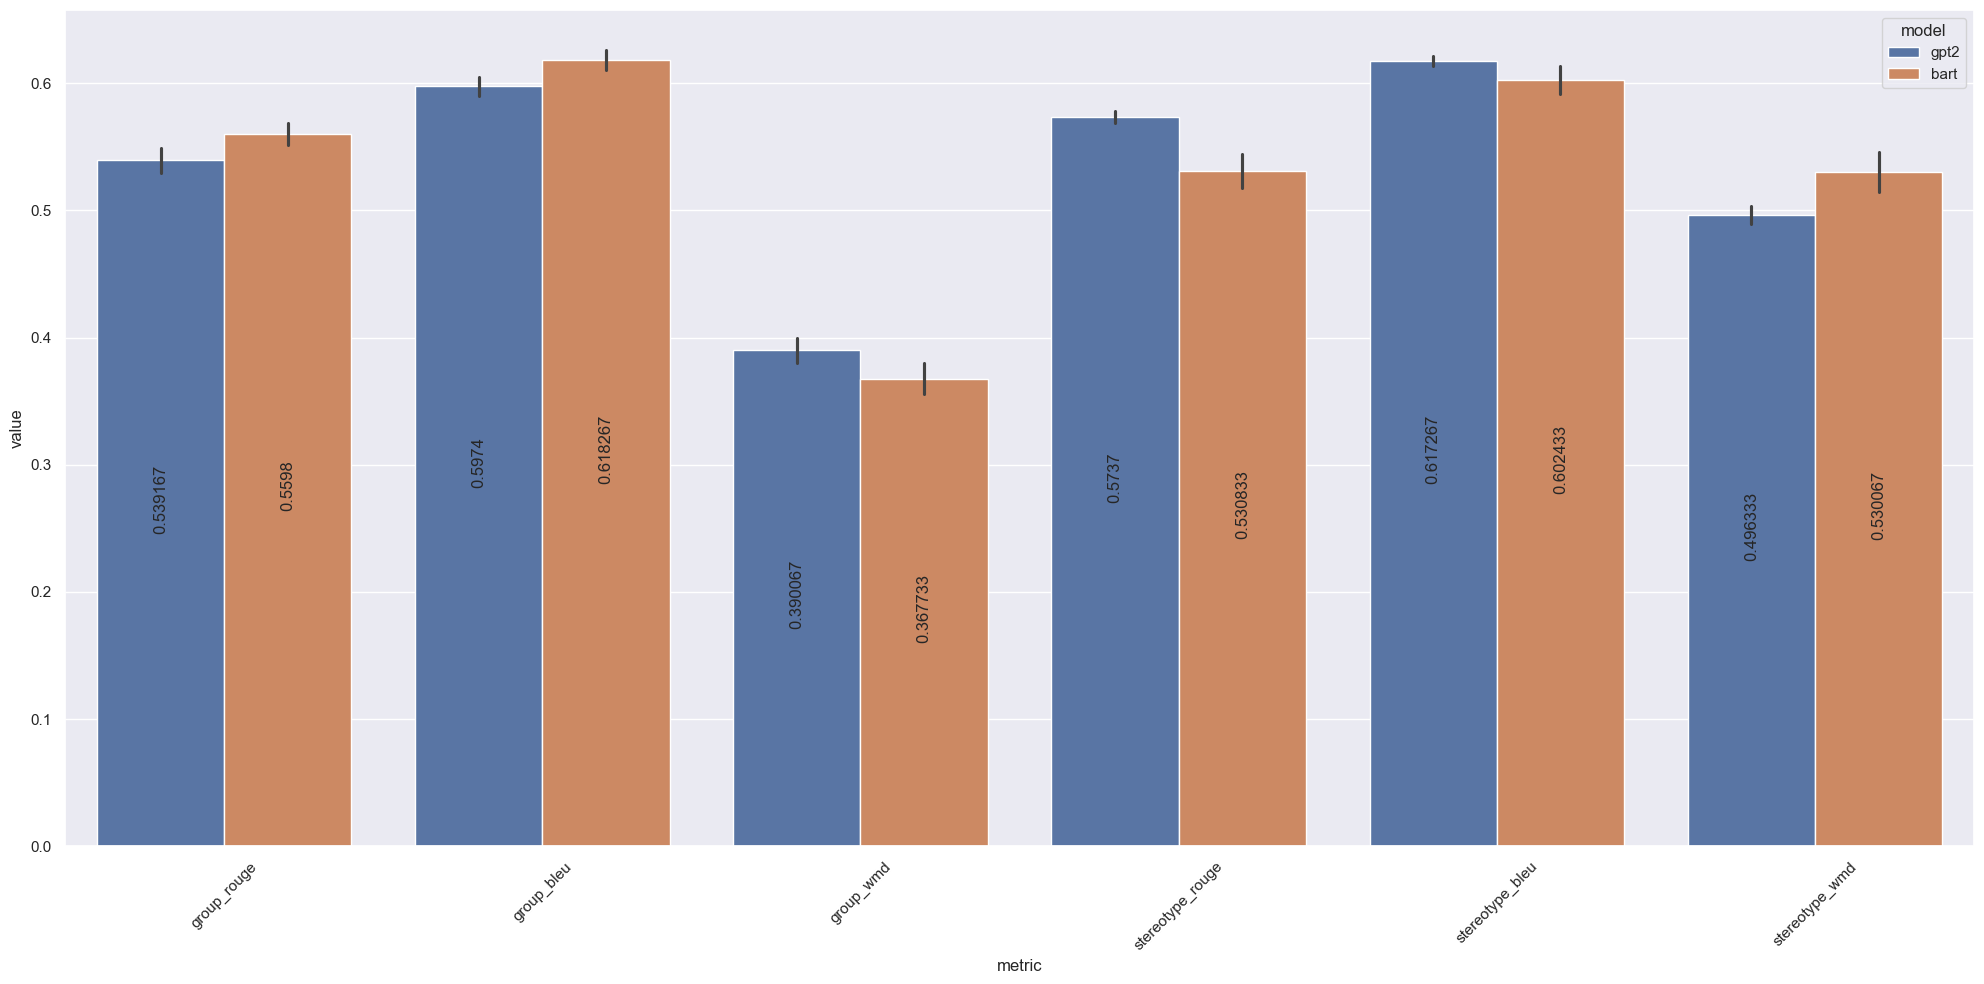

In [ ]:
plot_models_metrics_bar(generative_results, split="test", multiple_seeds=True)

# Error Analysis

We want to observe errors made by our models. We only consider the checkpoints obtained with a seed value of `42`.

In [ ]:
seed = "42"
model_predictions = {}
for model_name in ("gpt2", "bart"):
    config = Config.load_config(model_name=model_name)
    path = os.path.join(config.data.prediction, seed, "test")
    predictions = datasets.load_from_disk(path).map(
        lambda example: {"source": example["source"][0]}
    )
    model_predictions[model_name] = predictions
config = Config.load_config()

## Classification Error Analysis

Let's start by considering classification errors. At first sight, we see that BART model has an higher precision but lower recall compared to GPT2.

gpt2


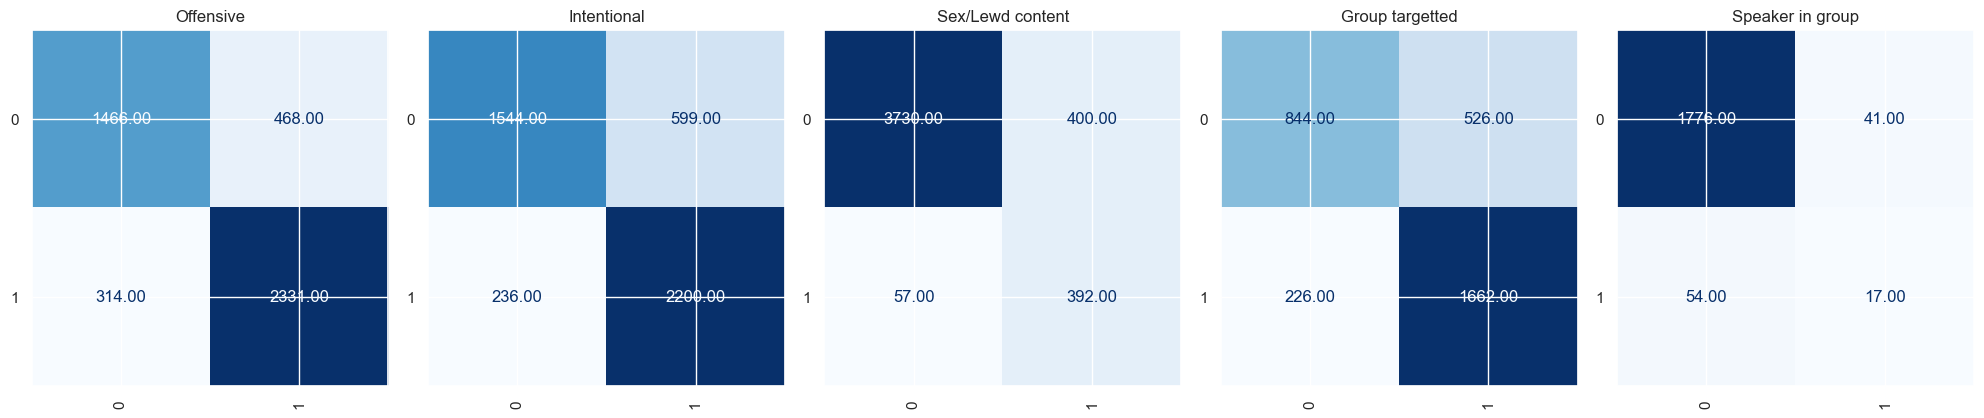

bart


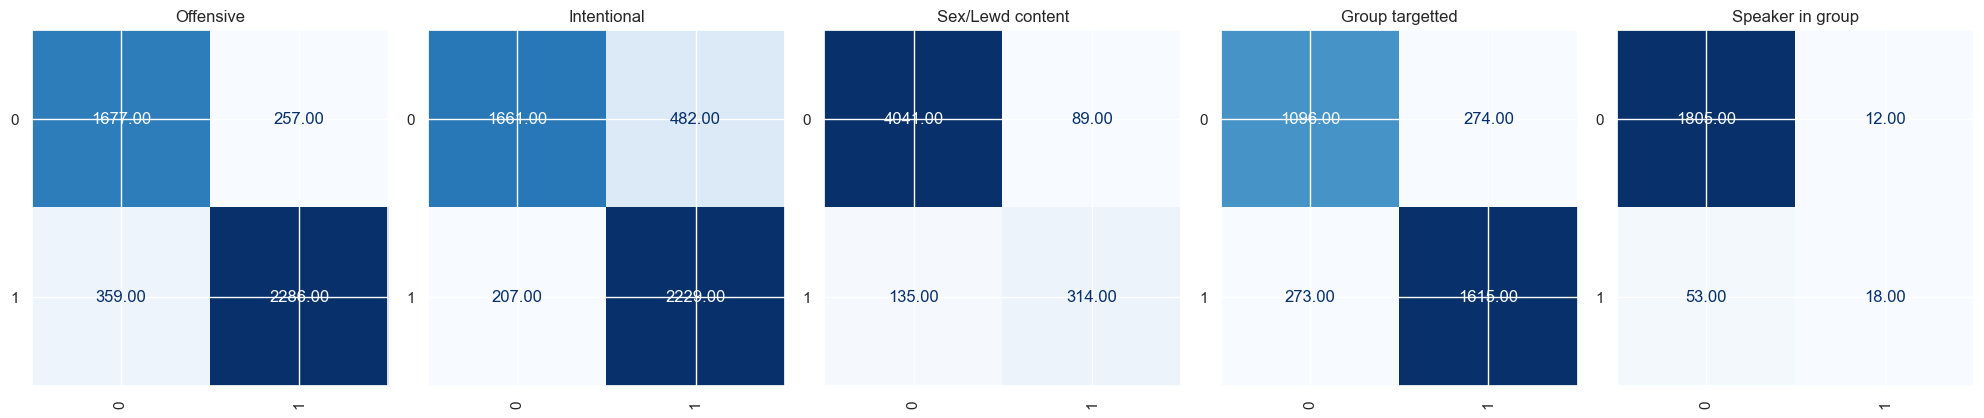

In [ ]:
for model_name, predictions in model_predictions.items():
    print(model_name)
    plot_classification_cm(predictions, config=config, normalize=None)

In [ ]:
model_predictions = to_pandas(model_predictions, key_name="model")

First of all, some posts are hard to classify, since requires a deep knowledge of the oustide world. For example, post `It makes me angry how often the TIFU sub is full of men getting screwed just because they are men` requires the network to know about the subreddit TIFU.

Moreover, we note that the models tend to classify as offensive posts that contains words usually used to offend.

In [ ]:
print_missclassified_samples(model_predictions, cls_column="offensive", config=config)

Intentional shows a behavior similar to offensive.

In [ ]:
print_missclassified_samples(model_predictions, cls_column="intentional", config=config)

Additionaly, we compute the conditional probabilities of intentional given the offensivness of the post. This means that neither of the two models understands what intentionality is and whenever there is an offensive post, it will be marked as intentional. This can be acceptable because we recognize that it's a difficult task to learn.

Anyway, as highlighted by the true probabilty, the majority of the offensive posts are written with the mere purpose to offend.

In [ ]:
for model_name in ("gpt2", "bart"):
    print_conditional_probs(model_predictions, model_name, hypothesis_name="intentional", evidence_name="offensive", config=config)

---------- gpt2 ----------
True P(intentional | offensive): 0.9119092627599243
Pred P(intentional | offensive): 1.0

---------- bart ----------
True P(intentional | offensive): 0.9119092627599243
Pred P(intentional | offensive): 0.9992135273299253



We do not see any clear pattern in sex miss-classification.

In [ ]:
print_missclassified_samples(model_predictions, cls_column="sex", config=config)

However, it is interesting to note that gpt2 model highly overweights sex when it labels the post as offensive.

In [ ]:
for model_name in ("gpt2", "bart"):
    print_conditional_probs(model_predictions, model_name, hypothesis_name="sex", evidence_name="offensive", config=config)

---------- gpt2 ----------
True P(sex | offensive): 0.15160680529300566
Pred P(sex | offensive): 0.2590210789567703

---------- bart ----------
True P(sex | offensive): 0.15160680529300566
Pred P(sex | offensive): 0.13881242626818718



*Again*, we don't see any interesting pattern to highlight the error of vs_group

In [ ]:
print_missclassified_samples(model_predictions, cls_column="vs_group", config=config)

Another time, GPT2 tends to classify more that the post wants to offend a specific group rather than BART.

In [ ]:
for model_name in ("gpt2", "bart"):
    print_conditional_probs(model_predictions, model_name, hypothesis_name="vs_group", evidence_name="offensive", config=config)

---------- gpt2 ----------
True P(vs_group | offensive): 0.7137996219281664
Pred P(vs_group | offensive): 0.8399428367274027

---------- bart ----------
True P(vs_group | offensive): 0.7137996219281664
Pred P(vs_group | offensive): 0.7609123082972866



Finally, also for in_group we don't notice any patterns.

In [ ]:
print_missclassified_samples(model_predictions, cls_column="in_group", config=config)

Due to its high imbalance, the model tends to predict most of the times that the writer doesn't belong to the group and it leads also to a lower predicted probability as in BART.

In [ ]:
for model_name in ("gpt2", "bart"):
    print_conditional_probs(model_predictions, model_name, hypothesis_name="in_group", evidence_name="offensive", config=config)

---------- gpt2 ----------
True P(in_group | offensive): 0.026843100189035917
Pred P(in_group | offensive): 0.03536977491961415

---------- bart ----------
True P(in_group | offensive): 0.026843100189035917
Pred P(in_group | offensive): 0.025560361777428233



In general, we note that gpt2 model predictions are highly affected by previous ones. We think it is due to its autoregressive nature. On contrary, for bart each classification feature is (almost) independent from the others.

Morover, we want to see if there is any relationship between classification errors and input length.

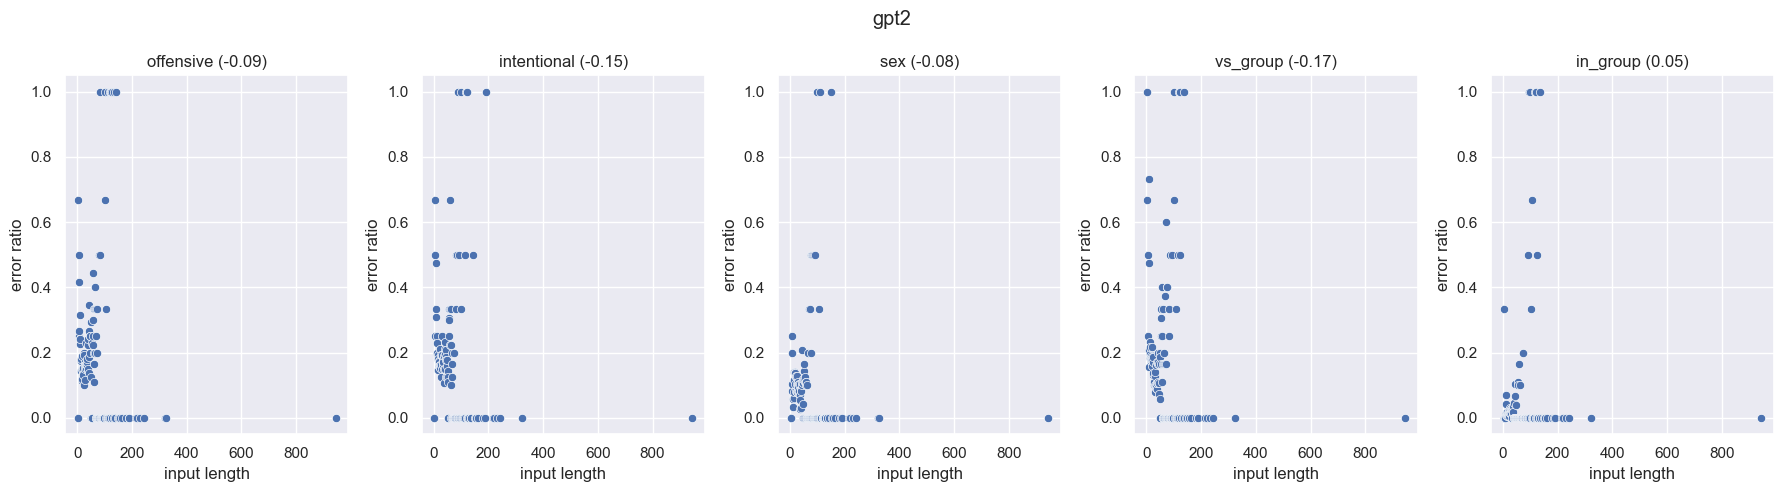

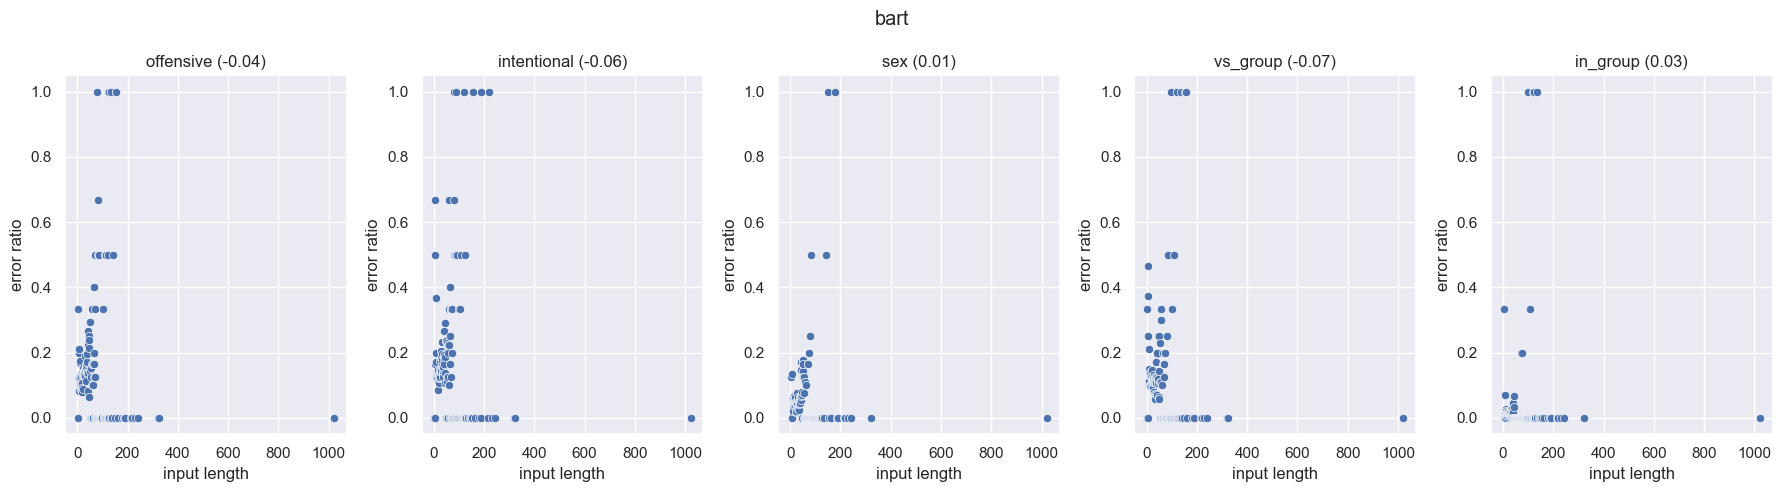

In [ ]:
for model_name in ("gpt2", "bart"):
    fig, axs = plt.subplots(1, len(config.classification_columns), figsize=(18, 5))
    for i, (ax, cls_column) in enumerate(
        zip(axs, config.classification_columns, strict=True)
    ):
        preds = model_predictions[model_predictions["model"] == model_name].copy()
        preds["input length"] = preds["input_ids"].apply(len)
        preds["input length"].value_counts()
        missclassified_samples = get_missclassified_samples(
            preds,
            cls_column=cls_column,
            cls_idx=config.classification_columns.index(cls_column),
        ).copy()
        freq_errors = (
            missclassified_samples["input length"].value_counts()
            / preds["input length"].value_counts()
        )
        freq_errors = (
            freq_errors.fillna(0).reset_index().rename({"count": "error ratio"}, axis=1)
        )
        sns.scatterplot(freq_errors, x="input length", y="error ratio", ax=ax)
        corr = freq_errors["input length"].corr(freq_errors["error ratio"])
        ax.set_title(f"{cls_column} ({corr:.2f})")
    fig.suptitle(model_name)
    plt.tight_layout()
    plt.show()

As we can see from the plot, there is no correlation. Therefore, input length seems not to affect classification performances.

Some sources have similar results among the two models: e.g. `t/founta` for `offensive` and `intentional` classes and `Stormfront` for `sex`. Therefore, the issue may be in the data.\
Others have very different results: e.g. `redditMicroagressions` for `sex`. Let's inspect them.

gpt2


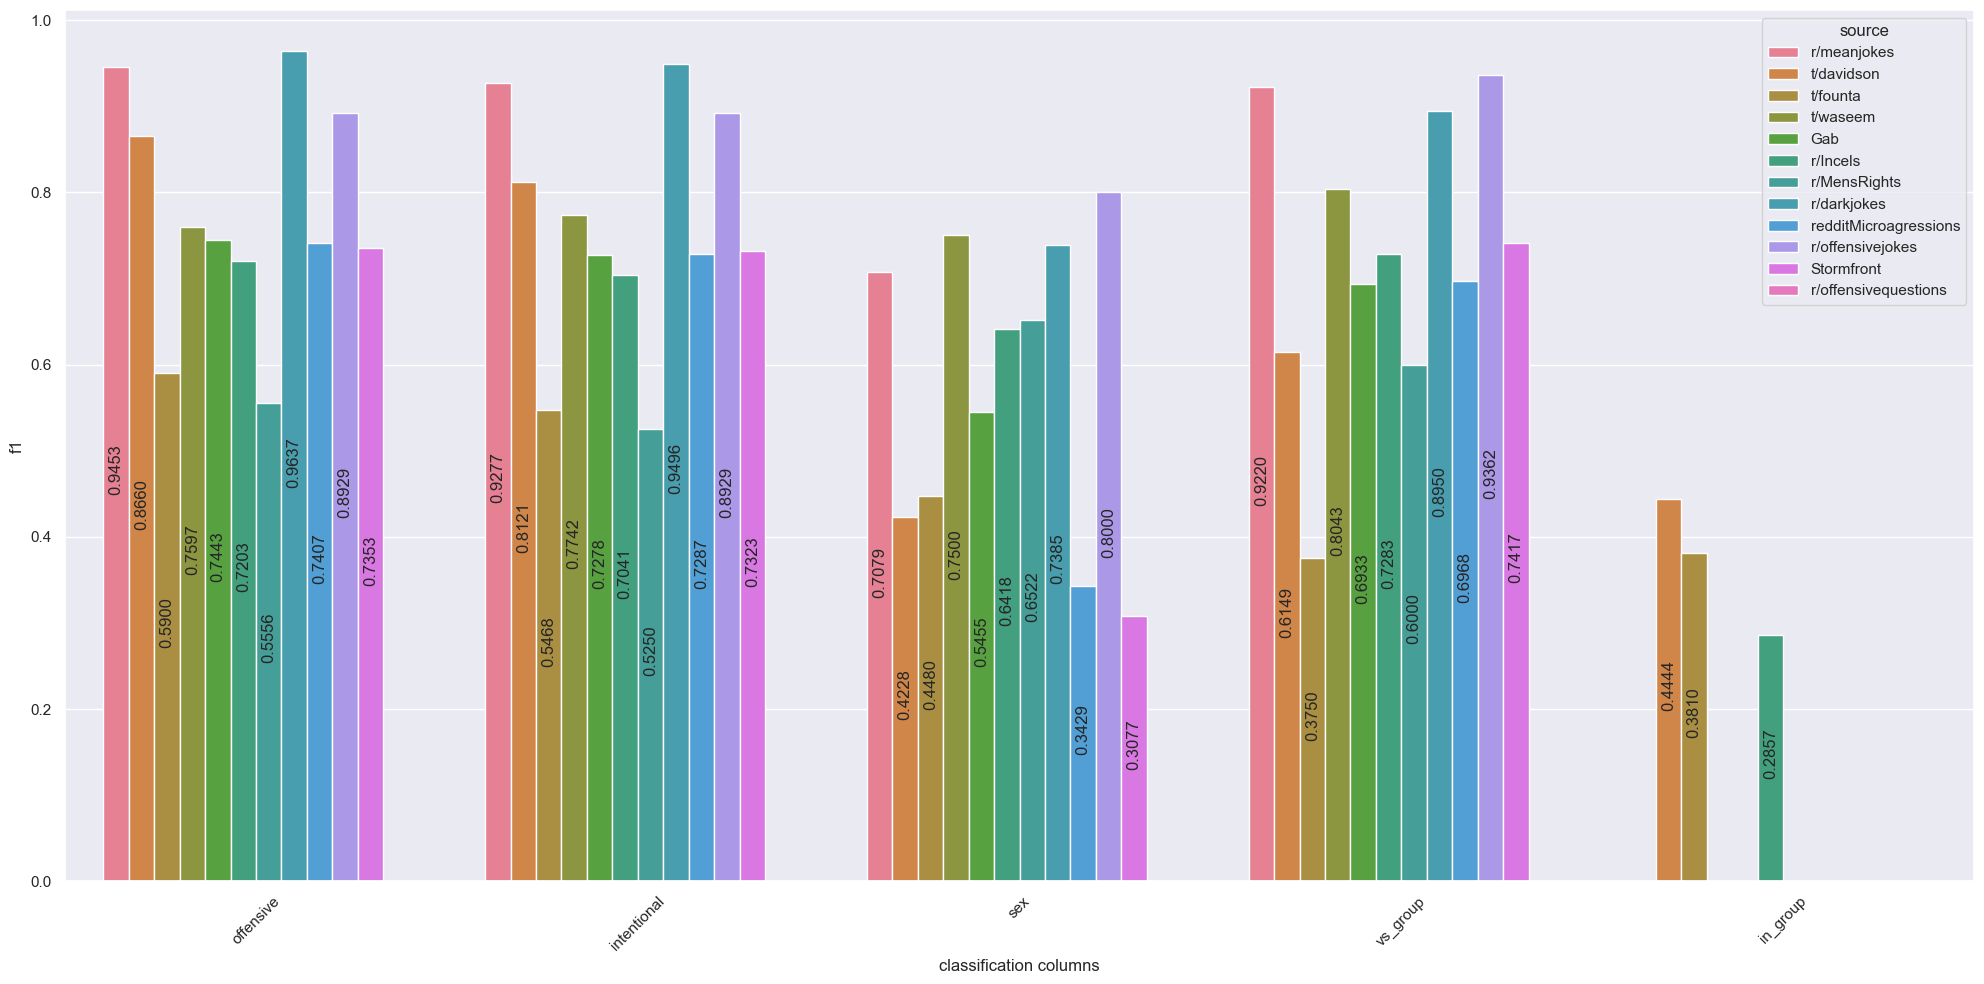

bart


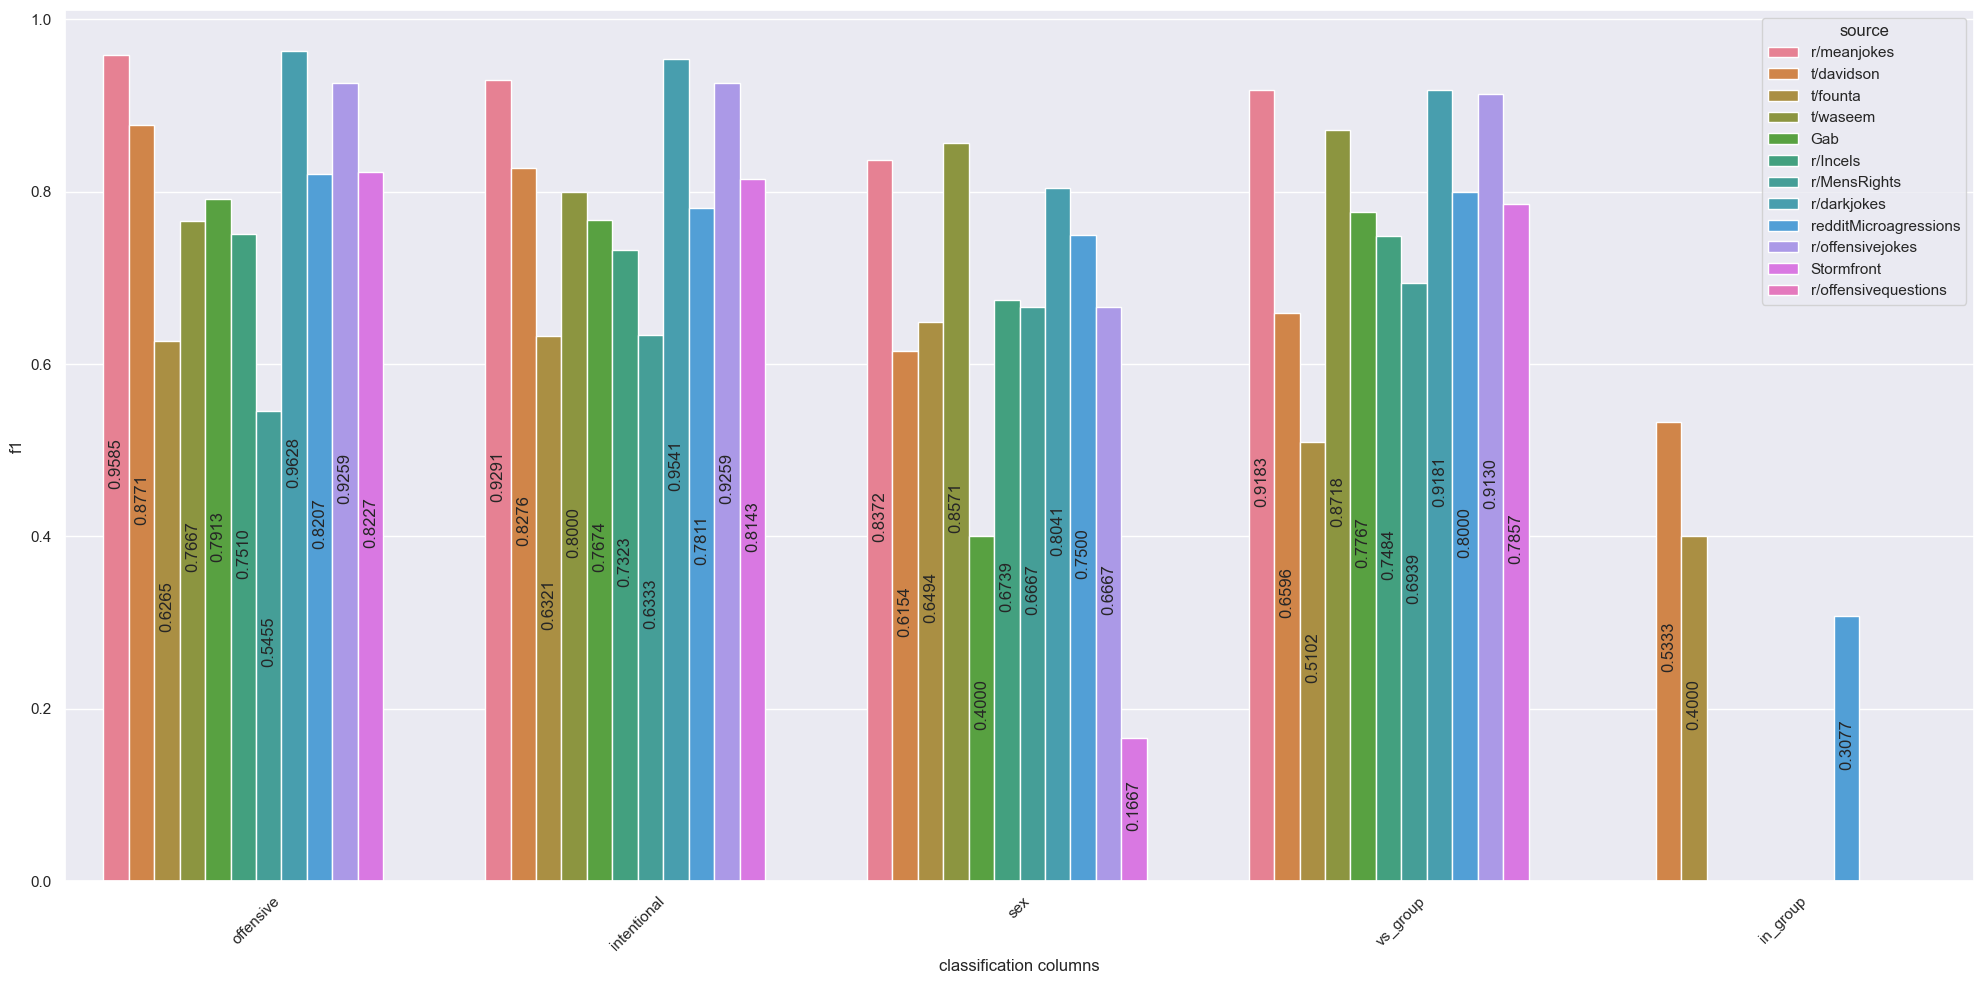

In [ ]:
sources = model_predictions["source"].unique()
for model_name in ("gpt2", "bart"):
    print(model_name)
    config = Config.load_config(model_name=model_name)
    evaluator = Evaluator(config)
    predictions = model_predictions[model_predictions["model"] == model_name]
    cls_scores = {
        source: evaluate_classification(
            evaluator, predictions[predictions["source"] == source], config=config
        )
        for source in sources
    }
    plot_comparison_bar(
        cls_scores, x_label="classification columns", y_label="f1", hue="source"
    )

By inspecting specific posts, we do not note anything interesting nor any pattern specific to a source.

In [ ]:
cls_sources = [
    ("offensive", "t/founta"),
    ("intentional", "t/founta"),
    ("sex", "Stormfront"),
    ("sex", "redditMicroagressions"),
]
for cls_column, source in cls_sources:
    print_missclassified_samples(
        model_predictions,
        cls_column=cls_column,
        config=config,
        filter_fn=lambda s: s["source"] == source,
        additional_columns=["source"],
        n_samples=5,
    )

## Generative Error Analysis

Let's inspect generative errors: errors on groups and stereotypes.

In [ ]:
group_metrics = ["group_rouge", "group_blue", "group_wmd"]
stereotype_metrics = ["stereotype_rouge", "stereotype_blue", "stereotype_wmd"]
generative_metrics = group_metrics + stereotype_metrics
model_predictions[group_metrics] = model_predictions["group_scores"].apply(
    lambda scores: pd.Series(get_best_score(scores))
)
model_predictions[stereotype_metrics] = model_predictions["stereotype_scores"].apply(
    lambda scores: pd.Series(get_best_score(scores))
)

First of all, we show that input length does not affect generative performances.

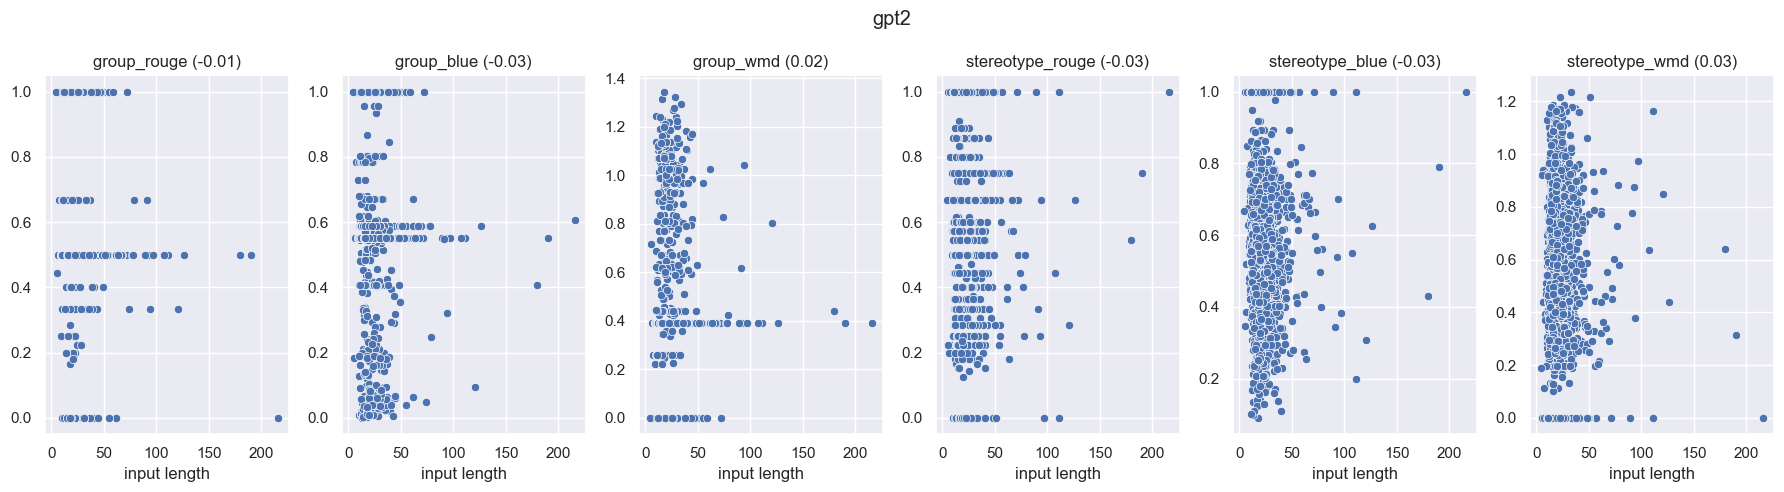

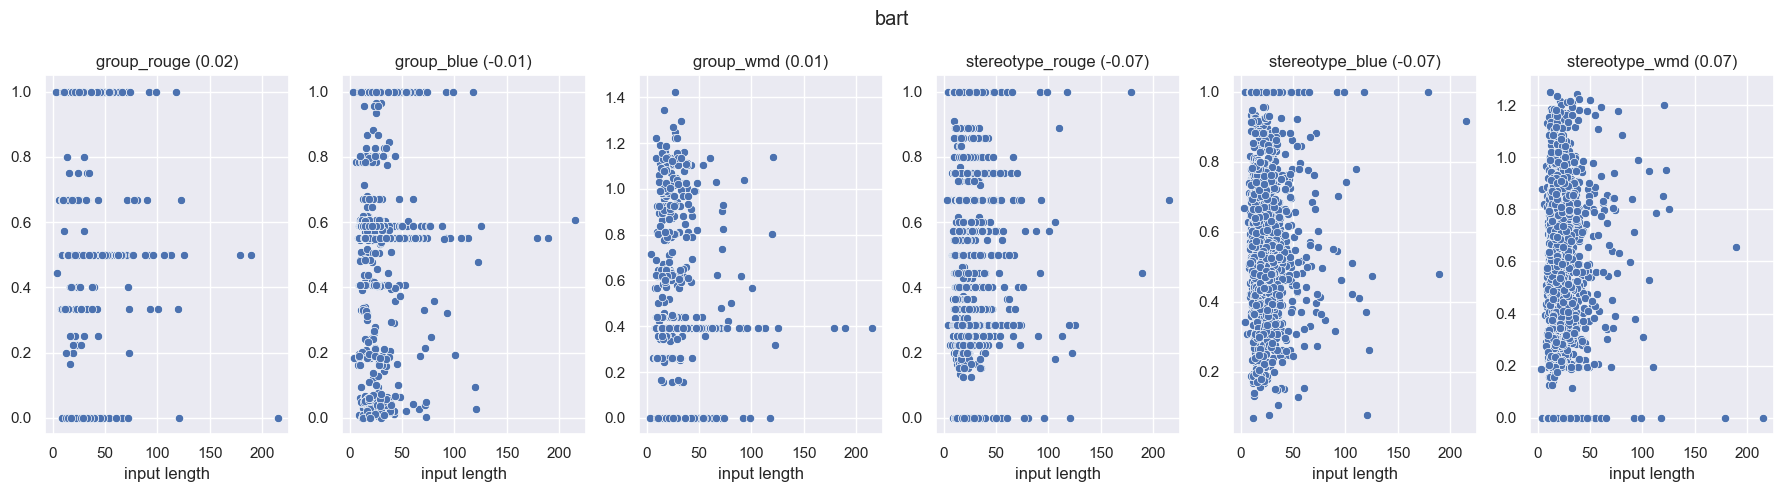

In [ ]:
for model_name in ("gpt2", "bart"):
    preds = model_predictions[model_predictions["model"] == model_name].copy()
    preds["input length"] = preds["input_ids"].apply(len)

    fig, axs = plt.subplots(1, len(generative_metrics), figsize=(18, 5))
    for i, (ax, metric) in enumerate(zip(axs, generative_metrics, strict=True)):
        sns.scatterplot(preds, x="input length", y=metric, ax=ax)
        corr = preds["input length"].corr(preds[metric])
        ax.set_title(f"{metric} ({corr:.2f})")
        ax.set_ylabel(None)
    fig.suptitle(model_name)
    plt.tight_layout()
    plt.show()

Sources have almost same performances. This is particularly true for stereotypes (i.e. implied statements).

gpt2


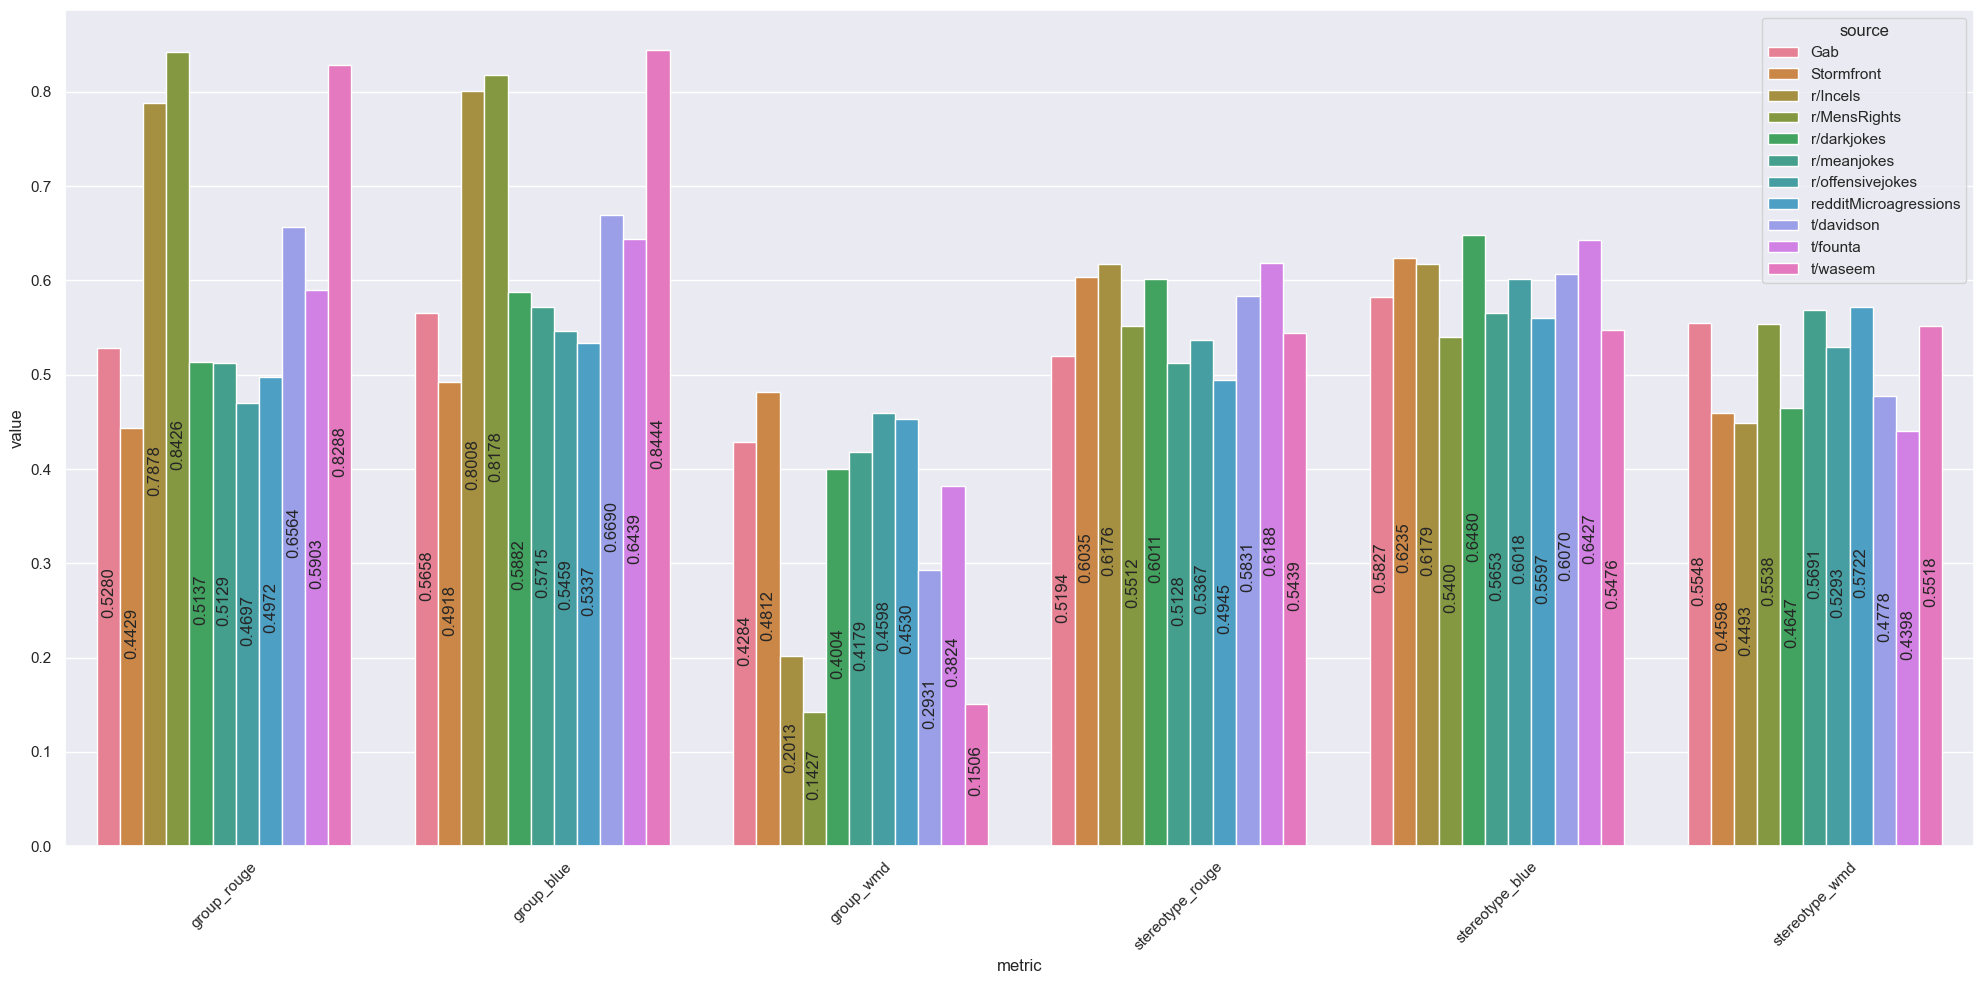

bart


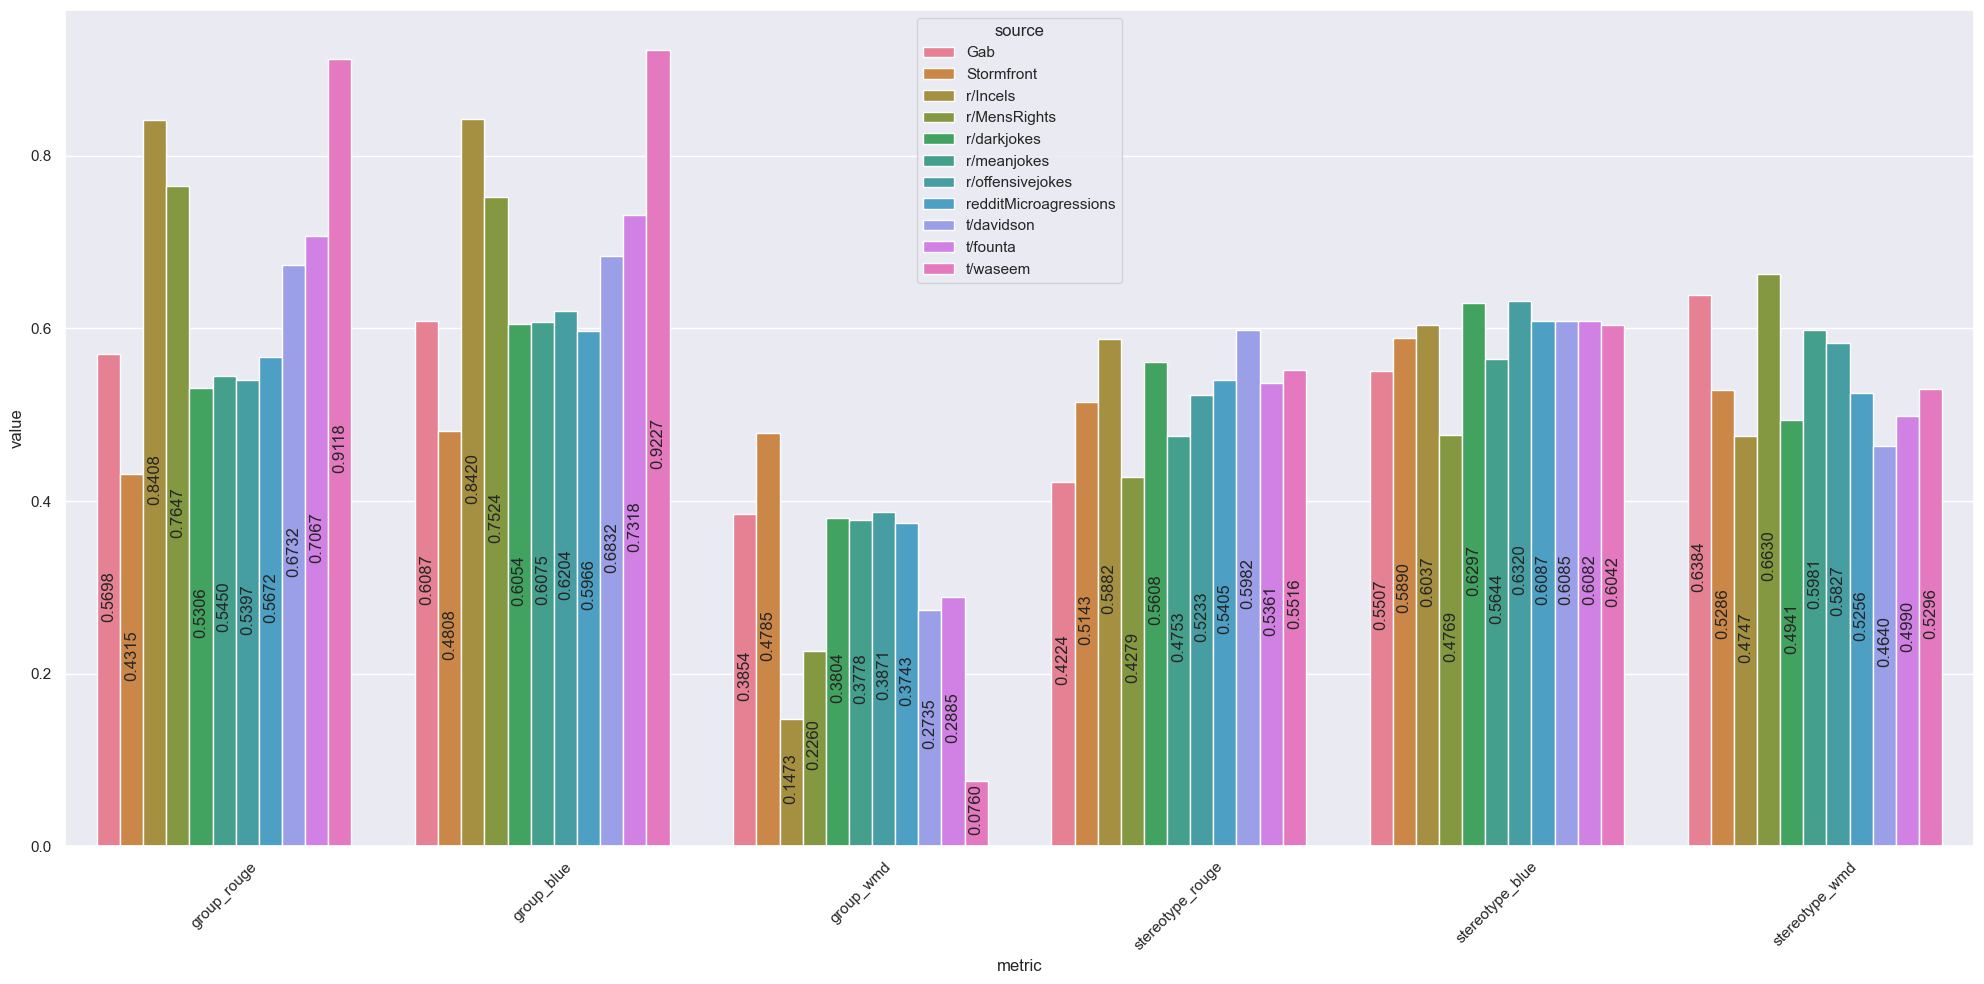

In [ ]:
for model_name in ("gpt2", "bart"):
    preds = model_predictions[model_predictions["model"] == model_name]
    gen_results_by_source = (
        preds[generative_metrics + ["source"]].groupby("source").mean().dropna()
    )
    print(model_name)
    plot_comparison_bar(gen_results_by_source.T, hue="source")

Since rouge, blue and wmd are highly correlated, we print worst generations according to rouge on group and stereotype.

In [ ]:
display(model_predictions[group_metrics].corr())
display(model_predictions[stereotype_metrics].corr())

group_rouge  group_blue  group_wmd
group_rouge     1.000000    0.920620  -0.935858
group_blue      0.920620    1.000000  -0.926869
group_wmd      -0.935858   -0.926869   1.000000

stereotype_rouge  stereotype_blue  stereotype_wmd
stereotype_rouge          1.000000         0.895510       -0.956836
stereotype_blue           0.895510         1.000000       -0.904676
stereotype_wmd           -0.956836        -0.904676        1.000000

In [ ]:
def keep_best_pred(df, column_name):
    indices = df[f"{column_name}_scores"].apply(
        lambda scores: get_best_pred(scores, metric="rouge")
    )
    df[column_name] = [
        col_values[int(best_idx)] if pd.notnull(best_idx) else None
        for col_values, best_idx in zip(df[column_name], indices, strict=True)
    ]

predictions = model_predictions.copy()
keep_best_pred(predictions, "group")
keep_best_pred(predictions, "stereotype")

Let's start by analyzing worst group predictions. As we can see, lots of errors are not real errors, since the models predict the right group in an analogous form (e.g. pred: `fat people`, true: `overweight/fat folks`). Hence, it's a metric error, we believe that by using a better wmd embedding matrix or a metric that takes into account the meaning of the text should lead to better results.

It is interesting to note that they work by extracting and elaborating groups from the post. Indeed, they struggle to infer the right group from the context. e.g. `Last thing we want is them moving off the reserves`.
Moreover, it seems that when they cannot extract any group, they predict `black people` or `women`, as they are the most common reference groups in the dataset.

In [ ]:
for model_name in ("gpt2", "bart"):
    preds = predictions[predictions["model"] == model_name].copy()
    print("="*80, model_name, "="*80)
    print_worst_n(preds, "group")
    print()

================================================================================ gpt2 ================================================================================



================================================================================ bart ================================================================================


By analyzing implied statements, we immediately note that the statement is highly influenced by the predicted group. Hence, an error in the group prediction is likely to be reflected in the stereotype. This is due to the autoregressive nature of the decoders.

Again, implied statements are built by combining words in the post (e.g. `we should not help poor african children they are not entitled to food, they should be confident and funny`). They struggle when stereotype requires preliminary knowledge (e.g. `Why colored soap create white bubble ? Because jews are white`) or when the stereotype is subtle and require reasoning.

Morover, most of the time the implied statement follows a fixed structure: `<predicted group> are <adjective>`. When they are not able to extract the adjective from the post, they generate the one most seen at training time related to that group. For example `muslims are terrorists`.

We note that when bart generates the stereotype, it tends to change the predicted group, sometimes making errors (e.g. `muslim -> musmuslims, musls`).

In [ ]:
for model_name in ("gpt2", "bart"):
    preds = predictions[predictions["model"] == model_name].copy()
    print("="*80, model_name, "="*80)
    print_worst_n(preds, "stereotype")
    print()

================================================================================ gpt2 ================================================================================



================================================================================ bart ================================================================================


# Final consideration and Improvements

Models are effective in highlighting offensive posts and identifying targetted groups and stereotypes.

The pre-processing of posts helps to produce better classifications as highlighted by the results of both model on the test set. Unfortunately, we cannot say the same for the generative task. However, some 'errors' are due to the metrics and not to the model generations.

Groups and stereotypes are caught only when they are explicit, i.e. can be extracted from the post, or when they are based on well-known biases (e.g. `muslims are terrorists`). Therefore, models completely lack reasoning capabilities. We believe that it's due the limited models size.

To conclude we say that we are very satisfied of our results. We have achieved higher score compared to the paper of the dataset in all the tasks despite our limited computational resources. Some future improvements could be:
- Usage of bigger models such as GPT3, LLaMa with ad-hoc prompt tuning

- Posts are full of slangs and emojis both models have never seen before. We think that a consistent, but expensive, improvement may be obtained by pre-training the models with slang sources, such as `Urban Dictionary`.\
A more feasible improvement may be obtained by expanding the word embedding vocabulary with the top-k most frequent words.

- Posts are full of spell errors, abbreviations, etc. Fixing the errors and removing abbreviations will increase the quality of the data. This may be done in the preprocessing stage with an ad-hoc model.

- We did not make use of aggregated data in the training phase. Using them may improve classification and generative results. For example, we may consider the mean of the classification features, resulting in smoother probability landscapes. Morover, for each post, we may sample one of the implied statements, or we may find a way to combine them all.

- In all our experiments we used gredy-search in order to have results comparable with the ones of the dataset's paper. We believe that exploring other generation strategy may slightly improve results.

- Bidirectional attention and a separate classification head on the decoder-only model may lead to results even better than encoder-decoder models.